# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [667]:
!pip install yellowbrick

In [669]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from scipy import stats


from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [396]:
# Load in the general demographics data.
pop = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [25]:
# Checking the structure of the data after it's loaded (i.e. print the number of
# rows and columns, print the first few rows).

In [26]:
print(f'The Population dataset has {pop.shape[0]} rows and {pop.shape[1]} columns')

The Population dataset has 891221 rows and 85 columns


In [27]:
print(f'The Features dataset has {feat_info.shape[0]} rows and {feat_info.shape[1]} columns')

The Features dataset has 85 rows and 4 columns


In [28]:
pop.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5                 3          4            0   
1                      4                 5          1         1996   
2                      3                 5          1         1979   
3                      1                 2          6         1957   
4                      3                 2          5         1963   

   GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
0             10.0                 0          -1                 15.0   
1             10.0                 0           3                 21.0   
2             10.0                 1           3                  3.0   
3              1.0                 0           2                  0.0   
4              5.0                 0           3                 32.0   

   LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
0                  4.0              2.0              2.0             1.0   
1                  6.0              5.0              3.0             2.0   
2                  1.0              1.0              1.0             3.0   
3                  0.0              0.0              0.0             9.0   
4                 10.0             10.0              5.0             3.0   

   LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  \
0             1.0                 0                      0             5.0   
1             1.0                 1                     14             1.0   
2             2.0                 1                     15             3.0   
3             4.0                 1                      8             2.0   
4             2.0                 1                      8             5.0   

   SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  \
0          2          6          7          5           1           5   
1          5          4          4          3           1           2   
2          4          1          3          3           4           4   
3          5          1          2          1           4           4   
4          6          4          4          2           7           4   

   SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  \
0          3           3          4           7          6           6   
1          2           3          6           4          7           4   
2          6           3          4           7          7           7   
3          7           4          3           4          4           5   
4          4           6          2           3          2           2   

   SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  TITEL_KZ  VERS_TYP  \
0              5            3           -1      NaN       NaN        -1   
1              7            6            3      1.0       0.0         2   
2              3            3            2      0.0       0.0         1   
3              4            4            1      0.0       0.0         1   
4              4            2            2      0.0       0.0         2   

   ZABEOTYP  ALTER_HH  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCO

In [29]:
feat_info.head()

attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]

In [30]:
def check_value_counts(pop:pd.DataFrame=pop)-> None:
    """
    INPUT: pop dataframe
    OUTPUT: examines values for each column. This helps us check if our cleaning pipeline was successful
    """
    for col in pop.columns:
        print(pop[col].value_counts())

In [31]:
#check_value_counts(pop)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [33]:
feat_info['missing_or_unknown'].value_counts()

missing_or_unknown
[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[-1,0,9]     1
[-1,X]       1
[XX]         1
[-1,XX]      1
Name: count, dtype: int64

The 'missing_or_unknown' explains what values of our Population (pop) columns were incorrectly encoded, hence we should make them np.nans

In [35]:
print(f'The total value of missing or unknown values in our Populations data, naturally is {pop.isna().sum().sum()}')

The total value of missing or unknown values in our Populations data, naturally is 4896838


In [36]:
# Identify missing or unknown data values and convert them to NaNs.

for x in range(len(feat_info)):
    # using regex to extract the digits
    missing_data = re.sub('[\[|\]]', '',feat_info.iloc[x]['missing_or_unknown']).split(',')
    # return the digit values for integer strings only
    if missing_data != ['']:
        missing_data = [np.int64(data) if (data!='X' and data!='XX') else data for data in missing_data]
        pop = pop.replace({feat_info.iloc[x]['attribute']: missing_data}, np.nan)

In [37]:
pop.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   
1       NaN                   1.0          2            5.0   
2       NaN                   3.0          2            3.0   
3       2.0                   4.0          2            2.0   
4       NaN                   3.0          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5                 3          4          NaN   
1                      4                 5          1       1996.0   
2                      3                 5          1       1979.0   
3                      1                 2          6       1957.0   
4                      3                 2          5       1963.0   

   GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
0             10.0                 0         NaN                 15.0   
1             10.0                 0         3.0                 21.0   
2             10.0                 1         3.0                  3.0   
3              1.0                 0         2.0                  NaN   
4              5.0                 0         3.0                 32.0   

   LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
0                  4.0              2.0              2.0             1.0   
1                  6.0              5.0              3.0             2.0   
2                  1.0              1.0              1.0             3.0   
3                  NaN              NaN              NaN             9.0   
4                 10.0             10.0              5.0             3.0   

   LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  \
0             1.0               NaN                    NaN             5.0   
1             1.0               1.0                   14.0             1.0   
2             2.0               1.0                   15.0             3.0   
3             4.0               1.0                    8.0             2.0   
4             2.0               1.0                    8.0             5.0   

   SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  \
0          2          6          7          5           1           5   
1          5          4          4          3           1           2   
2          4          1          3          3           4           4   
3          5          1          2          1           4           4   
4          6          4          4          2           7           4   

   SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  \
0          3           3          4           7          6           6   
1          2           3          6           4          7           4   
2          6           3          4           7          7           7   
3          7           4          3           4          4           5   
4          4           6          2           3          2           2   

   SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  TITEL_KZ  VERS_TYP  \
0              5            3          NaN      NaN       NaN       NaN   
1              7            6          3.0      1.0       NaN       2.0   
2              3            3          2.0      0.0       NaN       1.0   
3              4            4          1.0      0.0       NaN       1.0   
4              4            2          2.0      0.0       NaN       2.0   

   ZABEOTYP  ALTER_HH  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCO

In [38]:
print(f'The value of missing or unknown values in our Populations data, now is {pop.isna().sum().sum()}')

The value of missing or unknown values in our Populations data, now is 8373929


In [39]:
feat_info.head(20)

attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GFK_URLAUBERTYP            person  categorical                 []
13       GREEN_AVANTGARDE            person  categorical                 []
14             HEALTH_TYP            person      ordinal             [-1,0]
15    LP_LEBENSPHASE_FEIN            person        mixed                [0]
16    LP_LEBENSPHASE_GROB            person        mixed                [0]
17        LP_FAMILIE_FEIN            person  categorical                [0]
18        LP_FAMILIE_GROB            person  categorical                [0]
19         LP_STATUS_FEIN            person  categorical                [0]

In [40]:
check_value_counts(pop)

AGER_TYP
2.0    98472
1.0    79802
3.0    27104
Name: count, dtype: int64
ALTERSKATEGORIE_GROB
3.0    358533
4.0    228510
2.0    158410
1.0    142887
Name: count, dtype: int64
ANREDE_KZ
2    465305
1    425916
Name: count, dtype: int64
CJT_GESAMTTYP
4.0    210963
3.0    156449
6.0    153915
2.0    148795
5.0    117376
1.0     98869
Name: count, dtype: int64
FINANZ_MINIMALIST
3    256276
5    168863
4    167182
2    159313
1    139587
Name: count, dtype: int64
FINANZ_SPARER
1    250213
4    201223
2    153051
5    146380
3    140354
Name: count, dtype: int64
FINANZ_VORSORGER
5    242262
3    229842
4    198218
2    116530
1    104369
Name: count, dtype: int64
FINANZ_ANLEGER
5    234508
1    210812
2    161286
4    143597
3    141018
Name: count, dtype: int64
FINANZ_UNAUFFAELLIGER
1    220597
5    200551
2    185749
3    170628
4    113696
Name: count, dtype: int64
FINANZ_HAUSBAUER
3    235184
5    183918
2    171847
4    157168
1    143104
Name: count, dtype: int64
FINANZTYP
6    29036

Reconfirming the training pipeline worked effectively, all looks good !

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [43]:
missing = ((pop.isna().sum()/pop.shape[0])*100).sort_values(ascending=False)
missing

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
KKK                      17.735668
REGIOTYP                 17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_ANTG1               13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
SHOPPER_TYP              12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

In [44]:
missing = pop.isna().sum()

In [45]:
missing_sorted = missing.sort_values(ascending=False)

In [46]:
missing_sorted.index

Index(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH', 'KKK', 'REGIOTYP', 'W_KEIT_KIND_HH', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'MOBI_REGIO',
       'PLZ8_ANTG3', 'PLZ8_ANTG2', 'PLZ8_GBZ', 'PLZ8_HHZ', 'PLZ8_ANTG1',
       'PLZ8_BAUMAX', 'PLZ8_ANTG4', 'VERS_TYP', 'HEALTH_TYP', 'SHOPPER_TYP',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'KBA13_ANZAHL_PKW',
       'ANZ_HAUSHALTE_AKTIV', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015',
       'CAMEO_DEUG_2015', 'LP_LEBENSPHASE_FEIN', 'ARBEIT', 'RELAT_AB',
       'ORTSGR_KLS9', 'ANZ_HH_TITEL', 'LP_LEBENSPHASE_GROB', 'INNENSTADT',
       'EWDICHTE', 'BALLRAUM', 'GEBAEUDETYP_RASTER', 'WOHNLAGE', 'OST_WEST_KZ',
       'MIN_GEBAEUDEJAHR', 'GEBAEUDETYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'KONSUMNAEHE', 'WOHNDAUER_2008', 'SOHO_KZ', 'ANZ_TITEL', 'ANZ_PERSONEN',
       'HH_EINKOMMEN_SCORE', 'GFK_URLAUBERTYP', 'CJT_GESAMTTYP',
       'LP_STATUS_FEIN', 'LP_STA

In [47]:
missing_sorted.values

array([889061, 685843, 584612, 476524, 392318, 310267, 158064, 158064,
       147988, 133324, 133324, 133324, 133324, 133324, 133324, 116515,
       116515, 116515, 116515, 116515, 116515, 116515, 111196, 111196,
       111196, 108315, 108164, 105800,  99611,  99352,  99352,  99352,
        97632,  97375,  97375,  97274,  97008,  94572,  93740,  93740,
        93740,  93155,  93148,  93148,  93148,  93148,  77792,  77792,
        73969,  73499,  73499,  73499,  73499,  18348,   4854,   4854,
         4854,   4854,   4854,   4854,   2881,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0])

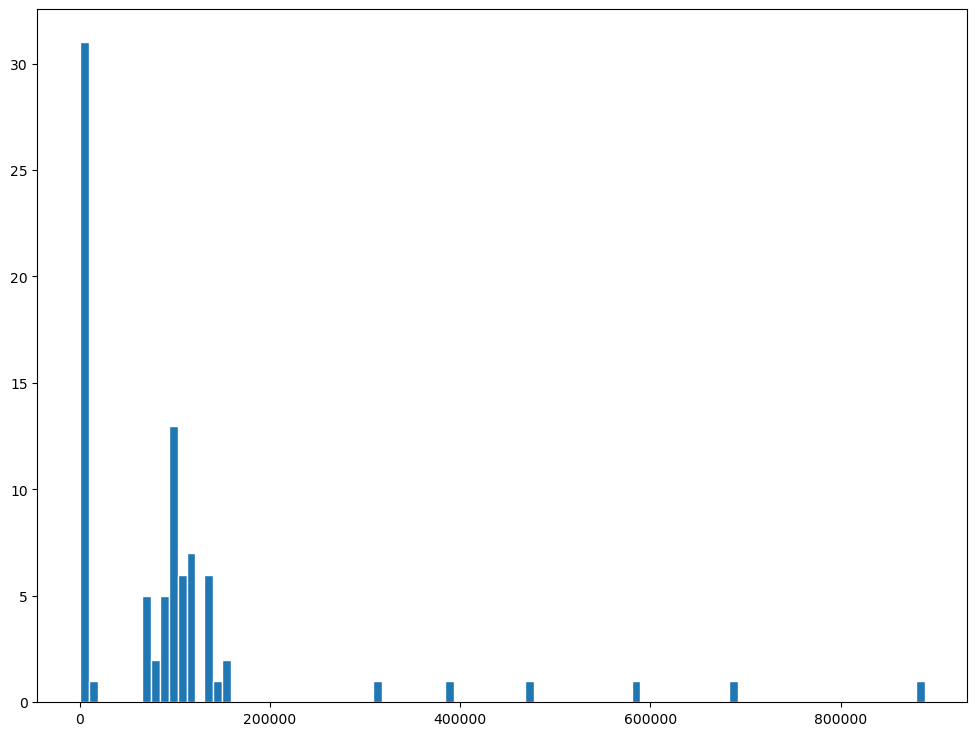

In [48]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.


plt.figure(figsize=(12, 9))
plt.hist(missing_sorted.values, bins=len(missing)+10, edgecolor='white', label=missing.index);

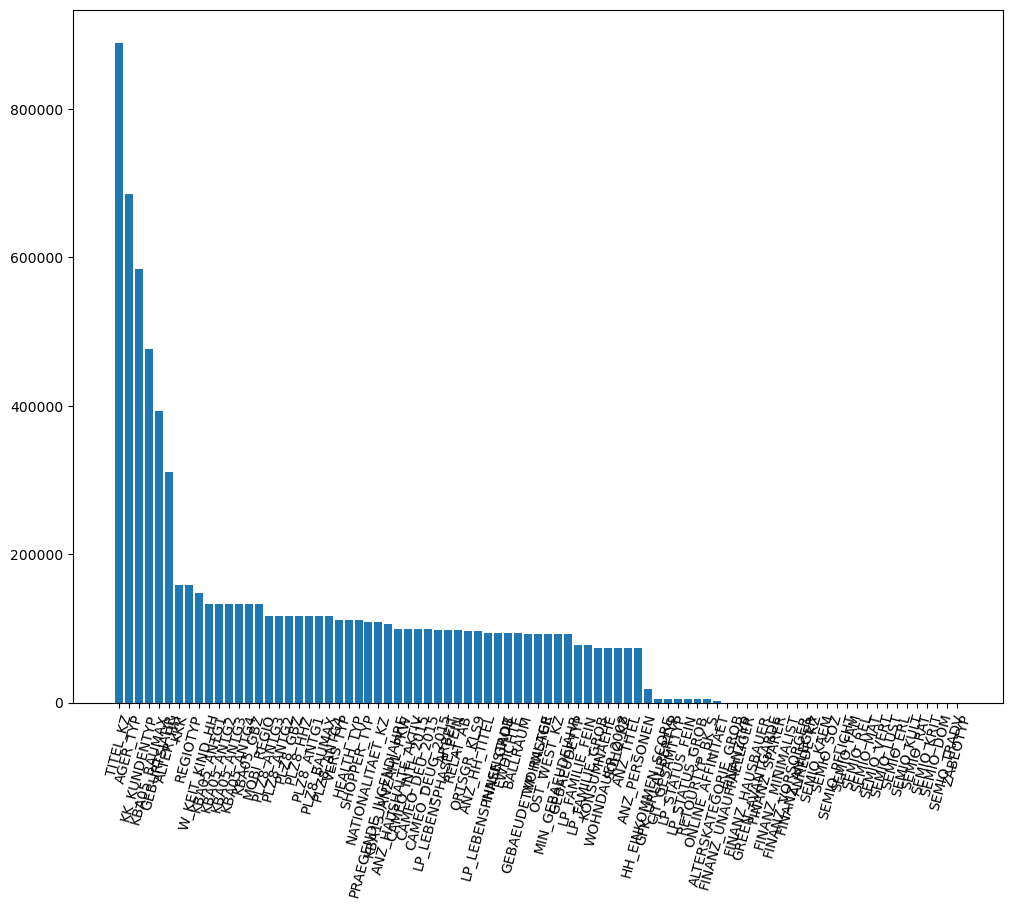

In [49]:
# Create a bar plot instead of a histogram for better representation

plt.figure(figsize=(12, 9))
plt.bar(missing_sorted.index, missing_sorted.values)
plt.xticks(rotation=75);

* Relating data in terms of percentage, we see how `TITEL_KZ` especially has **99.757636%** of its values missing. Attempting to fill this would equate adding noise to our dataset, as the odds of knowing how to fill it are low 

* Subsequent dimensions such as `AGER_TYP` and `KK_KUNDENTYP` columns might be dropped but only after more scrutiny as they have 76.9% and 65.6% of them empty respectfully

* The values of the other few columns should duely be filled with whatever medium we deem fit

In [53]:
pop.describe()

AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  205378.000000         888340.000000  891221.000000  886367.000000   
mean        1.743410              2.757217       1.522098       3.632838   
std         0.674312              1.009951       0.499512       1.595021   
min         1.000000              1.000000       1.000000       1.000000   
25%         1.000000              2.000000       1.000000       2.000000   
50%         2.000000              3.000000       2.000000       4.000000   
75%         2.000000              4.000000       2.000000       5.000000   
max         3.000000              4.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.529603   
min             1.000000       1.000000          1.000000        1.000000   
25%             2.000000       1.000000          3.000000        2.000000   
50%             3.000000       3.000000          3.000000        3.000000   
75%             4.000000       4.000000          5.000000        5.000000   
max             5.000000       5.000000          5.000000        5.000000   

       FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER      FINANZTYP    GEBURTSJAHR  \
count          891221.000000     891221.000000  891221.000000  498903.000000   
mean                2.874167          3.075121       3.790586    1967.102689   
std                 1.486731          1.353248       1.987876      17.795208   
min                 1.000000          1.000000       1.000000    1900.000000   
25%                 2.000000          2.000000       2.000000    1955.000000   
50%                 3.000000          3.000000       4.000000    1968.000000   
75%                 4.000000          4.000000       6.000000    1981.000000   
max                 5.000000          5.000000       6.000000    2017.000000   

       GFK_URLAUBERTYP  GREEN_AVANTGARDE     HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
count    886367.000000     891221.000000  780025.000000        793589.000000   
mean          7.350304          0.196612       2.190129            16.332161   
std           3.525723          0.397437       0.755213            12.242378   
min           1.000000          0.000000       1.000000             1.000000   
25%           5.000000          0.000000       2.000000             6.000000   
50%           8.000000          0.000000       2.000000            13.000000   
75%          10.000000          0.000000       3.000000            28.000000   
max          12.000000          1.000000       3.000000            40.000000   

       LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
count        796649.000000    813429.000000    813429.000000   886367.000000   
mean              4.955185         3.922339         2.381976        4.791151   
std               3.748974         3.941285         1.701527        3.425305   
min               1.000000         1.000000         1.000000        1.000000   
25%               2.000000         1.000000         1.000000        2.000000   
50%               3.000000         1.000000         1.000000        4.000000   
75%               8.000000         8.000000         4.000000        9.000000   
max              12.000000        11.000000         5.000000       10.000000   

       LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  \
count   886367.000000     782906.000000          783057.000000   
mean         2.432575          1.168889               9.280709   
std          1.474315          0.475075               4.032107   
min          1.000000          1.000000               1.000000   
25%          1.000000          1.000000               6.000000   
50%          2.000000          1.000000               9.000000   
75%     

Knowing outliers occur below and over our Lower and Upper Bounds respectively, we can use BoxPlots to visualize these points

In [55]:
pop.columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [56]:
pop['OST_WEST_KZ'].value_counts()

OST_WEST_KZ
W    629528
O    168545
Name: count, dtype: int64

* After running the first time, I realised the loop broke because some columns didnt have numeric values

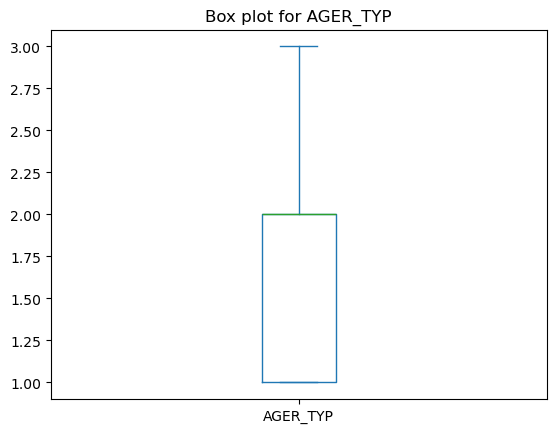

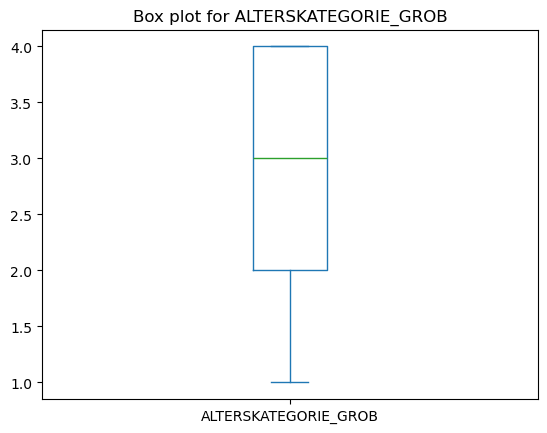

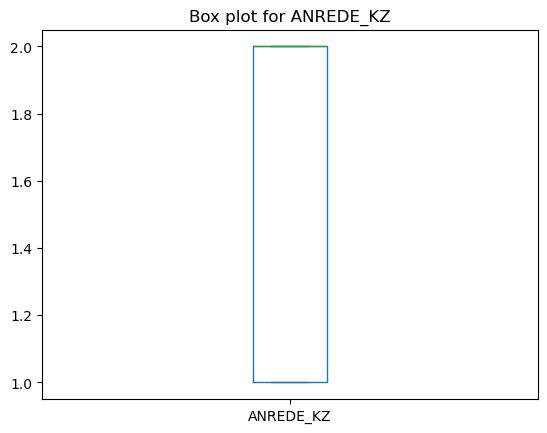

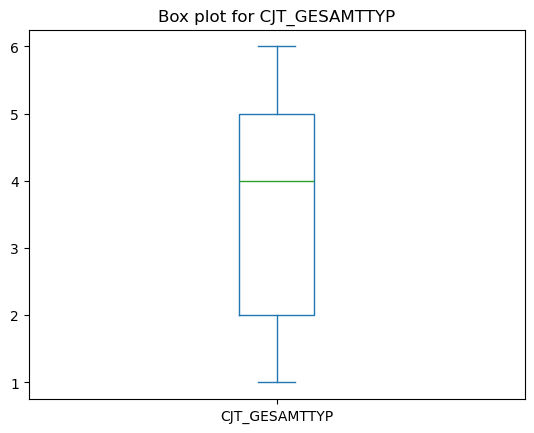

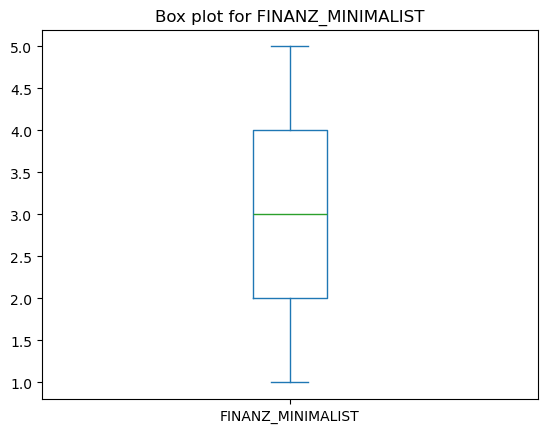

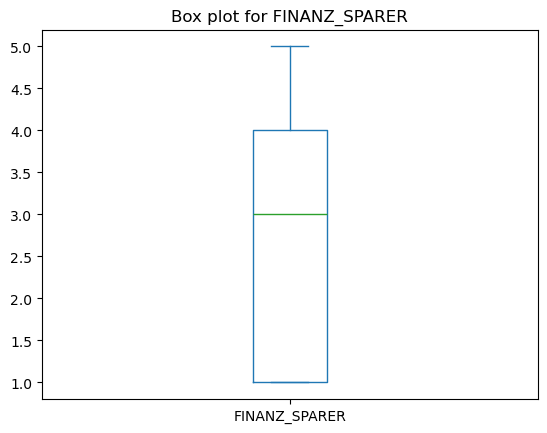

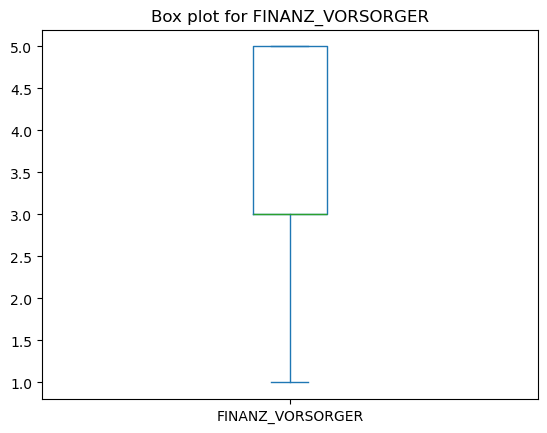

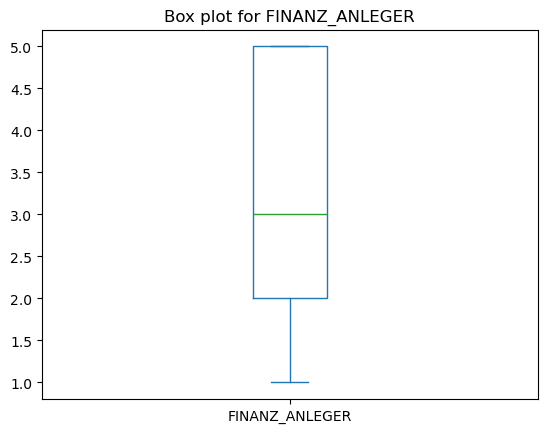

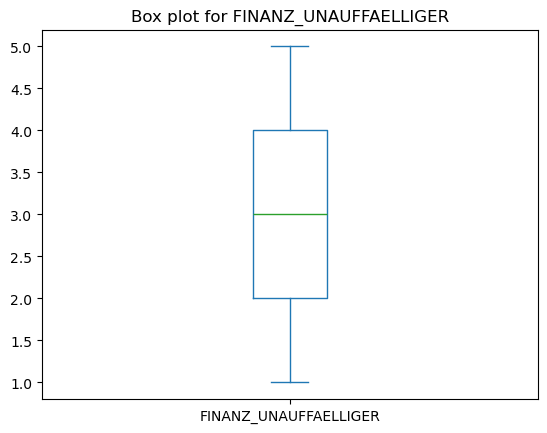

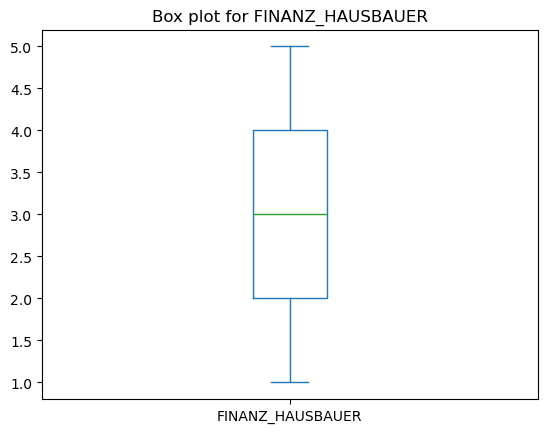

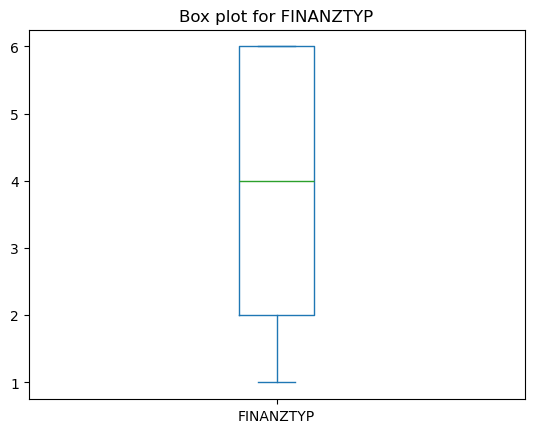

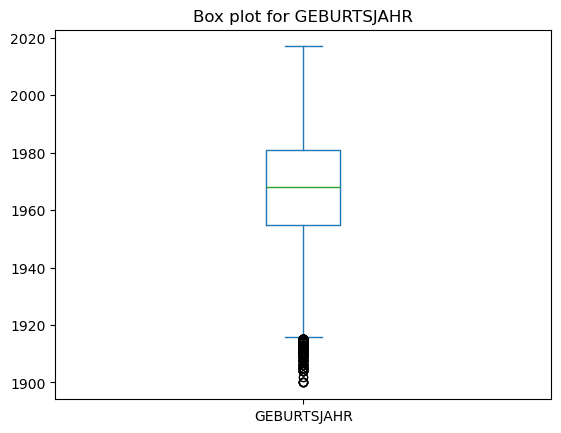

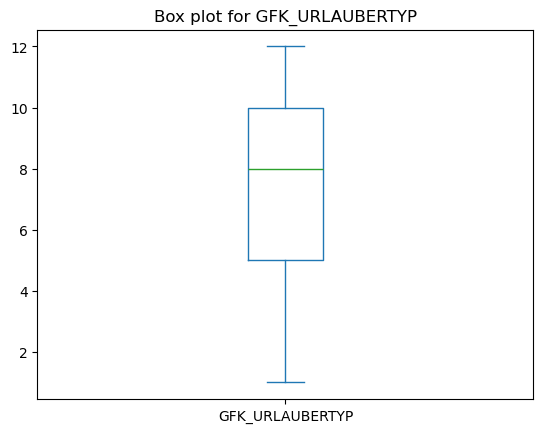

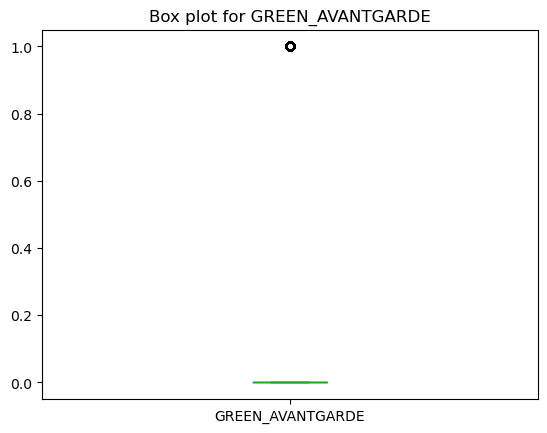

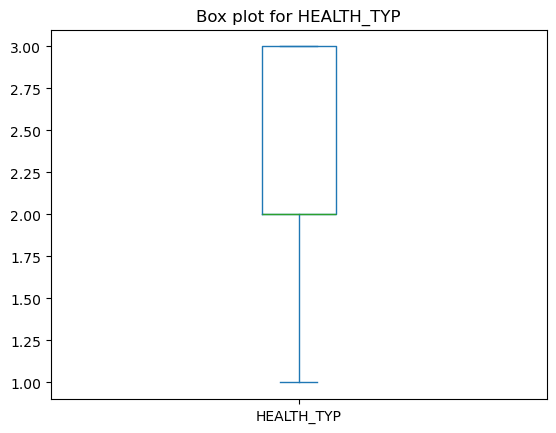

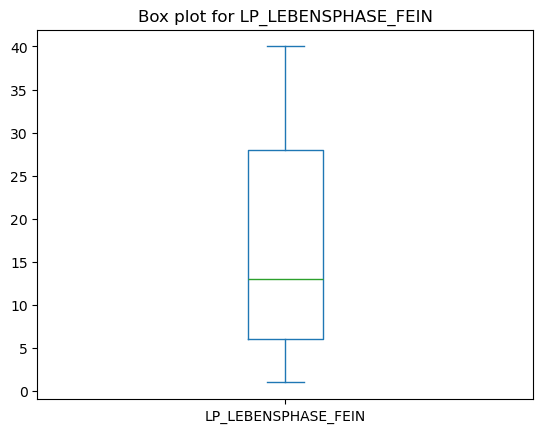

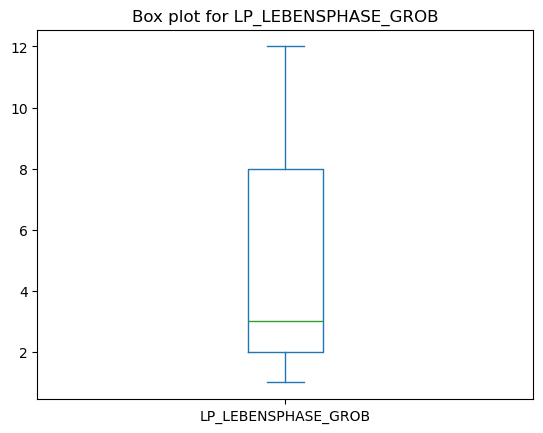

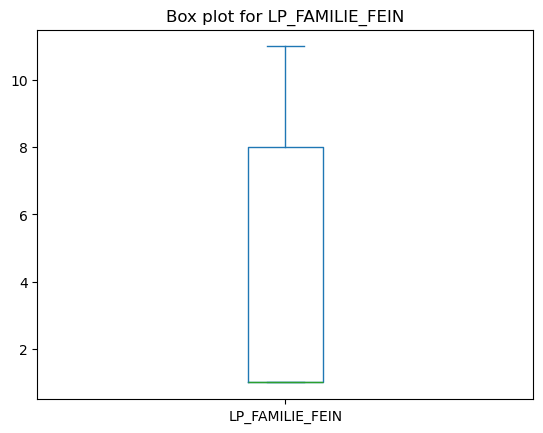

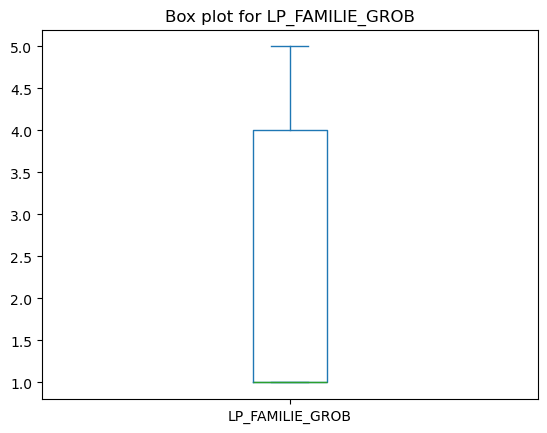

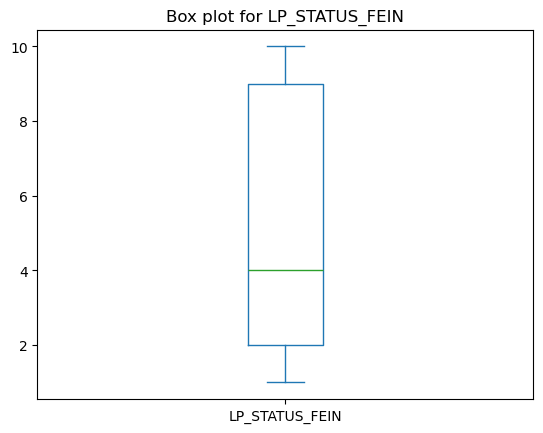

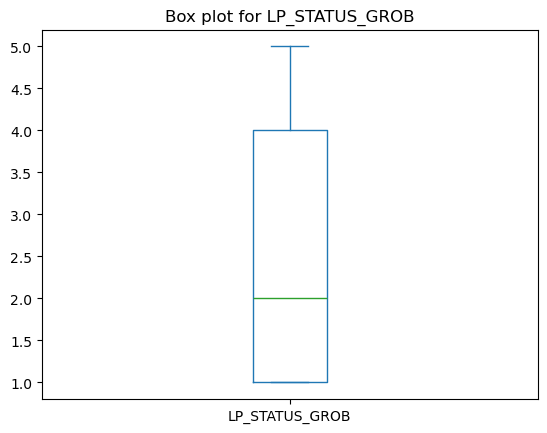

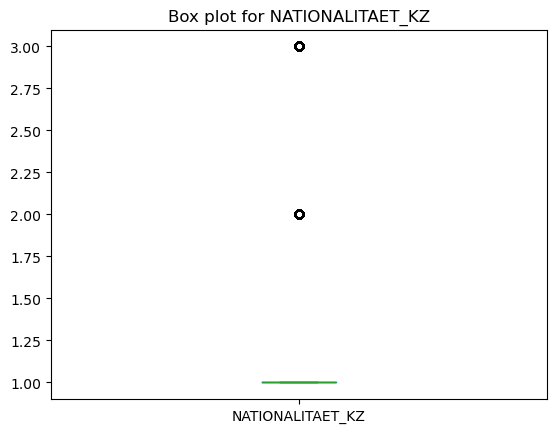

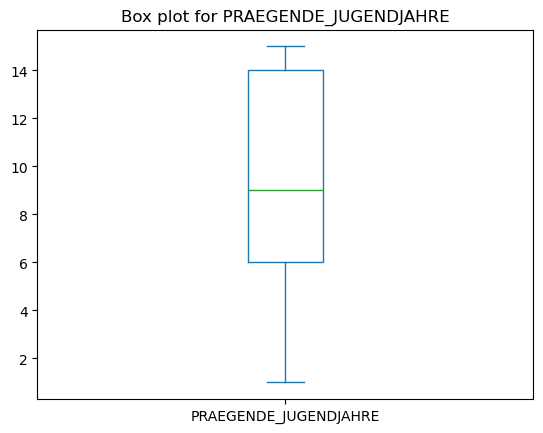

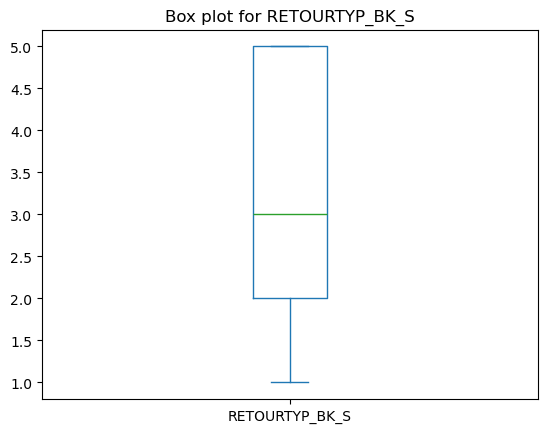

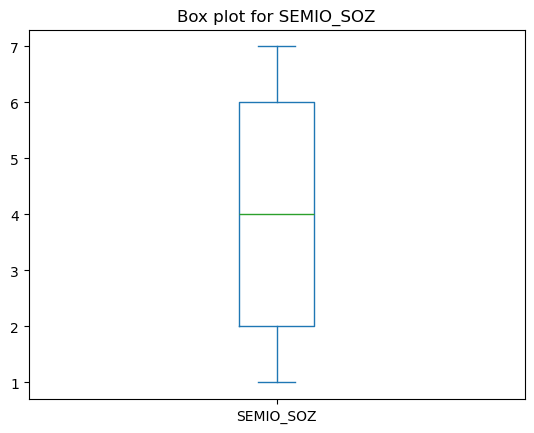

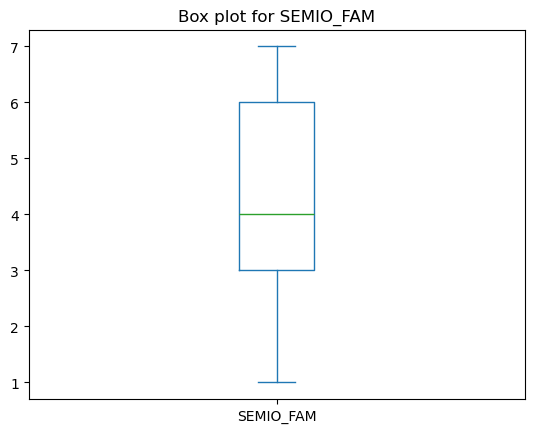

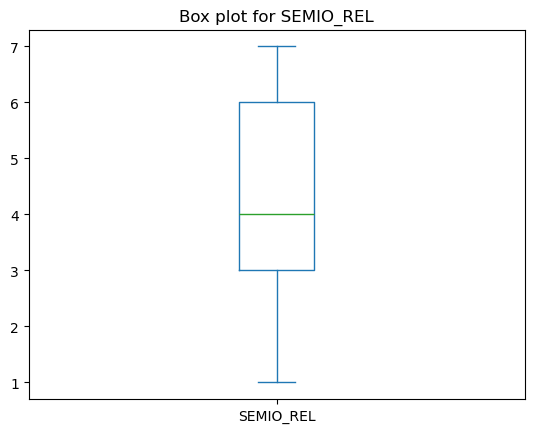

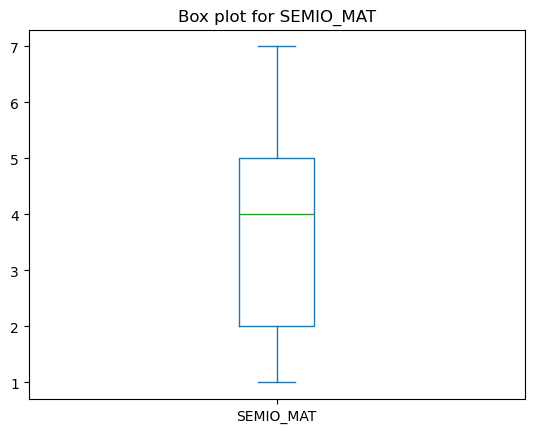

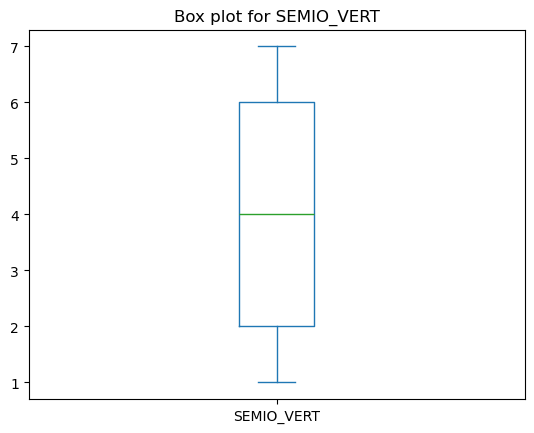

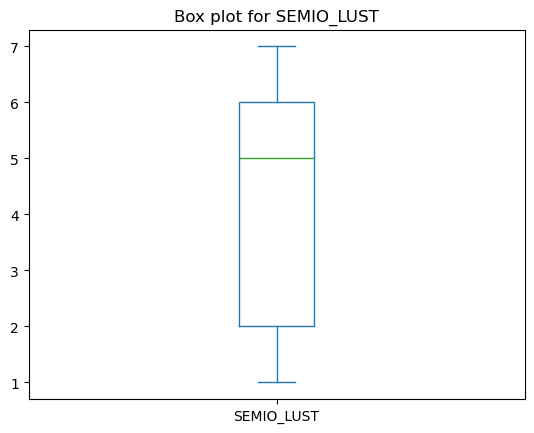

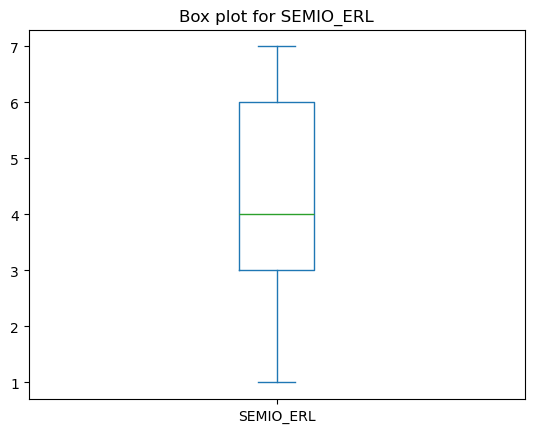

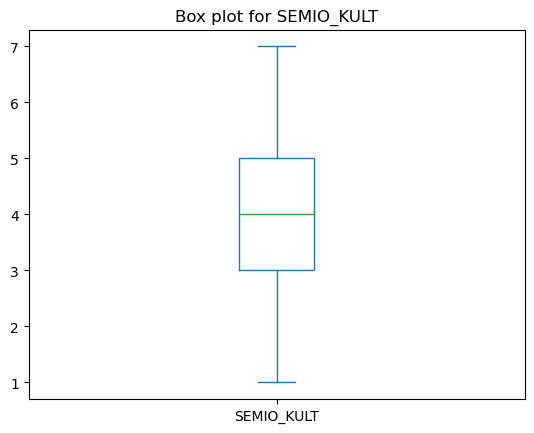

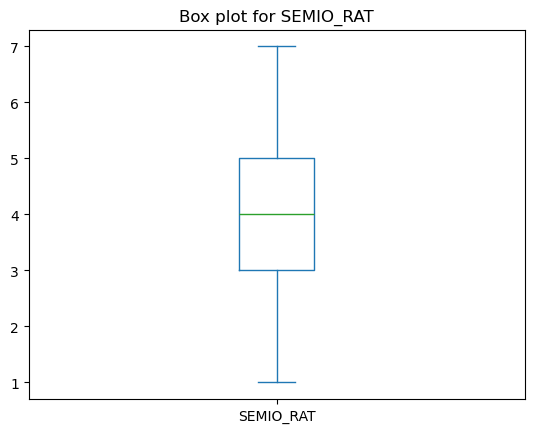

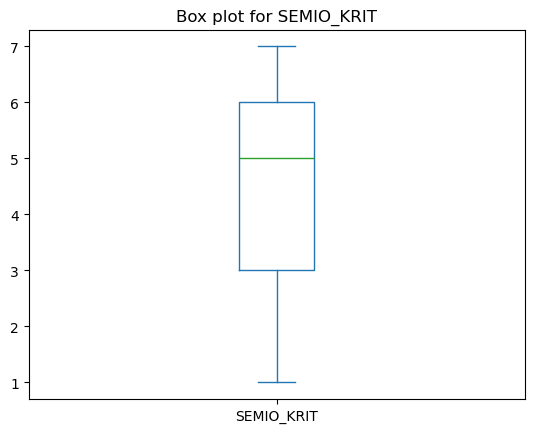

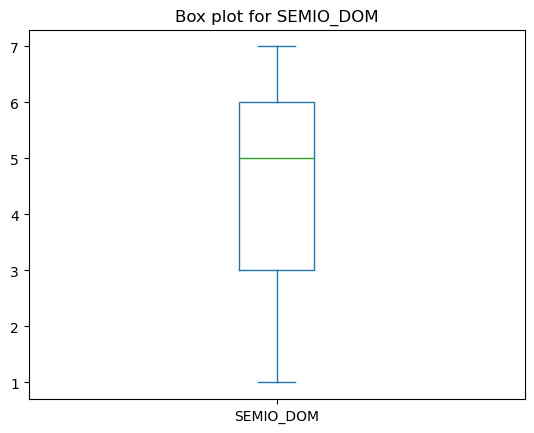

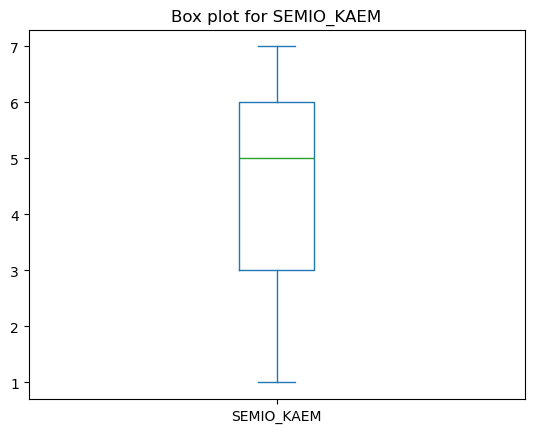

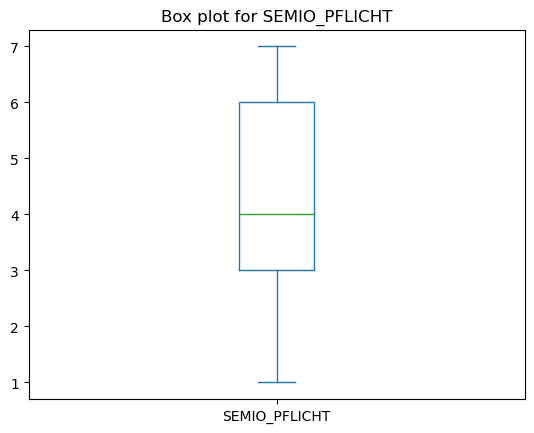

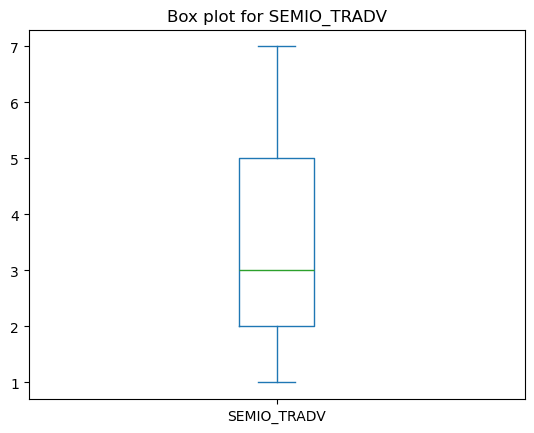

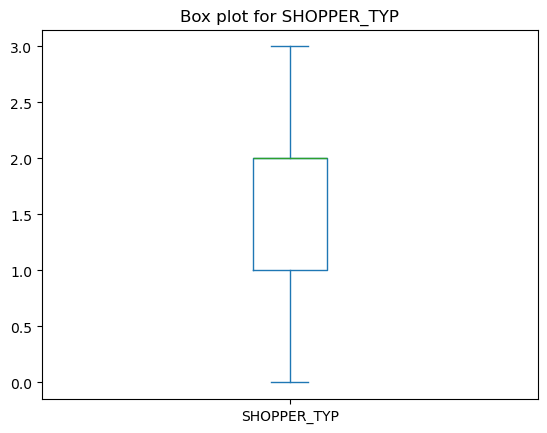

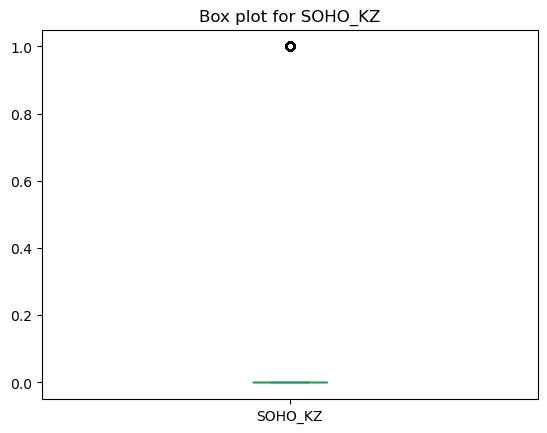

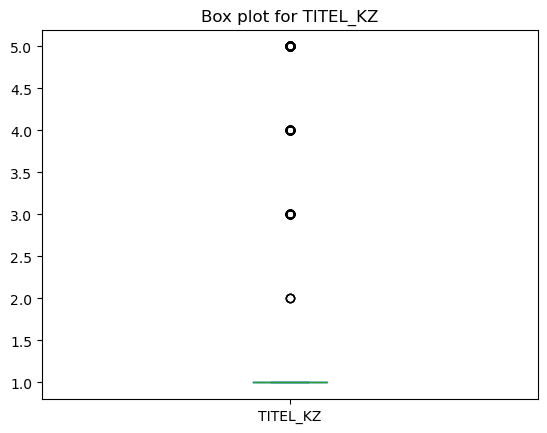

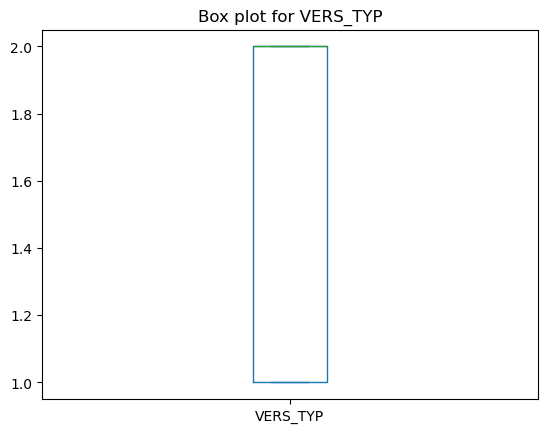

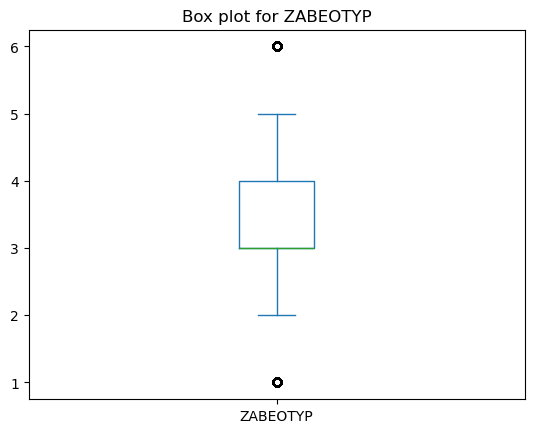

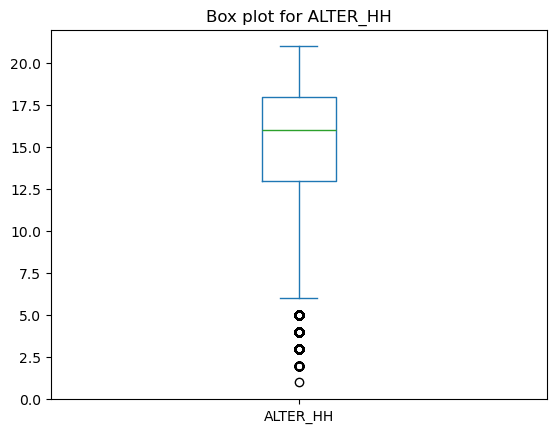

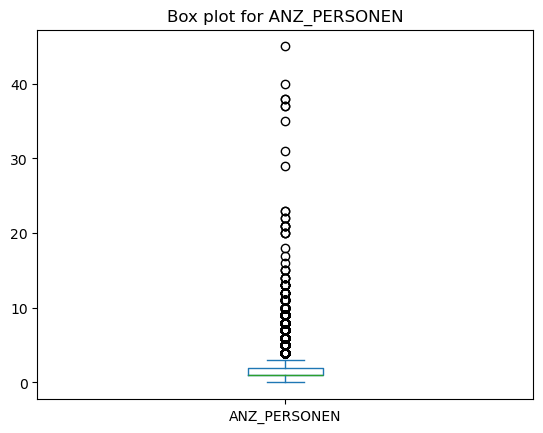

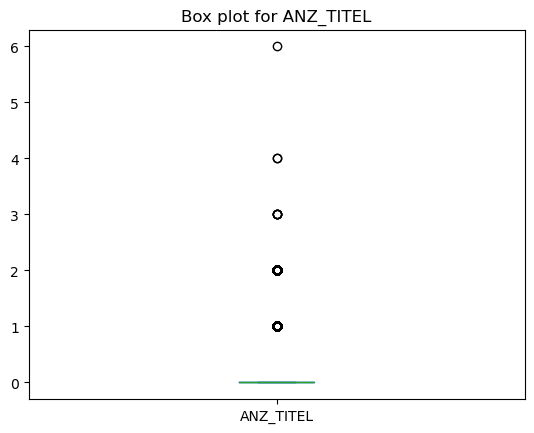

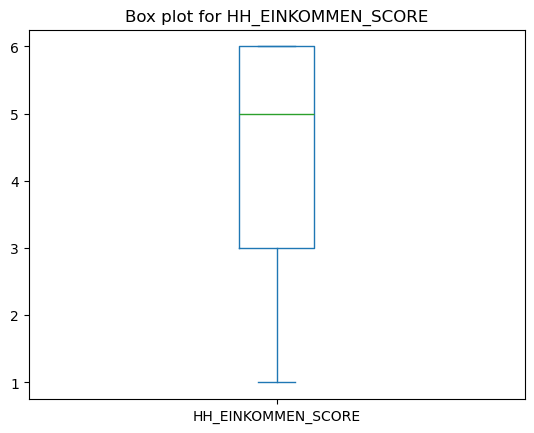

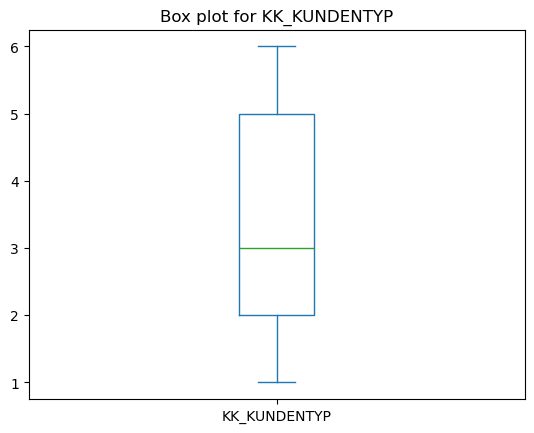

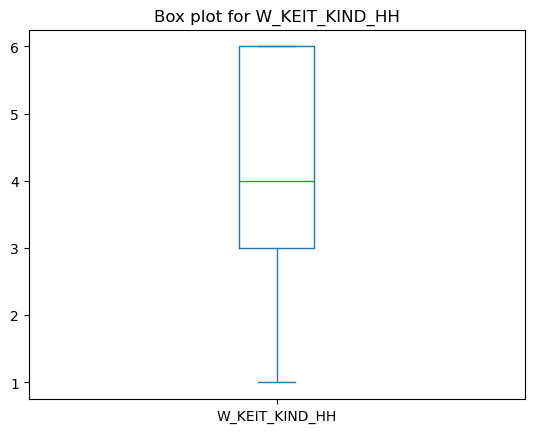

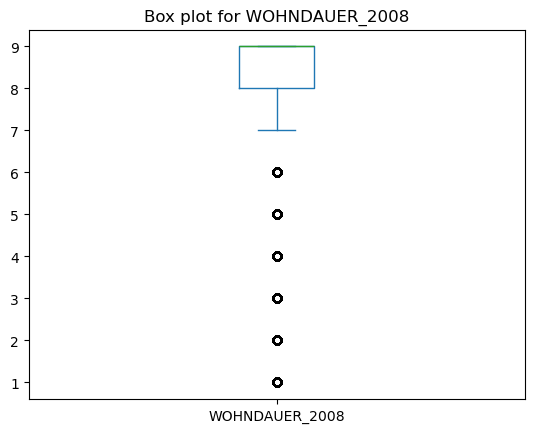

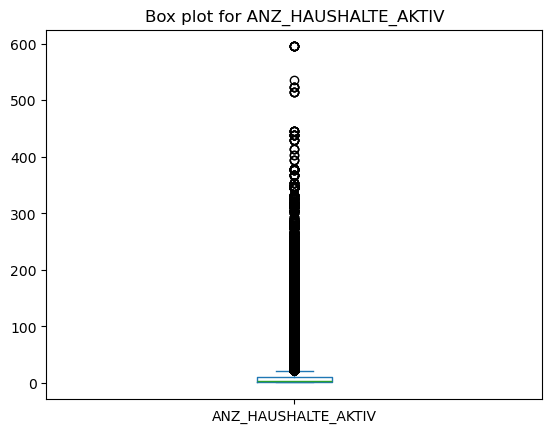

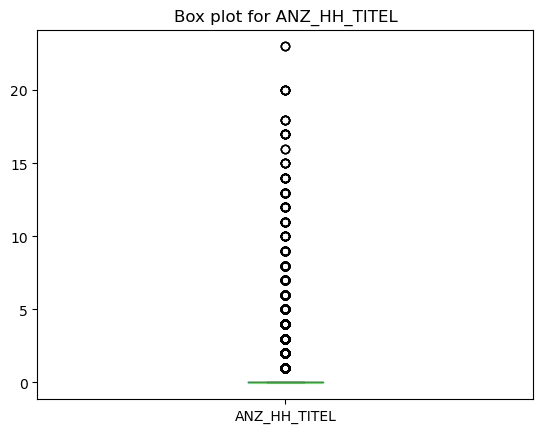

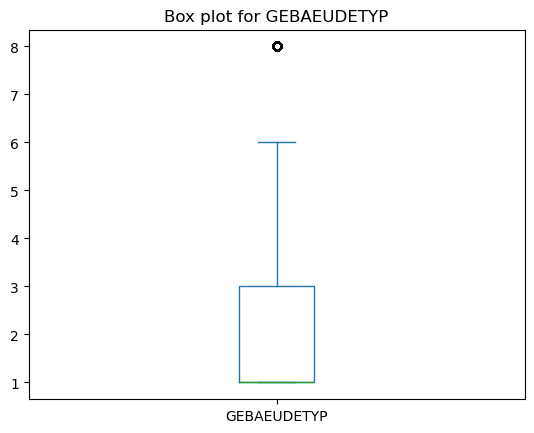

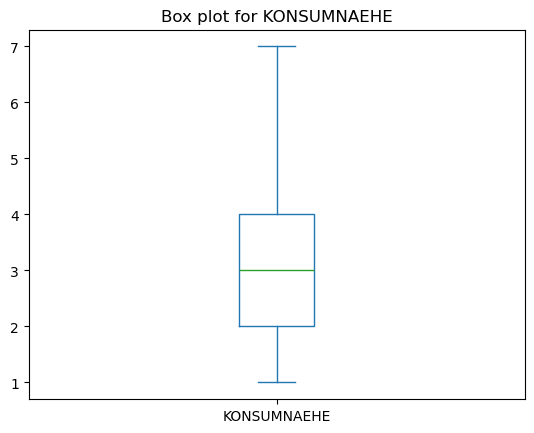

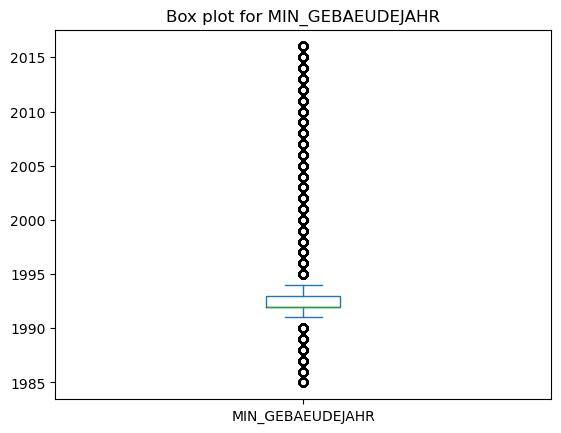

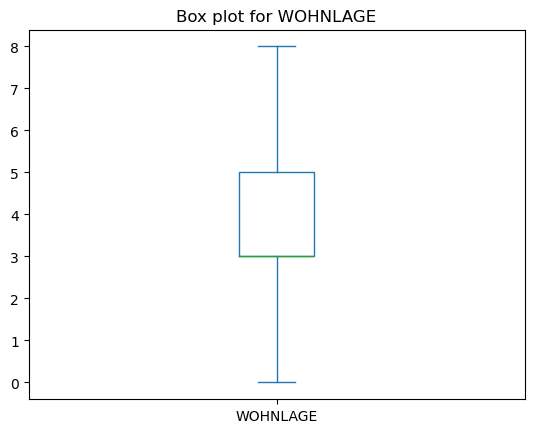

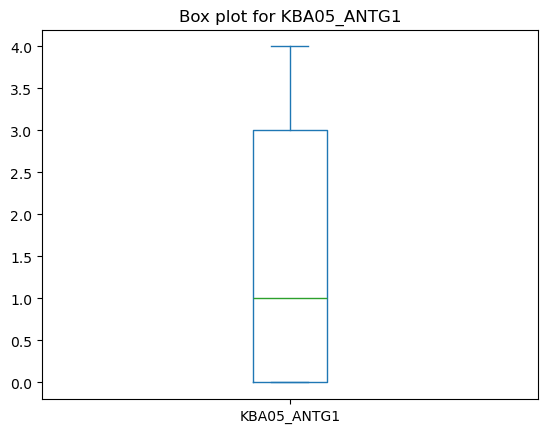

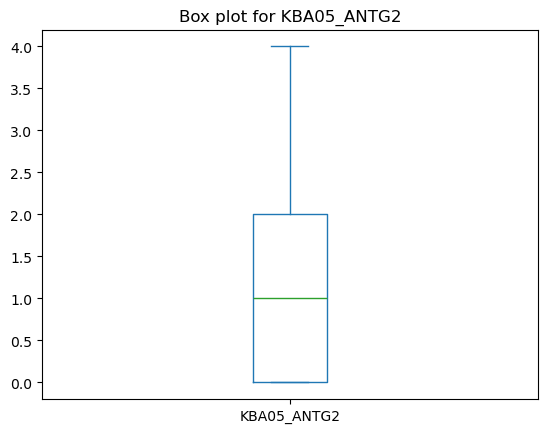

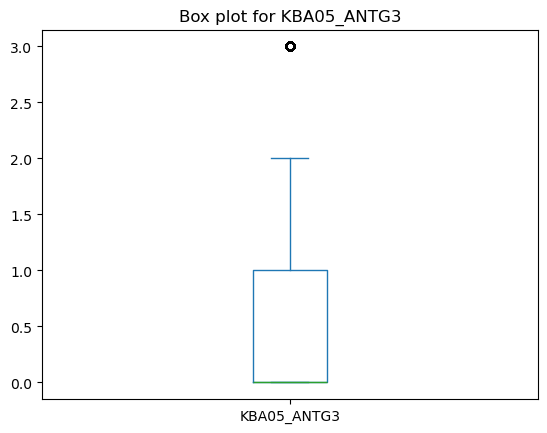

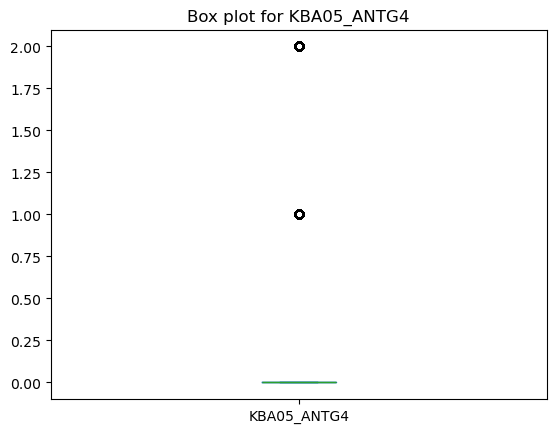

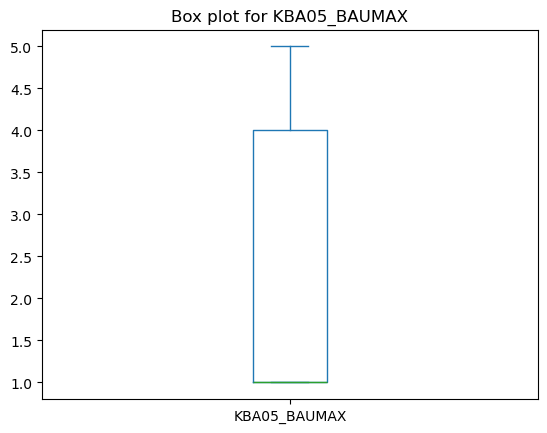

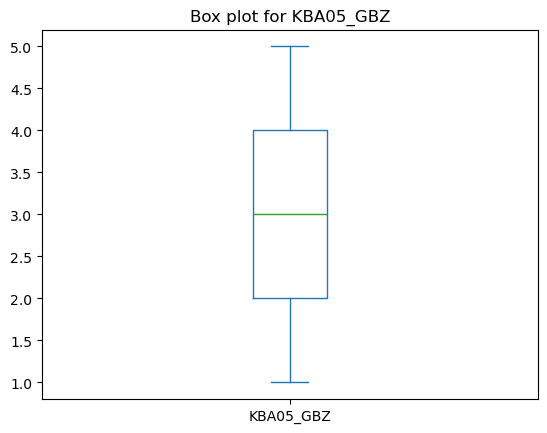

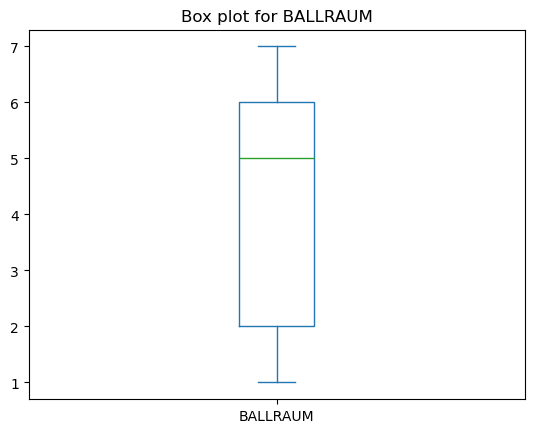

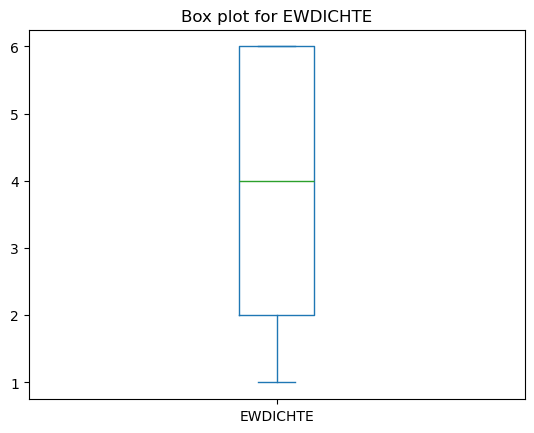

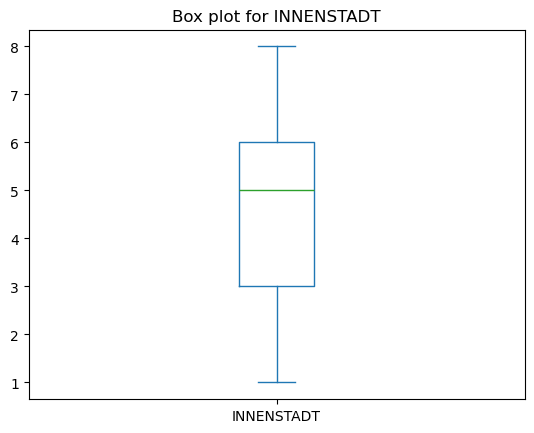

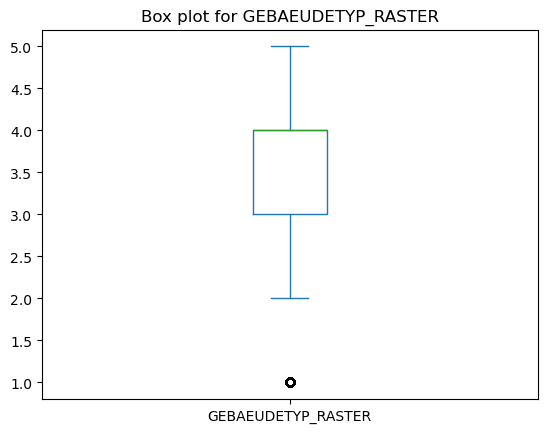

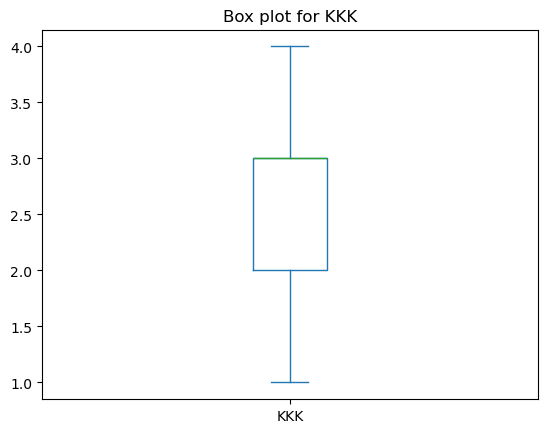

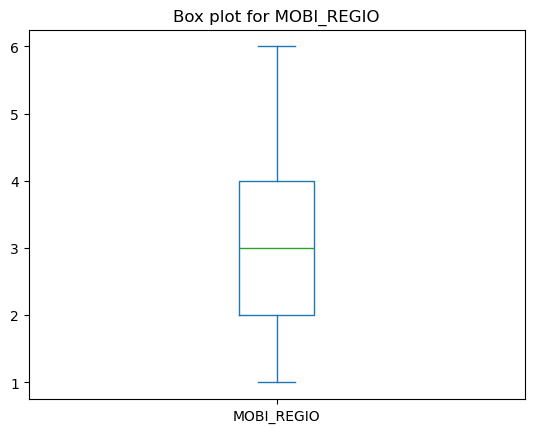

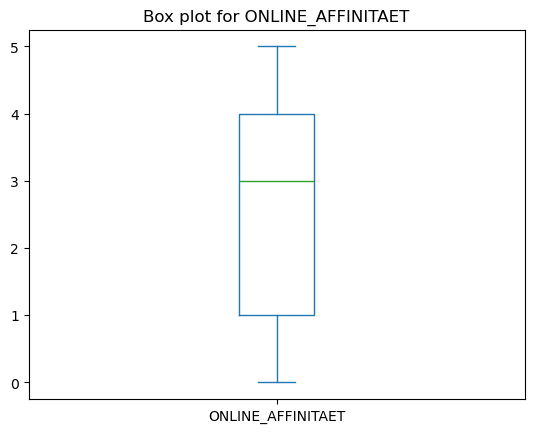

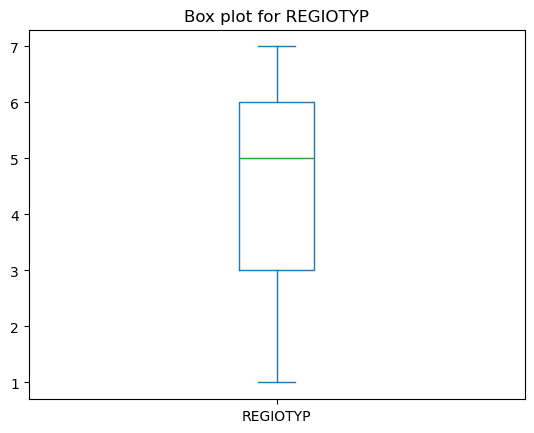

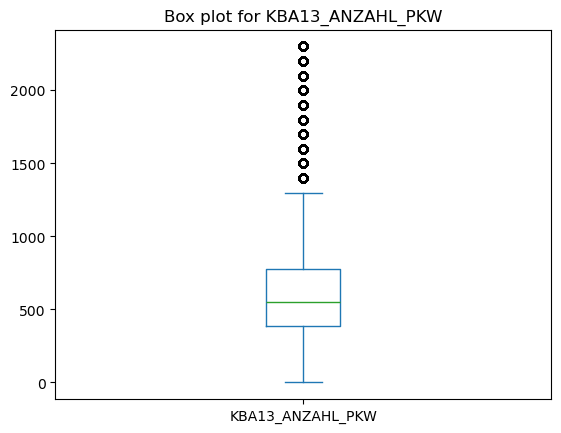

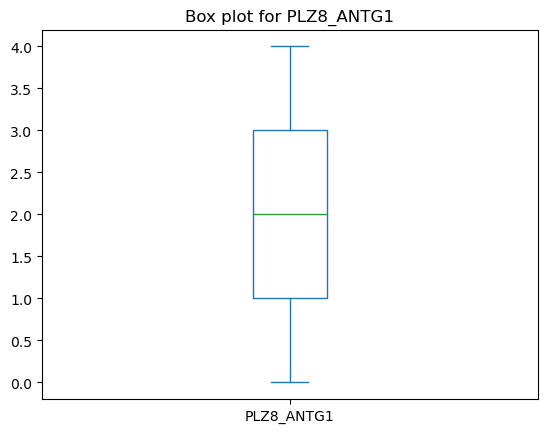

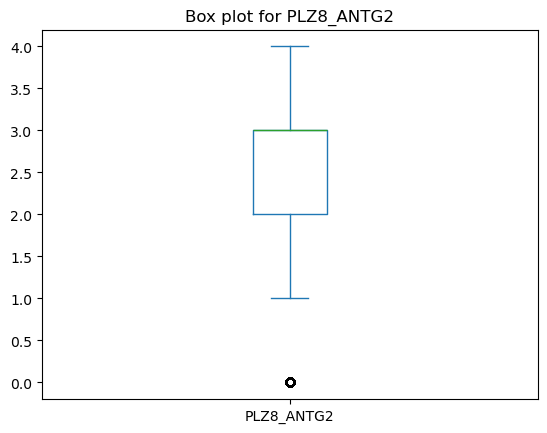

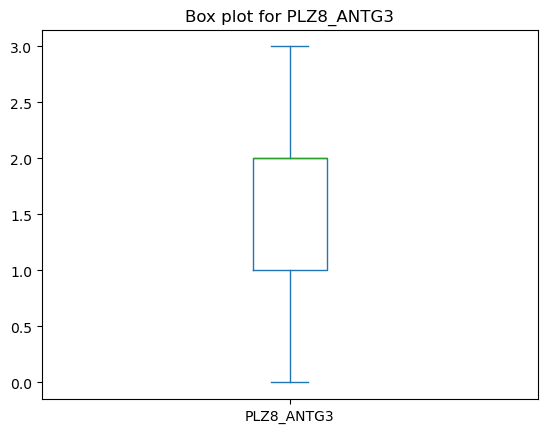

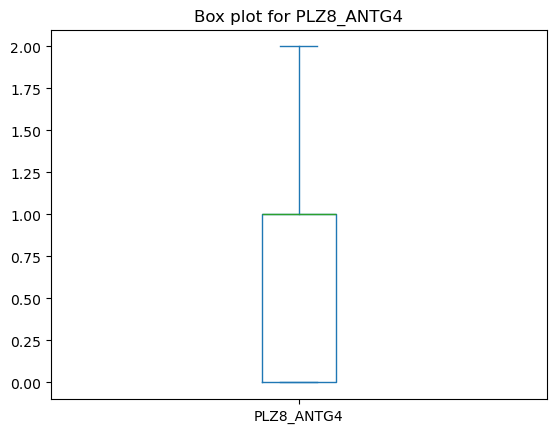

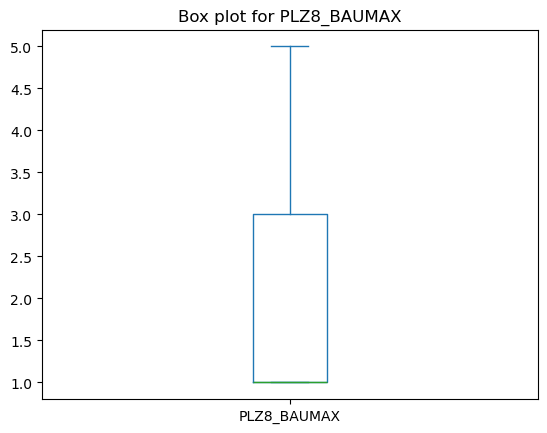

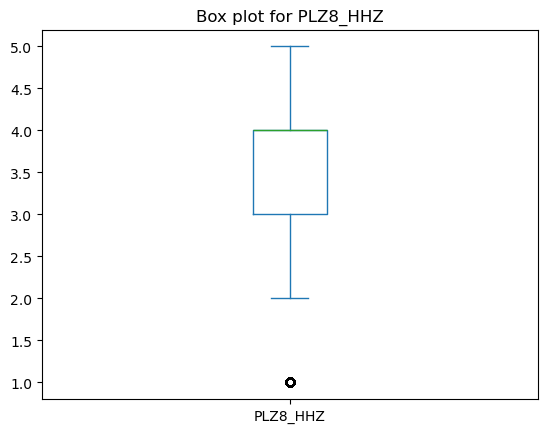

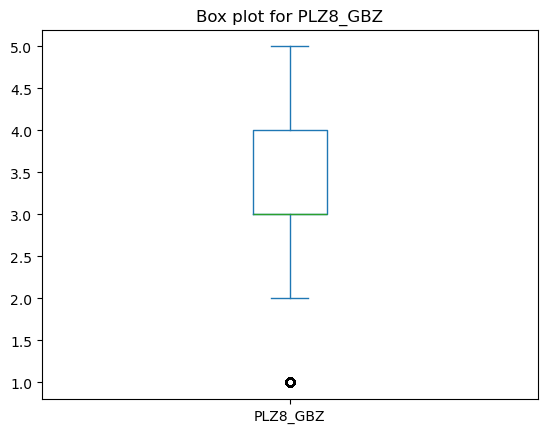

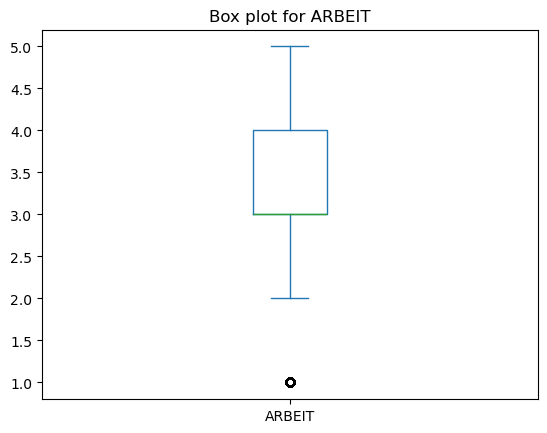

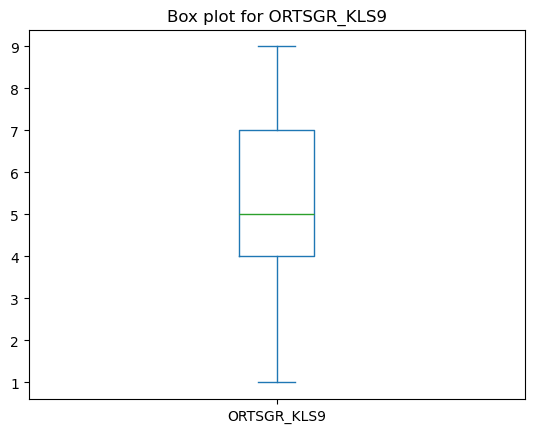

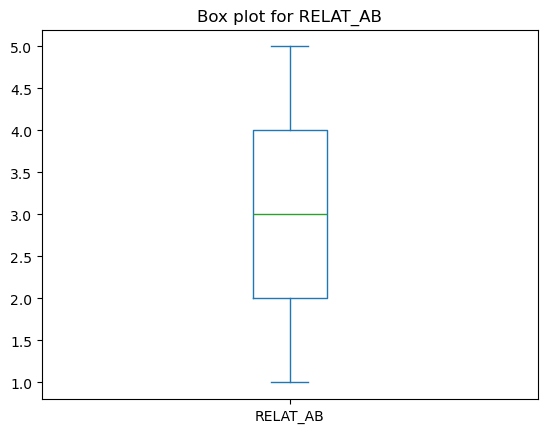

In [58]:
valueless_columns = []

for col in pop.columns:
    try:
        pop[col].plot(kind='box')
        plt.title(f'Box plot for {col}')
        plt.show()
    except TypeError:
        valueless_columns.append(col)
        continue

In [59]:
print(valueless_columns)

['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']


In [60]:
for value in valueless_columns:
    print(pop[value].value_counts().reset_index().iloc[:,0].values)     #checking the values that are alien to us
    print(f'Values in {value} are above this text\n\n')

['W' 'O']
Values in OST_WEST_KZ are above this text


['8' '9' '6' '4' '3' '2' '7' '5' '1']
Values in CAMEO_DEUG_2015 are above this text


['6B' '8A' '4C' '2D' '3C' '7A' '3D' '8B' '4A' '8C' '9D' '9B' '9C' '7B'
 '9A' '2C' '8D' '6E' '2B' '5D' '6C' '2A' '5A' '1D' '1A' '3A' '5B' '5C'
 '7C' '4B' '4D' '3B' '6A' '9E' '6D' '6F' '7D' '4E' '1E' '7E' '1C' '5F'
 '1B' '5E']
Values in CAMEO_DEU_2015 are above this text


['51' '41' '24' '14' '43' '54' '25' '22' '23' '13' '45' '55' '52' '31'
 '34' '15' '44' '12' '35' '32' '33']
Values in CAMEO_INTL_2015 are above this text




* We missed these while **visually** confirming the output of 'check_value_counts()'

In [62]:
pop[valueless_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   OST_WEST_KZ      798073 non-null  object
 1   CAMEO_DEUG_2015  791869 non-null  object
 2   CAMEO_DEU_2015   791869 non-null  object
 3   CAMEO_INTL_2015  791869 non-null  object
dtypes: object(4)
memory usage: 27.2+ MB


* From this, we can see how the `CAMEO_INTL_2015`, `CAMEO_DEUG_2015` especially should easily have been usable if only they were encoded as numeric dimensions

In [64]:
pop['CAMEO_INTL_2015'] = pd.to_numeric(pop['CAMEO_INTL_2015'], downcast='integer')    
pop['CAMEO_DEUG_2015'] = pd.to_numeric(pop['CAMEO_DEUG_2015'], downcast='integer')

In [65]:
pop.head().select_dtypes(include='number').columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [66]:
pop.head().select_dtypes(include='object').columns    #verifying what our are as they should

Index(['OST_WEST_KZ', 'CAMEO_DEU_2015'], dtype='object')

In [67]:
len(pop.head().select_dtypes(include='number').columns)

83

#### Dropping Columns now

* On first thought, I thought the `CAMEO_DEU_2015` itself needs an extraction of the Alphabets begind each letter, but iinvestigating further, we have different values for each integer. 7 has an A, a C, and so on. This leaves more unanswered questions than any other thing
* We really cant make sense of `OST_WEST_KZ`, but it having only W and O as values means we can encode it to be binary.

In [70]:
pop = pop.drop(['TITEL_KZ', 'CAMEO_DEU_2015'], axis=1)

* Knowing well that Z score being a function of how a point deviates from other points, we can use a high Z threshold to remove outliers, but not too many as to alter out analysis
​
 

In [72]:
# Investigate patterns in the amount of missing data in each column.

In [73]:
pop.head().select_dtypes(include='number').columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ALTER_HH',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP',
       'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV',
       'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR',
    

In [74]:
pop.select_dtypes(include='object').keys()

Index(['OST_WEST_KZ'], dtype='object')

In [75]:
pop.select_dtypes(include='number').keys()

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ALTER_HH',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP',
       'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV',
       'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR',
    

In [76]:
pop['OST_WEST_KZ'].value_counts()

OST_WEST_KZ
W    629528
O    168545
Name: count, dtype: int64

In [77]:
pop['OST_WEST_KZ'] = pop['OST_WEST_KZ'].replace({'W':0, 'O':1})

/var/folders/y1/2cln1s193dgc6xy3yzry761r0000gn/T/ipykernel_25560/4260463308.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pop['OST_WEST_KZ'] = pop['OST_WEST_KZ'].replace({'W':0, 'O':1})


In [78]:
pop['OST_WEST_KZ'].value_counts()

OST_WEST_KZ
0.0    629528
1.0    168545
Name: count, dtype: int64

In [79]:
def remove_outliers_zscore(df:pd.DataFrame, threshold:int=3) -> pd.DataFrame:
    """
    INPUT: 
    df: dataframe to perform outlier reduction on
    threshold: a threshold against the Z score(spread)

    OUTPUT:
    pd.DataFrame: A new DataFrame with outliers removed.
    """
    df = df.select_dtypes(include='number')
    z_scores = np.abs(stats.zscore(df))
    return df[(z_scores < threshold).all(axis=1)]

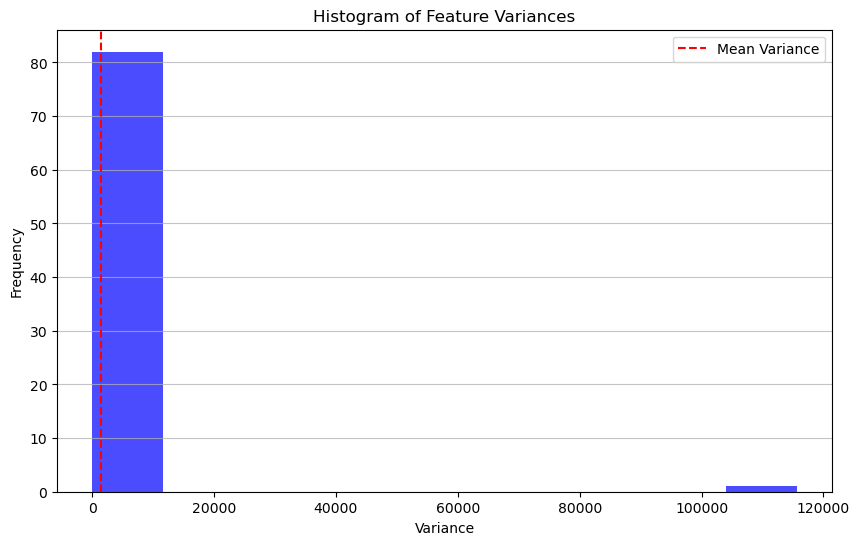

In [80]:
variances = pop.var()

plt.figure(figsize=(10, 6))
plt.hist(variances, bins=10, color='blue', alpha=0.7)
plt.title('Histogram of Feature Variances')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.axvline(x=variances.mean(), color='red', linestyle='--', label='Mean Variance')
plt.legend()
plt.show()

In [81]:
variance_count = pop.var().sort_values(ascending=False)     #computes the variance for a dataframe
variance_count

KBA13_ANZAHL_PKW         115623.337229
GEBURTSJAHR                 316.669420
ANZ_HAUSHALTE_AKTIV         245.665852
CAMEO_INTL_2015             196.854351
LP_LEBENSPHASE_FEIN         149.875812
PRAEGENDE_JUGENDJAHRE        16.257885
LP_FAMILIE_FEIN              15.533731
ALTER_HH                     14.444072
LP_LEBENSPHASE_GROB          14.054807
GFK_URLAUBERTYP              12.430724
LP_STATUS_FEIN               11.732715
MIN_GEBAEUDEJAHR             11.107149
GEBAEUDETYP                   7.058126
CAMEO_DEUG_2015               6.199253
ORTSGR_KLS9                   5.305553
BALLRAUM                      4.768589
SEMIO_VERT                    4.317029
INNENSTADT                    4.116513
SEMIO_LUST                    4.091839
SEMIO_REL                     4.029545
FINANZTYP                     3.951651
WOHNLAGE                      3.800701
SEMIO_SOZ                     3.789112
WOHNDAUER_2008                3.698456
SEMIO_FAM                     3.670615
SEMIO_KULT               

In [82]:
variance_count.iloc[0]

115623.33722931633

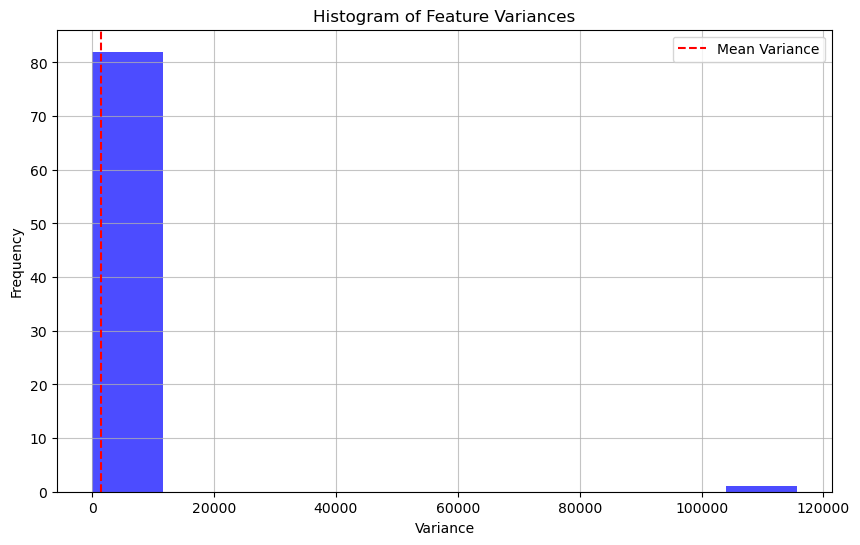

In [83]:
variances = pop.var()

plt.figure(figsize=(10, 6))
plt.hist(variances, bins=10, color='blue', alpha=0.7)
plt.title('Histogram of Feature Variances')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.grid(axis='both', alpha=0.75)
plt.axvline(x=variances.mean(), color='red', linestyle='--', label='Mean Variance')
plt.legend()
plt.show()

* Having a variance of 115623.337229, `KBA13_ANZAHL_PKW`, would totally skew our entire data, it is only logical we take it out really.
*  `ANZ_HH_TITEL`, `SOHO_KZ`, `ANZ_TITEL` columns have 0.104994, 0.008352 and 0.004741 variability in total, very minimal, we can drop these too

In [85]:
variances_to_drop = ['KBA13_ANZAHL_PKW', 'ANZ_HH_TITEL', 'SOHO_KZ', 'ANZ_TITEL']

In [86]:
pop = pop.drop(axis=1, columns=variances_to_drop)

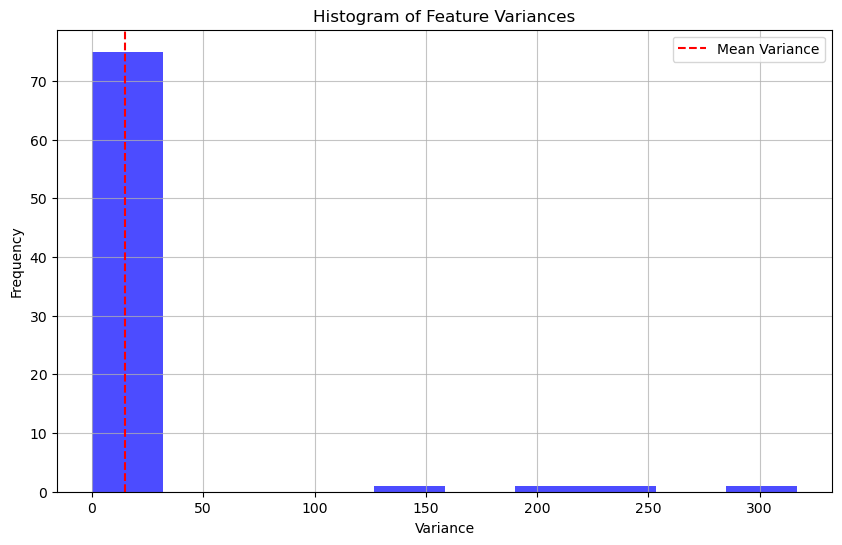

In [87]:
variances = pop.var()

plt.figure(figsize=(10, 6))
plt.hist(variances, bins=10, color='blue', alpha=0.7)
plt.title('Histogram of Feature Variances')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.grid(axis='both', alpha=0.75)
plt.axvline(x=variances.mean(), color='red', linestyle='--', label='Mean Variance')
plt.legend()
plt.show()

In [88]:
def identify_outlier_columns(df: pd.DataFrame, threshold: int=3) -> list:
    """
    INPUT:
    df: pandas dataframe to identify outlier columns
    threshold: integer value for valyes that fall outside mean +- 3* STD

    OUTPUT:
    outlier_columns: a list stating what columns are outliers
    """
    outlier_columns = []
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (threshold * IQR)
        upper_bound = Q3 + (threshold * IQR)
        if df[(df[column] < lower_bound) | (df[column] > upper_bound)].shape[0] > 0:
            outlier_columns.append(column)
    return outlier_columns

In [89]:
variance_count

KBA13_ANZAHL_PKW         115623.337229
GEBURTSJAHR                 316.669420
ANZ_HAUSHALTE_AKTIV         245.665852
CAMEO_INTL_2015             196.854351
LP_LEBENSPHASE_FEIN         149.875812
PRAEGENDE_JUGENDJAHRE        16.257885
LP_FAMILIE_FEIN              15.533731
ALTER_HH                     14.444072
LP_LEBENSPHASE_GROB          14.054807
GFK_URLAUBERTYP              12.430724
LP_STATUS_FEIN               11.732715
MIN_GEBAEUDEJAHR             11.107149
GEBAEUDETYP                   7.058126
CAMEO_DEUG_2015               6.199253
ORTSGR_KLS9                   5.305553
BALLRAUM                      4.768589
SEMIO_VERT                    4.317029
INNENSTADT                    4.116513
SEMIO_LUST                    4.091839
SEMIO_REL                     4.029545
FINANZTYP                     3.951651
WOHNLAGE                      3.800701
SEMIO_SOZ                     3.789112
WOHNDAUER_2008                3.698456
SEMIO_FAM                     3.670615
SEMIO_KULT               

In [90]:
pop_outliers = identify_outlier_columns(pop)
pop_outliers

['GREEN_AVANTGARDE',
 'NATIONALITAET_KZ',
 'ANZ_PERSONEN',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'KBA05_ANTG4']

In [91]:
pop = pop.drop(columns=pop_outliers, axis=1)

In [92]:
pop.shape[1]

71

In [93]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#### Discussion 1.1.2: Assess Missing / Outlier Data in Each Column

Although these were already discussed in earlier markdown cells, underneath is the summary

* `TITEL_KZ` especially has 99.757636% of its values missing. 
* Columns `AGER_TYP` and `KK_KUNDENTYP` are taken under scrutiny as they have 76.9% and 65.6% of them empty respectfully.
* `OST_WEST_KZ`, `CAMEO_DEUG_2015`, `CAMEO_DEU_2015`, `CAMEO_INTL_2015` columns specicially were filled with unformattable data of different types, some we couldn't work with, the others we could wrangle.
* In the end, `OST_WEST_KZ`, `TITEL_KZ`, `CAMEO_DEU_2015' had to be dropped after the above considerations
* `KBA13_ANZAHL_PKW`, `ANZ_HH_TITEL`, `SOHO_KZ`, `ANZ_TITEL` have also been dropped because of their variance values
* `GREEN_AVANTGARDE`,`NATIONALITAET_KZ`,`ANZ_PERSONEN`,`WOHNDAUER_2008`,`ANZ_HAUSHALTE_AKTIV`,`MIN_GEBAEUDEJAHR`,`KBA05_ANTG4` didnt meet our threshold for outliers

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [96]:
# How much data is missing in each row of the dataset?

missing_rows = ((pop.isna().sum(axis=1)/pop.shape[1])*100)   #displayingg what percentage of each row is missing 

In [97]:
missing_rows[:10]

0    50.704225
1     4.225352
2     4.225352
3    11.267606
4     2.816901
5     1.408451
6     5.633803
7     4.225352
8     4.225352
9     2.816901
dtype: float64

In [98]:
pop.iloc[0].reset_index().T   #examining our first row

0                     1          2              3   \
index  AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP   
0           NaN                   2.0        1.0            2.0   

                      4              5                 6               7   \
index  FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER   
0                    3.0            4.0               3.0             5.0   

                          8                 9          10           11  \
index  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR   
0                        5.0               3.0        4.0          NaN   

                    12          13                   14                   15  \
index  GFK_URLAUBERTYP  HEALTH_TYP  LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB   
0                 10.0         NaN                 15.0                  4.0   

                    16               17              18              19  \
index  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  LP_STATUS_GROB   
0                  2.0              2.0             1.0             1.0   

                          20              21         22         23         24  \
index  PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL   
0                        NaN             5.0        2.0        6.0        7.0   

              25          26          27         28          29         30  \
index  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT   
0            5.0         1.0         5.0        3.0         3.0        4.0   

               31         32          33             34           35  \
index  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV   
0             7.0        6.0         6.0            5.0          3.0   

                36        37        38        39                  40  \
index  SHOPPER_TYP  VERS_TYP  ZABEOTYP  ALTER_HH  HH_EINKOMMEN_SCORE   
0              NaN       NaN       3.0       NaN                 2.0   

                 41              42           43           44        45  \
index  KK_KUNDENTYP  W_KEIT_KIND_HH  GEBAEUDETYP  KONSUMNAEHE  WOHNLAGE   
0               NaN             NaN          NaN          NaN       NaN   

                    46               47           48           49  \
index  CAMEO_DEUG_2015  CAMEO_INTL_2015  KBA05_ANTG1  KBA05_ANTG2   
0                  NaN              NaN          NaN          NaN   

                50            51         52        53        54          55  \
index  KBA05_ANTG3  KBA05_BAUMAX  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT   
0              NaN           NaN        NaN       NaN       NaN         NaN   

                       56   57          58                 59        60  \
index  GEBAEUDETYP_RASTER  KKK  MOBI_REGIO  ONLINE_AFFINITAET  REGIOTYP   
0                     NaN  NaN         NaN                1.0       NaN   

               61          62          63          64           65        66  \
index  PLZ8_ANTG1  PLZ8_ANTG2  PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ   
0             NaN         NaN         NaN         NaN          NaN       NaN   

             67      68           69        70  
index  PLZ8_GBZ  ARBEIT  ORTSGR_KLS9  RELAT_AB  
0           NaN     NaN          NaN       NaN

In [99]:
len(missing_rows)

891221

In [100]:
excess_nans = pop[missing_rows >= 50]                 #rows with more than 50% of their values missing
tolerable_nans = pop[missing_rows < 50]           #rows with at least 50% of their values intact

In [101]:
print(len(excess_nans))
print(len(tolerable_nans))

74187
817034


In [102]:
row_thresh = (len(excess_nans) / (len(excess_nans)+len(tolerable_nans)))*100

In [103]:
print(f'{round(row_thresh)}% of our rows dont meet our 50 percent threshold')

8% of our rows dont meet our 50 percent threshold


In [104]:
pop.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   
1       NaN                   1.0          2            5.0   
2       NaN                   3.0          2            3.0   
3       2.0                   4.0          2            2.0   
4       NaN                   3.0          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5                 3          4          NaN   
1                      4                 5          1       1996.0   
2                      3                 5          1       1979.0   
3                      1                 2          6       1957.0   
4                      3                 2          5       1963.0   

   GFK_URLAUBERTYP  HEALTH_TYP  LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  \
0             10.0         NaN                 15.0                  4.0   
1             10.0         3.0                 21.0                  6.0   
2             10.0         3.0                  3.0                  1.0   
3              1.0         2.0                  NaN                  NaN   
4              5.0         3.0                 32.0                 10.0   

   LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  LP_STATUS_GROB  \
0              2.0              2.0             1.0             1.0   
1              5.0              3.0             2.0             1.0   
2              1.0              1.0             3.0             2.0   
3              NaN              NaN             9.0             4.0   
4             10.0              5.0             3.0             2.0   

   PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  \
0                    NaN             5.0          2          6          7   
1                   14.0             1.0          5          4          4   
2                   15.0             3.0          4          1          3   
3                    8.0             2.0          5          1          2   
4                    8.0             5.0          6          4          4   

   SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  \
0          5           1           5          3           3          4   
1          3           1           2          2           3          6   
2          3           4           4          6           3          4   
3          1           4           4          7           4          3   
4          2           7           4          4           6          2   

   SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  \
0           7          6           6              5            3          NaN   
1           4          7           4              7            6          3.0   
2           7          7           7              3            3          2.0   
3           4          4           5              4            4          1.0   
4           3          2           2              4            2          2.0   

   VERS_TYP  ZABEOTYP  ALTER_HH  HH_EINKOMMEN_SCORE  KK_KUNDENTYP  \
0       NaN         3       NaN                 2.0           NaN   
1       2.0         5       NaN                 6.0           NaN   
2       1.0         5      17.0                 4.0           NaN   
3       1.0         3      13.0                 1.0           NaN   
4       2.0         4      20.0                 5.0           1.0   

   W_KEIT_KIND_HH  GEBAEUDETYP  KONSUMNAEHE  WOHNLAGE  CAMEO_DEUG_2015

In [105]:
pop.shape

(891221, 71)

In [106]:
columns_with_few_nans = pop.columns[pop.isna().mean() < 0.2].tolist()[:6]

In [107]:
columns_with_few_nans

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER']

In [108]:
def plot_distribution(col:str) -> None:
    """
    INPUT: 
    Col(str): column in pandas dataframe
    OUTPUT:
    None: only displays column rows
    
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    plt.subplot(1, 2, 1)
    sns.countplot(x=col, data=tolerable_nans)
    axes[0].set_title(f'Tolerable NaNs - {col}')

    plt.subplot(1, 2, 2)
    sns.countplot(x=col, data=excess_nans)
    axes[1].set_title(f'Excess NaNs - {col}')
    
    plt.show()

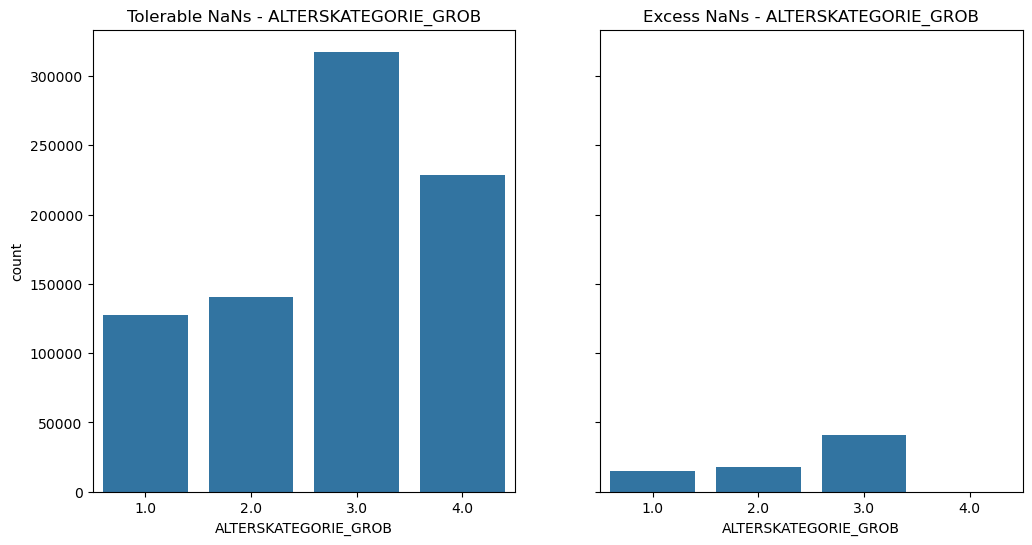

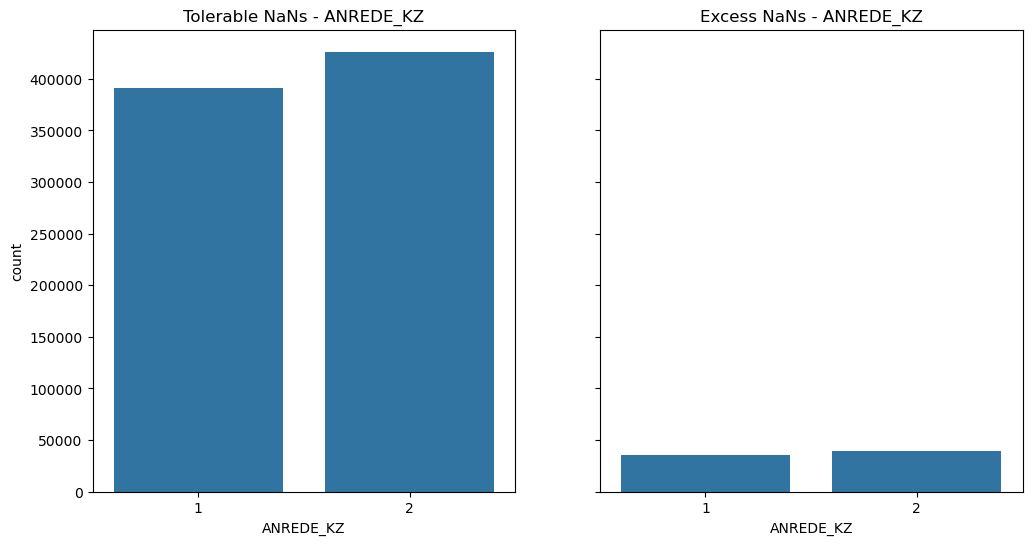

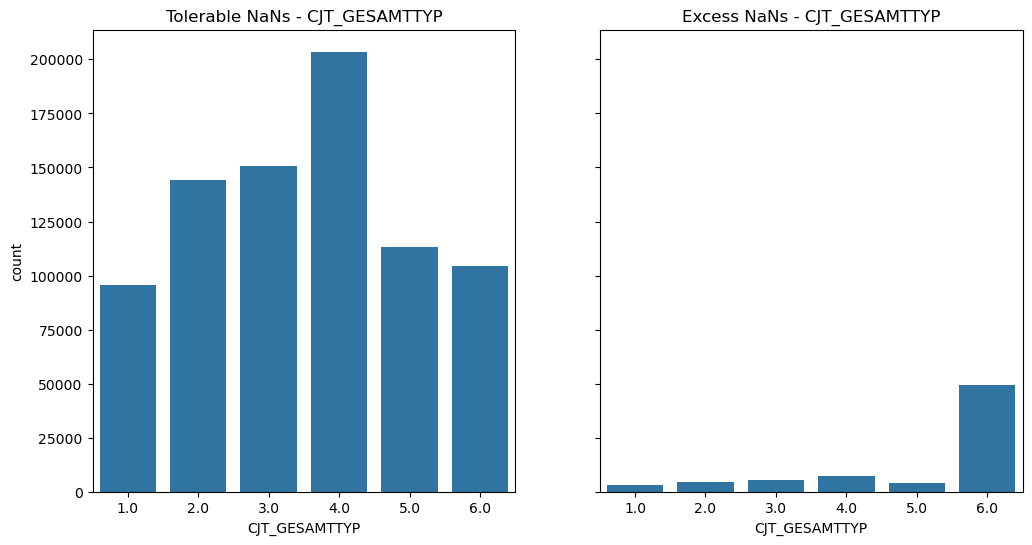

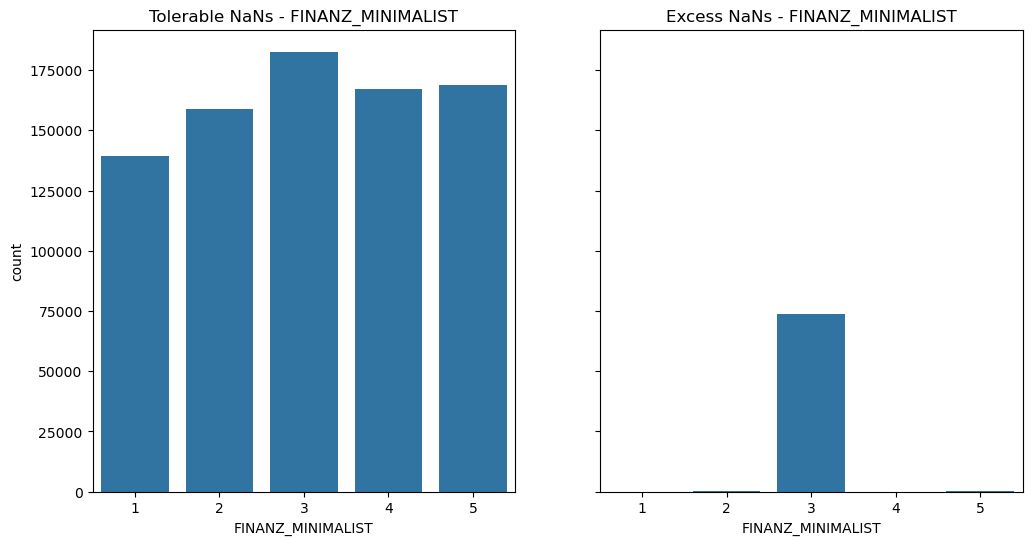

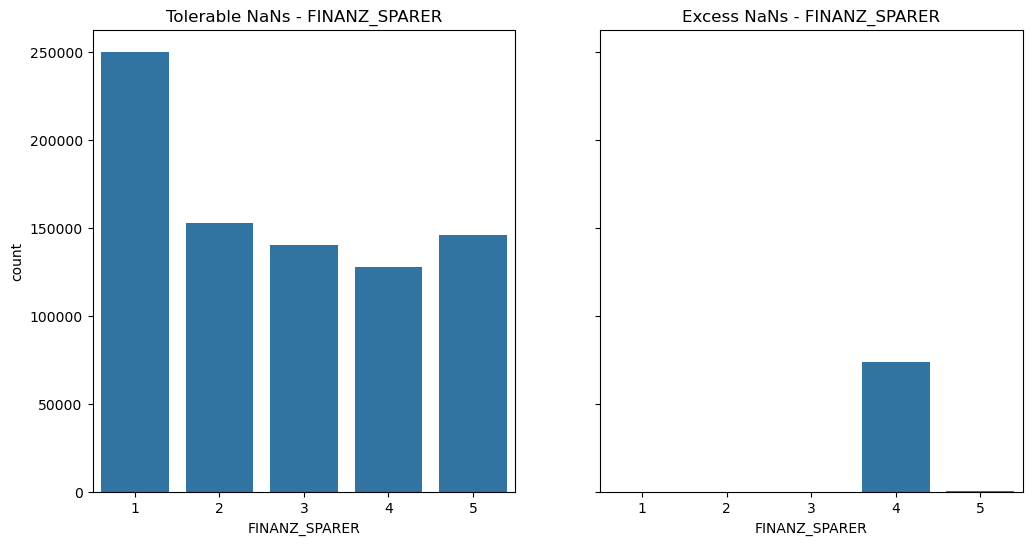

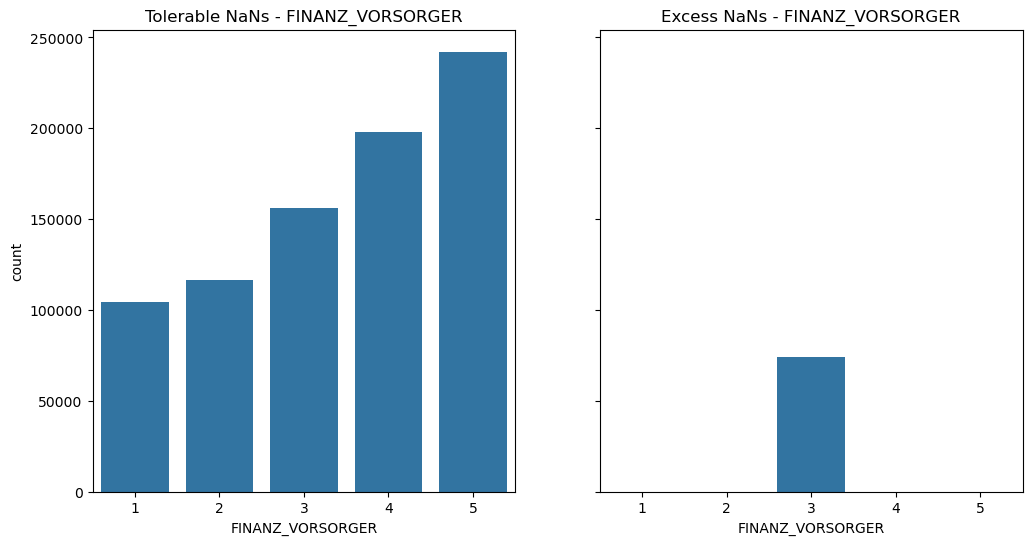

In [109]:
for col in columns_with_few_nans:
    plot_distribution(col)

* The difference between our tolerable nans and excess nans between these 5 columns with little empty values is very distinct.

In [111]:
pop.keys()

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH',
       'GEBAEUDETYP', 'KONSUMNAEHE', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_BAUMAX', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [114]:
# How many features are there of each data type?

feat_info['type'].value_counts()

type
ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: count, dtype: int64

• Leaving numeric, ordinal and interval data as they are, we are left to wrangle the: categorical and mixed data types

In [116]:
feat_info.query('type=="categorical" or type=="mixed"')     #finding the categorical columns

attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
10              FINANZTYP            person  categorical               [-1]
12        GFK_URLAUBERTYP            person  categorical                 []
13       GREEN_AVANTGARDE            person  categorical                 []
15    LP_LEBENSPHASE_FEIN            person        mixed                [0]
16    LP_LEBENSPHASE_GROB            person        mixed                [0]
17        LP_FAMILIE_FEIN            person  categorical                [0]
18        LP_FAMILIE_GROB            person  categorical                [0]
19         LP_STATUS_FEIN            person  categorical                [0]
20         LP_STATUS_GROB            person  categorical                [0]
21       NATIONALITAET_KZ            person  categorical             [-1,0]
22  PRAEGENDE_JUGENDJAHRE            person        mixed             [-1,0]
38            SHOPPER_TYP            person  categorical               [-1]
39                SOHO_KZ            person  categorical               [-1]
40               TITEL_KZ            person  categorical             [-1,0]
41               VERS_TYP            person  categorical               [-1]
42               ZABEOTYP            person  categorical             [-1,9]
47           KK_KUNDENTYP         household  categorical               [-1]
52            GEBAEUDETYP          building  categorical             [-1,0]
55            OST_WEST_KZ          building  categorical               [-1]
56               WOHNLAGE          building        mixed               [-1]
57        CAMEO_DEUG_2015     microcell_rr4  categorical             [-1,X]
58         CAMEO_DEU_2015     microcell_rr4  categorical               [XX]
59        CAMEO_INTL_2015     microcell_rr4        mixed            [-1,XX]
64           KBA05_BAUMAX     microcell_rr3        mixed             [-1,0]
79            PLZ8_BAUMAX    macrocell_plz8        mixed             [-1,0]

In [117]:
cat_dimensions = feat_info.query('type=="categorical" or type=="mixed"')['attribute']     #finding these categorical columns
cat_dimensions

0                  AGER_TYP
2                 ANREDE_KZ
3             CJT_GESAMTTYP
10                FINANZTYP
12          GFK_URLAUBERTYP
13         GREEN_AVANTGARDE
15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
17          LP_FAMILIE_FEIN
18          LP_FAMILIE_GROB
19           LP_STATUS_FEIN
20           LP_STATUS_GROB
21         NATIONALITAET_KZ
22    PRAEGENDE_JUGENDJAHRE
38              SHOPPER_TYP
39                  SOHO_KZ
40                 TITEL_KZ
41                 VERS_TYP
42                 ZABEOTYP
47             KK_KUNDENTYP
52              GEBAEUDETYP
55              OST_WEST_KZ
56                 WOHNLAGE
57          CAMEO_DEUG_2015
58           CAMEO_DEU_2015
59          CAMEO_INTL_2015
64             KBA05_BAUMAX
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [118]:
pop.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   
1       NaN                   1.0          2            5.0   
2       NaN                   3.0          2            3.0   
3       2.0                   4.0          2            2.0   
4       NaN                   3.0          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5                 3          4          NaN   
1                      4                 5          1       1996.0   
2                      3                 5          1       1979.0   
3                      1                 2          6       1957.0   
4                      3                 2          5       1963.0   

   GFK_URLAUBERTYP  HEALTH_TYP  LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  \
0             10.0         NaN                 15.0                  4.0   
1             10.0         3.0                 21.0                  6.0   
2             10.0         3.0                  3.0                  1.0   
3              1.0         2.0                  NaN                  NaN   
4              5.0         3.0                 32.0                 10.0   

   LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  LP_STATUS_GROB  \
0              2.0              2.0             1.0             1.0   
1              5.0              3.0             2.0             1.0   
2              1.0              1.0             3.0             2.0   
3              NaN              NaN             9.0             4.0   
4             10.0              5.0             3.0             2.0   

   PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  \
0                    NaN             5.0          2          6          7   
1                   14.0             1.0          5          4          4   
2                   15.0             3.0          4          1          3   
3                    8.0             2.0          5          1          2   
4                    8.0             5.0          6          4          4   

   SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  \
0          5           1           5          3           3          4   
1          3           1           2          2           3          6   
2          3           4           4          6           3          4   
3          1           4           4          7           4          3   
4          2           7           4          4           6          2   

   SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  \
0           7          6           6              5            3          NaN   
1           4          7           4              7            6          3.0   
2           7          7           7              3            3          2.0   
3           4          4           5              4            4          1.0   
4           3          2           2              4            2          2.0   

   VERS_TYP  ZABEOTYP  ALTER_HH  HH_EINKOMMEN_SCORE  KK_KUNDENTYP  \
0       NaN         3       NaN                 2.0           NaN   
1       2.0         5       NaN                 6.0           NaN   
2       1.0         5      17.0                 4.0           NaN   
3       1.0         3      13.0                 1.0           NaN   
4       2.0         4      20.0                 5.0           1.0   

   W_KEIT_KIND_HH  GEBAEUDETYP  KONSUMNAEHE  WOHNLAGE  CAMEO_DEUG_2015

In [119]:
pop['AGER_TYP'].value_counts().reset_index().iloc[:,0].values

array([2., 1., 3.])

In [120]:
for col in cat_dimensions:
    try: 
        counte = pop[col].value_counts().reset_index().iloc[:,0].values
        print(f'{col} has: {counte}')
    except KeyError:
        continue

AGER_TYP has: [2. 1. 3.]
ANREDE_KZ has: [2 1]
CJT_GESAMTTYP has: [4. 3. 6. 2. 5. 1.]
FINANZTYP has: [6 1 4 2 5 3]
GFK_URLAUBERTYP has: [12.  5. 10.  8. 11.  4.  9.  3.  1.  2.  7.  6.]
LP_LEBENSPHASE_FEIN has: [ 1.  5.  6.  2.  8. 11. 29.  7. 13. 10. 31. 12. 30. 15.  3. 19. 37.  4.
 14. 20. 32. 39. 40. 27. 16. 38. 35. 34.  9. 21. 28. 24. 36. 25. 23. 22.
 18. 33. 17. 26.]
LP_LEBENSPHASE_GROB has: [ 2.  1.  3. 12.  4.  5.  9. 10. 11.  8.  6.  7.]
LP_FAMILIE_FEIN has: [ 1. 10.  2. 11.  8.  7.  4.  5.  9.  6.  3.]
LP_FAMILIE_GROB has: [1. 5. 2. 4. 3.]
LP_STATUS_FEIN has: [ 1.  9.  2. 10.  4.  5.  3.  6.  8.  7.]
LP_STATUS_GROB has: [1. 2. 4. 5. 3.]
PRAEGENDE_JUGENDJAHRE has: [14.  8.  5. 10.  3. 15. 11.  9.  6. 12.  1.  4.  2. 13.  7.]
SHOPPER_TYP has: [1. 2. 3. 0.]
VERS_TYP has: [2. 1.]
ZABEOTYP has: [3 4 1 5 6 2]
KK_KUNDENTYP has: [3. 2. 5. 4. 6. 1.]
GEBAEUDETYP has: [1. 3. 8. 2. 4. 6. 5.]
WOHNLAGE has: [3. 7. 4. 2. 5. 1. 8. 0.]
CAMEO_DEUG_2015 has: [8. 9. 6. 4. 3. 2. 7. 5. 1.]
CAMEO_INT

In [121]:
multi_col = []
for col in cat_dimensions:
    column_data = pop.get(col)
    if column_data is not None:
        counte = column_data.value_counts().reset_index().iloc[:, 0].values
        print(f'{col} has: {counte} values')
        if len(counte) > 2:
            multi_col.append(col)

AGER_TYP has: [2. 1. 3.] values
ANREDE_KZ has: [2 1] values
CJT_GESAMTTYP has: [4. 3. 6. 2. 5. 1.] values
FINANZTYP has: [6 1 4 2 5 3] values
GFK_URLAUBERTYP has: [12.  5. 10.  8. 11.  4.  9.  3.  1.  2.  7.  6.] values
LP_LEBENSPHASE_FEIN has: [ 1.  5.  6.  2.  8. 11. 29.  7. 13. 10. 31. 12. 30. 15.  3. 19. 37.  4.
 14. 20. 32. 39. 40. 27. 16. 38. 35. 34.  9. 21. 28. 24. 36. 25. 23. 22.
 18. 33. 17. 26.] values
LP_LEBENSPHASE_GROB has: [ 2.  1.  3. 12.  4.  5.  9. 10. 11.  8.  6.  7.] values
LP_FAMILIE_FEIN has: [ 1. 10.  2. 11.  8.  7.  4.  5.  9.  6.  3.] values
LP_FAMILIE_GROB has: [1. 5. 2. 4. 3.] values
LP_STATUS_FEIN has: [ 1.  9.  2. 10.  4.  5.  3.  6.  8.  7.] values
LP_STATUS_GROB has: [1. 2. 4. 5. 3.] values
PRAEGENDE_JUGENDJAHRE has: [14.  8.  5. 10.  3. 15. 11.  9.  6. 12.  1.  4.  2. 13.  7.] values
SHOPPER_TYP has: [1. 2. 3. 0.] values
VERS_TYP has: [2. 1.] values
ZABEOTYP has: [3 4 1 5 6 2] values
KK_KUNDENTYP has: [3. 2. 5. 4. 6. 1.] values
GEBAEUDETYP has: [1. 3. 8. 

In [122]:
print(multi_col)

['AGER_TYP', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'PRAEGENDE_JUGENDJAHRE', 'SHOPPER_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.(We already did this earlier)
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

* Basically, columns in the to_dummy list are the ones that have more than 2 unique values, and are still categorical

Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?

In [125]:
valid_columns = [col for col in multi_col if col in pop.columns]      # Subset the DataFrame to only columns present in the multi_col list

In [126]:
#both needed for later encoding

valid_columns.remove('CAMEO_INTL_2015')
valid_columns.remove('PRAEGENDE_JUGENDJAHRE')

In [127]:
print(valid_columns)

['AGER_TYP', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'SHOPPER_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']


In [128]:
pop = pop.drop(columns=valid_columns)

In [129]:
# Re-encode categorical variable(s) to be kept in the analysis.



#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

In [131]:
feat_info.query('type=="mixed"')['attribute'].to_list()

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Reading `Data_Dictionary.md`, we can understand the steps described above

In [133]:
pop['CAMEO_INTL_2015'].value_counts().reset_index().sort_values(by='CAMEO_INTL_2015')

CAMEO_INTL_2015   count
17             12.0   13249
9              13.0   26336
3              14.0   62884
15             15.0   16974
7              22.0   33155
8              23.0   26750
2              24.0   91158
6              25.0   39628
13             31.0   19024
19             32.0   10354
20             33.0    9935
14             34.0   18524
18             35.0   10356
1              41.0   92336
4              43.0   56672
16             44.0   14820
10             45.0   26132
0              51.0  133694
12             52.0   20542
5              54.0   45391
11             55.0   23955

##### CAMEO_INTL_2015 DECODING

German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


In [135]:
wealth = []
life_stage = []

for i in pop['CAMEO_INTL_2015'].astype(float):
    if i//10==1.0:
        wealth.append(0)    #wealthy households
    elif i//10==2.0:
        wealth.append(1)    #prosperous households
    elif i//10==3.0:
        wealth.append(2)    #comfortable households
    elif i//10==4.0:
        wealth.append(3)    #less affluent households
    else:
        wealth.append(4)    #poorer households

    if i%10==1.0:
        life_stage.append(0)      #pre-family couple
    elif i%10==2.0:
        life_stage.append(1)      #young couple
    elif i%10==3.0:
        life_stage.append(2)      #family with school age
    elif i%10==4.0:
        life_stage.append(3)      #mature couples
    else:
        life_stage.append(4)      #elder in retirement


pop['wealth'] = wealth      #encoding wealth with floor division
pop['life_stage'] = life_stage      #encoding wealth with reminder

In [136]:
pop.keys()

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GEBURTSJAHR',
       'HEALTH_TYP', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
       'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
       'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM',
       'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'VERS_TYP', 'ALTER_HH',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'KONSUMNAEHE',
       'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER',
       'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ',
       'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB', 'wealth', 'life_stage'],
      dtype='object')

In [137]:
pop.columns.to_list()[:5]

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER']

##### PRAEGENDE_JUGENDJAHRE DECODING

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [139]:
pop['PRAEGENDE_JUGENDJAHRE'].value_counts().reset_index().sort_values(by='PRAEGENDE_JUGENDJAHRE')

PRAEGENDE_JUGENDJAHRE   count
10                    1.0   21282
12                    2.0    7479
4                     3.0   55195
11                    4.0   20451
2                     5.0   86416
8                     6.0   25652
14                    7.0    4010
1                     8.0  145988
7                     9.0   33570
3                    10.0   85808
6                    11.0   35752
9                    12.0   24446
13                   13.0    5764
0                    14.0  188697
5                    15.0   42547

In [140]:
#generation by decade, movement (mainstream vs. avantgarde)

generation = []
movement = []

for i in pop['PRAEGENDE_JUGENDJAHRE'].astype(float):
    if i == 1 or i == 2:
        generation.append(0)         #40s 
    elif i == 3 or i == 4:
        generation.append(1)         #50s 
    elif i == 5 or i == 6 or i == 7:
        generation.append(2)         #60s 
    elif i == 8 or i == 9:
        generation.append(3)         #90s 
    elif i == 14 or i == 15:
        generation.append(4)         #80s 
    else:
        generation.append(5)

    if i == 1 or i == 3 or i == 5 or i == 8 or i == 10 or i == 12 or i == 14:
        movement.append(0)      #mainstream movement
    else:
        movement.append(1)       #avantgarde movement

pop['generation']=generation      #encoding generation
pop['movement']=movement      #encoding movement type

In [141]:
mixed_cols = feat_info.query('type=="mixed"')['attribute'].to_list()
mixed_cols

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

In [142]:
mixed_to_drop = []

for col in mixed_cols:
    if (col != 'PRAEGENDE_JUGENDJAHRE') and (col != 'CAMEO_INTL_2015'):
        mixed_to_drop.append(col)

mixed_to_drop

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'WOHNLAGE',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

In [143]:
for col in mixed_to_drop:
    try:
        pop = pop.drop(columns=col)
    except KeyError:
        continue

In [144]:
pop.keys()

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GEBURTSJAHR',
       'HEALTH_TYP', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
       'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
       'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM',
       'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'VERS_TYP', 'ALTER_HH',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'KONSUMNAEHE',
       'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER',
       'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ',
       'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB', 'wealth', 'life_stage',
       'generation', 'movement'],
      dtype='object')

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)
* I investigated "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" to engineer two new variables each.
* The other dimensions, I decided tto drop them 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [147]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

pop.keys()

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GEBURTSJAHR',
       'HEALTH_TYP', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
       'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
       'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM',
       'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'VERS_TYP', 'ALTER_HH',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'KONSUMNAEHE',
       'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER',
       'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ',
       'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB', 'wealth', 'life_stage',
       'generation', 'movement'],
      dtype='object')

In [148]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [398]:
def clean_data(df:pd.DataFrame) -> pd.DataFrame:
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Put in code here to execute all main cleaning steps:
    for x in range(len(feat_info)):
    # using regex to extract the digits
        missing_data = re.sub('[\[|\]]', '',feat_info.iloc[x]['missing_or_unknown']).split(',')
        # return the digit values for integer strings only
        if missing_data != ['']:
            missing_data = [np.int64(data) if (data!='X' and data!='XX') else data for data in missing_data]
            df = df.replace({feat_info.iloc[x]['attribute']: missing_data}, np.nan)

    df['CAMEO_INTL_2015'] = pd.to_numeric(df['CAMEO_INTL_2015'], downcast='integer')    
    df['CAMEO_DEUG_2015'] = pd.to_numeric(df['CAMEO_DEUG_2015'], downcast='integer')
    
    df = df.drop(columns=['TITEL_KZ', 'CAMEO_DEU_2015'])
    
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'W':0, 'O':1})
    
    df_outliers = identify_outlier_columns(df)
    df = df.drop(columns=df_outliers)
    # select, re-encode, and engineer column values.
    multi_col = []
    for col in cat_dimensions:
        column_data = df.get(col)
        if column_data is not None:
            counte = column_data.value_counts().reset_index().iloc[:, 0].values
            #print(f'{col} has: {counte} values')
            if len(counte) > 2:
                multi_col.append(col)
    valid_columns = [col for col in multi_col if col in df.columns] 
    valid_columns.remove('CAMEO_INTL_2015')
    valid_columns.remove('PRAEGENDE_JUGENDJAHRE')
    df = df.drop(columns=valid_columns)
    
    wealth = []
    life_stage = []
    for i in df['CAMEO_INTL_2015'].astype(float):
        if i//10==1.0:
            wealth.append(0)    #wealthy households
        elif i//10==2.0:
            wealth.append(1)    #prosperous households
        elif i//10==3.0:
            wealth.append(2)    #comfortable households
        elif i//10==4.0:
            wealth.append(3)    #less affluent households
        else:
            wealth.append(4)    #poorer households
        if i%10==1.0:
            life_stage.append(0)      #pre-family couple
        elif i%10==2.0:
            life_stage.append(1)      #young couple
        elif i%10==3.0:
            life_stage.append(2)      #family with school age
        elif i%10==4.0:
            life_stage.append(3)      #mature couples
        else:
            life_stage.append(4)      #elder in retirement
    df['wealth'] = wealth      #encoding wealth with floor division
    df['life_stage'] = life_stage      #encoding wealth with reminder

    
    generation = []
    movement = []
    for i in df['PRAEGENDE_JUGENDJAHRE'].astype(float):
        if i == 1 or i == 2:
            generation.append(0)         #40s 
        elif i == 3 or i == 4:
            generation.append(1)         #50s 
        elif i == 5 or i == 6 or i == 7:
            generation.append(2)         #60s 
        elif i == 8 or i == 9:
            generation.append(3)         #90s 
        elif i == 14 or i == 15:
            generation.append(4)         #80s 
        else:
            generation.append(5)
    
        if i == 1 or i == 3 or i == 5 or i == 8 or i == 10 or i == 12 or i == 14:
            movement.append(0)      #mainstream movement
        else:
            movement.append(1)       #avantgarde movement 
    df['generation']=generation      #encoding generation
    df['movement']=movement      #encoding movement type

    mixed_to_drop = []
    for col in mixed_cols:
        if (col != 'PRAEGENDE_JUGENDJAHRE') and (col != 'CAMEO_INTL_2015'):
            mixed_to_drop.append(col)
    for col in mixed_to_drop:
        try:
            df = df.drop(columns=col)
        except KeyError:
            continue

    df_columns = df.keys().to_list()
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    df = imp_median.fit_transform(df)
    df = pd.DataFrame(df, columns=df_columns)
    return df # Return the cleaned dataframe.
    
    

In [400]:
df = clean_data(pop)

/var/folders/y1/2cln1s193dgc6xy3yzry761r0000gn/T/ipykernel_25560/4198929136.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'W':0, 'O':1})


In [402]:
df.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                   2.0        1.0                3.0            4.0   
1                   1.0        2.0                1.0            5.0   
2                   3.0        2.0                1.0            4.0   
3                   4.0        2.0                4.0            2.0   
4                   3.0        1.0                4.0            3.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0               3.0             5.0                    5.0               3.0   
1               2.0             5.0                    4.0               5.0   
2               1.0             2.0                    3.0               5.0   
3               5.0             2.0                    1.0               2.0   
4               4.0             1.0                    3.0               2.0   

   GEBURTSJAHR  HEALTH_TYP  PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  SEMIO_SOZ  \
0       1968.0         2.0                    9.0             5.0        2.0   
1       1996.0         3.0                   14.0             1.0        5.0   
2       1979.0         3.0                   15.0             3.0        4.0   
3       1957.0         2.0                    8.0             2.0        5.0   
4       1963.0         3.0                    8.0             5.0        6.0   

   SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  \
0        6.0        7.0        5.0         1.0         5.0        3.0   
1        4.0        4.0        3.0         1.0         2.0        2.0   
2        1.0        3.0        3.0         4.0         4.0        6.0   
3        1.0        2.0        1.0         4.0         4.0        7.0   
4        4.0        4.0        2.0         7.0         4.0        4.0   

   SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  \
0         3.0        4.0         7.0        6.0         6.0            5.0   
1         3.0        6.0         4.0        7.0         4.0            7.0   
2         3.0        4.0         7.0        7.0         7.0            3.0   
3         4.0        3.0         4.0        4.0         5.0            4.0   
4         6.0        2.0         3.0        2.0         2.0            4.0   

   SEMIO_TRADV  VERS_TYP  ALTER_HH  HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  \
0          3.0       2.0      16.0                 2.0             4.0   
1          6.0       2.0      16.0                 6.0             3.0   
2          3.0       1.0      17.0                 4.0             3.0   
3          4.0       1.0      13.0                 1.0             4.0   
4          2.0       2.0      20.0                 5.0             2.0   

   KONSUMNAEHE  CAMEO_INTL_2015  KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  \
0          3.0             41.0          1.0          1.0          0.0   
1          1.0             51.0          0.0          0.0          0.0   
2          5.0             24.0          1.0          3.0          1.0   
3          4.0             12.0          4.0          1.0          0.0   
4          4.0             43.0          1.0          4.0          1.0   

   KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  GEBAEUDETYP_RASTER  KKK  \
0        3.0       5.0       4.0         5.0                 4.0  3.0   
1        1.0       6.0       3.0         8.0                 3.0  2.0   
2        3.0       2.0       4.0         4.0                 4.0  2.0   
3        4.0       4.0       2.0         6.0                 4.0  3.0   
4        3.0       2.0       5.0         1.0                 5.0  3.0   

   MOBI_REGIO  ONLINE_AFFINITAET  REGIOTYP  PLZ8_ANTG1  PLZ8_ANTG2  \
0         3.0                1.0       5.0         2.0         3.0   
1         1.0                3.0       3.0         2.0         3.0   
2         3.0                2.0       2.0         3.0         3.0   
3         4.0                1.0       5.0         2.0         2.0   
4         3.0        

In [404]:
df.shape

(891221, 57)

In [406]:
df.isna().sum()     #totally clean with no nans

ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
GEBURTSJAHR              0
HEALTH_TYP               0
PRAEGENDE_JUGENDJAHRE    0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
VERS_TYP                 0
ALTER_HH                 0
HH_EINKOMMEN_SCORE       0
W_KEIT_KIND_HH           0
KONSUMNAEHE              0
CAMEO_INTL_2015          0
KBA05_ANTG1              0
KBA05_ANTG2              0
KBA05_ANTG3              0
KBA05_GBZ                0
BALLRAUM                 0
E

In [408]:
customer = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=";")

In [410]:
customer.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0         2                     4          1            5.0   
1        -1                     4          1            NaN   
2        -1                     4          2            2.0   
3         1                     4          1            2.0   
4        -1                     3          1            6.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  5              1                 5               1   
1                  5              1                 5               1   
2                  5              1                 5               1   
3                  5              1                 5               2   
4                  3              1                 4               4   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      2                 2          2            0   
1                      3                 2          2            0   
2                      4                 4          2            0   
3                      1                 2          6            0   
4                      5                 2          2         1960   

   GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
0              4.0                 1           1                 20.0   
1              NaN                 0           1                  NaN   
2              3.0                 1           2                 13.0   
3             10.0                 0           2                  0.0   
4              2.0                 0           3                 31.0   

   LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
0                  5.0              2.0              2.0            10.0   
1                  NaN              NaN              NaN             NaN   
2                  3.0              1.0              1.0            10.0   
3                  0.0              0.0              0.0             9.0   
4                 10.0             10.0              5.0             1.0   

   LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  \
0             5.0                 1                      4             5.0   
1             NaN                 1                      0             NaN   
2             5.0                 1                      4             5.0   
3             4.0                 1                      1             3.0   
4             1.0                 1                      8             5.0   

   SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  \
0          6          5          2          6           6           7   
1          3          6          2          6           7           5   
2          2          2          1          3           3           7   
3          6          5          3          4           7           5   
4          4          5          4          6           5           6   

   SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  \
0          3           4          1           3          1           1   
1          3           4          1           3          3           2   
2          7           1          2           7          5           6   
3          3           4          3           3          3           3   
4          4           5          5           3          5           2   

   SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  TITEL_KZ  VERS_TYP  \
0              2            1            3      0.0       0.0         1   
1              4            1            3      0.0       0.0         1   
2              4            1            1      0.0       0.0         2   
3              3            4            0      0.0       0.0         1   
4              5            4            1      0.0       0.0         2   

   ZABEOTYP  ALTER_HH  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCO

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [413]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.


In [415]:
scaler = StandardScaler()

In [417]:
# Apply feature scaling to the general population demographics data.
scaled_data = scaler.fit_transform(df)

In [419]:
scaled_data

array([[-0.75167967, -1.045218  , -0.05641562, ...,  1.21814982,
         1.10233491,  1.46453679],
       [-1.74333933,  0.95673821, -1.57035806, ..., -1.36014202,
         0.39299478, -0.68280975],
       [ 0.23997999,  0.95673821, -1.57035806, ...,  0.57357686,
         0.39299478,  1.46453679],
       ...,
       [-0.75167967,  0.95673821, -0.81338684, ...,  0.57357686,
         0.39299478, -0.68280975],
       [-1.74333933, -1.045218  , -1.57035806, ..., -1.36014202,
         0.39299478, -0.68280975],
       [ 1.23163965, -1.045218  ,  0.7005556 , ..., -0.0709961 ,
        -1.7350256 , -0.68280975]])

In [421]:
type(scaled_data)

numpy.ndarray

### Discussion 2.1: Apply Feature Scaling

Scaled data is a list as expected. Now we can move on

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [425]:
# Apply PCA to the data.



In [427]:
def apply_pca(x:str=None, df:pd.DataFrame=scaled_data):
    """
    INPUT:
    x: str denoting number of components to be broken down into
    df: scaled dataframe to find principal components
    OUTPUT:
    df_pca: (np.array) denoting result
    pca: object denoting PCA's instantiation
    """
    pca = PCA(n_components=x)
    df_pca = pca.fit_transform(df)
    return pca, df_pca

In [529]:
pca, df_pca = apply_pca()

In [533]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 11))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance-Explained Ratio")
    plt.title('Explained Variance Per Principal Component')
    

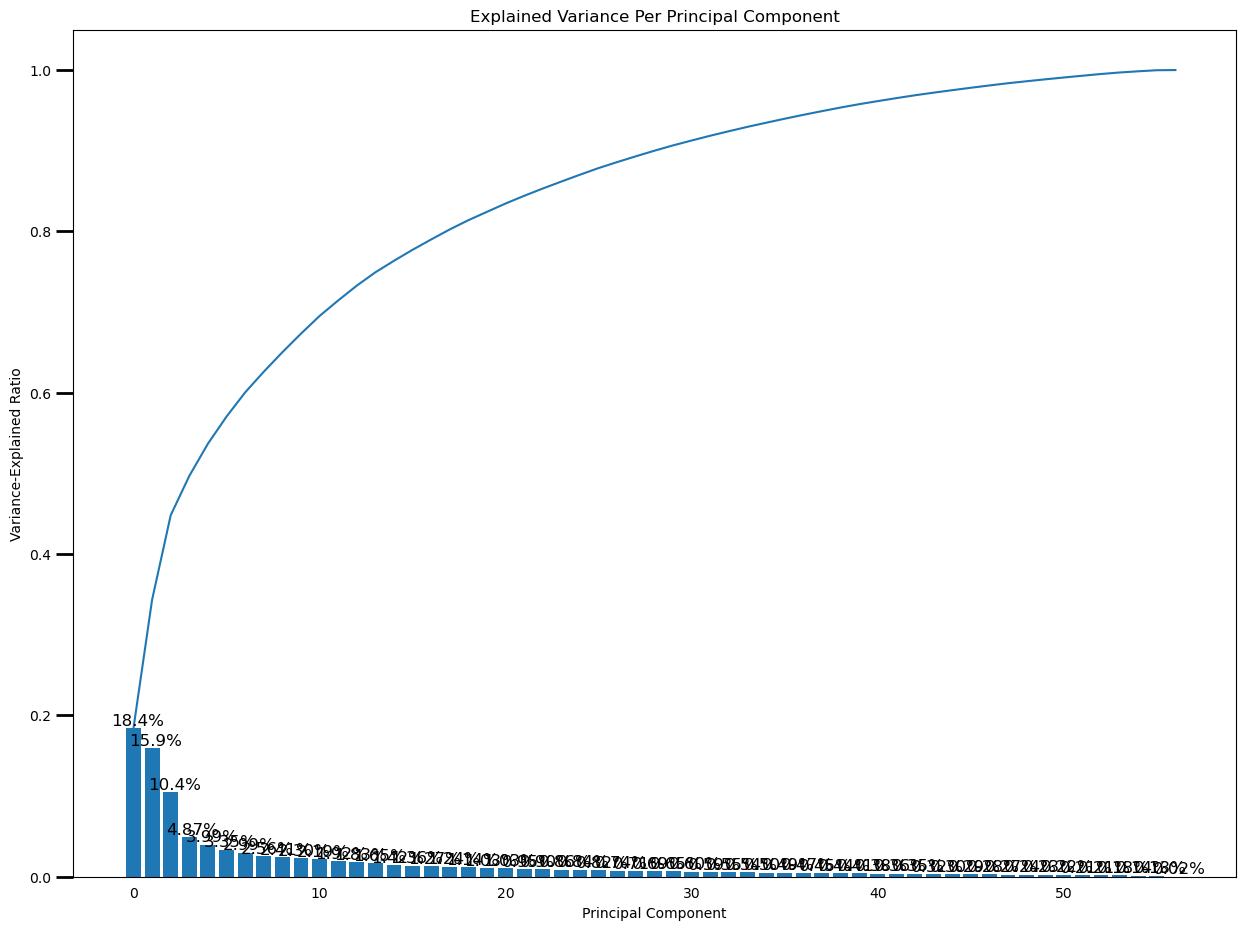

In [535]:
scree_plot(pca)

In [467]:
def pca_results(full_dataset:pd.DataFrame, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (15,10))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)


In [469]:
def pca_computer(x:int=None, df:pd.DataFrame=df):
    """
    COmbination of the apply_pca and pca_result functions
    INPUT: 
    x(str): Number of principal components to split df into
    df(pd.DataFrame): Dataframe do compute pca on

    OUTPUT: 
    zing: Nonetype denoting pca component analysis
    """
    pca, df_pca = apply_pca()
    zing = pca_results(df, pca)
    return zing

Using 17 components, we can explain 0.9505999999999999% of the variability in the original data.


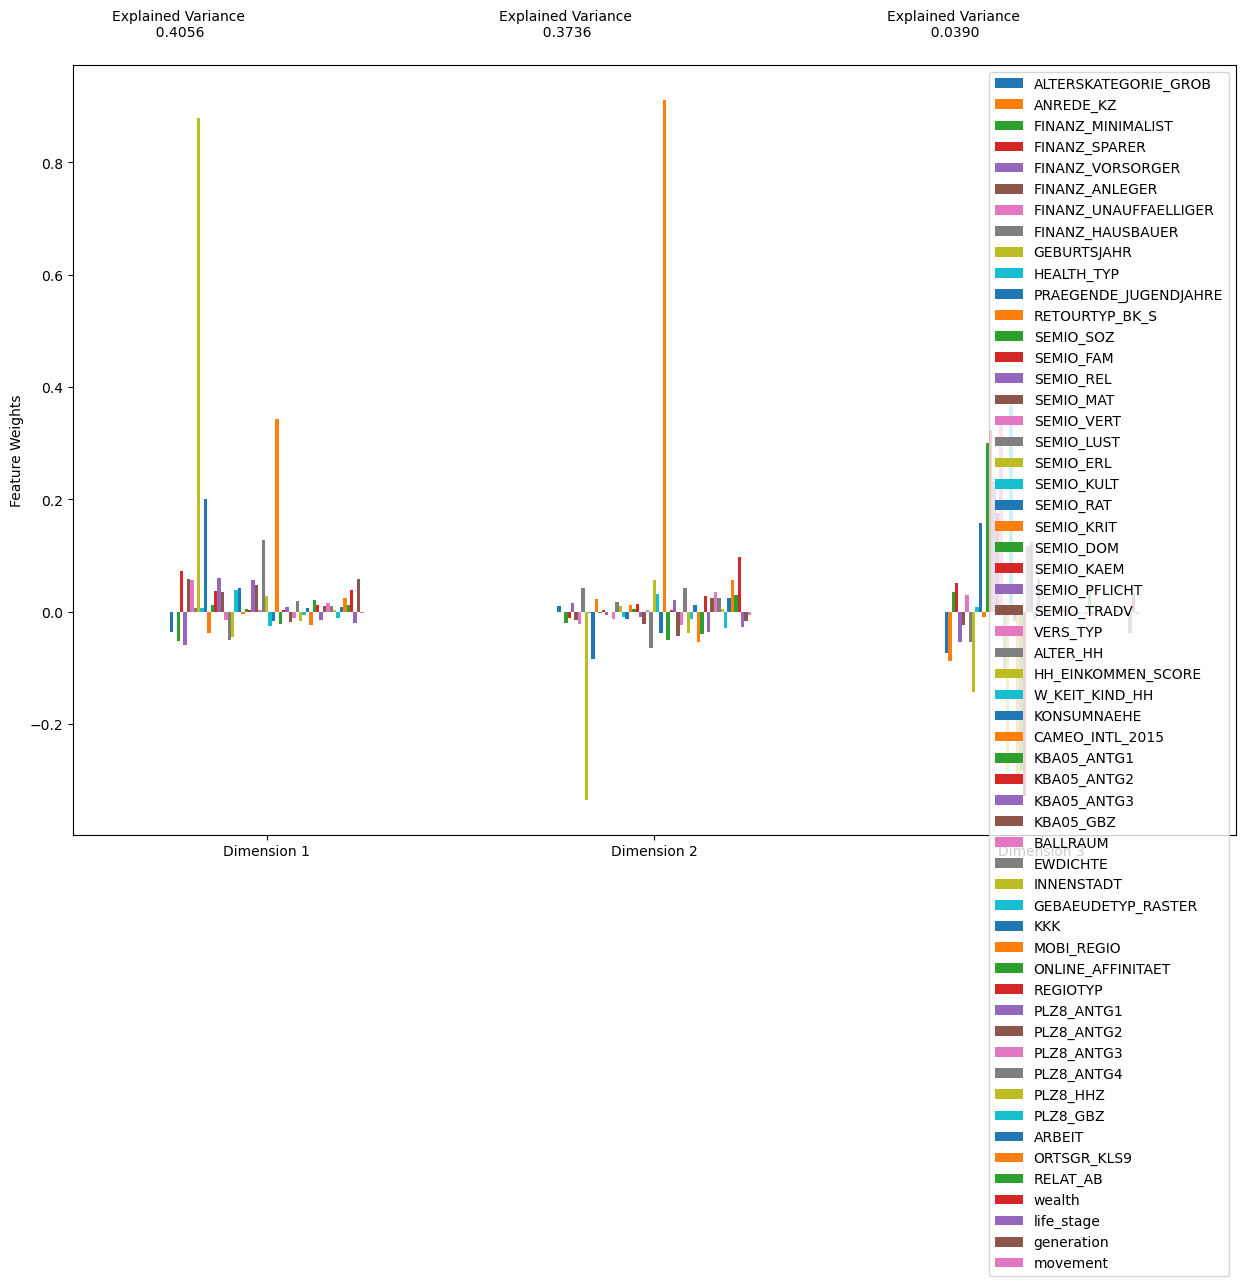

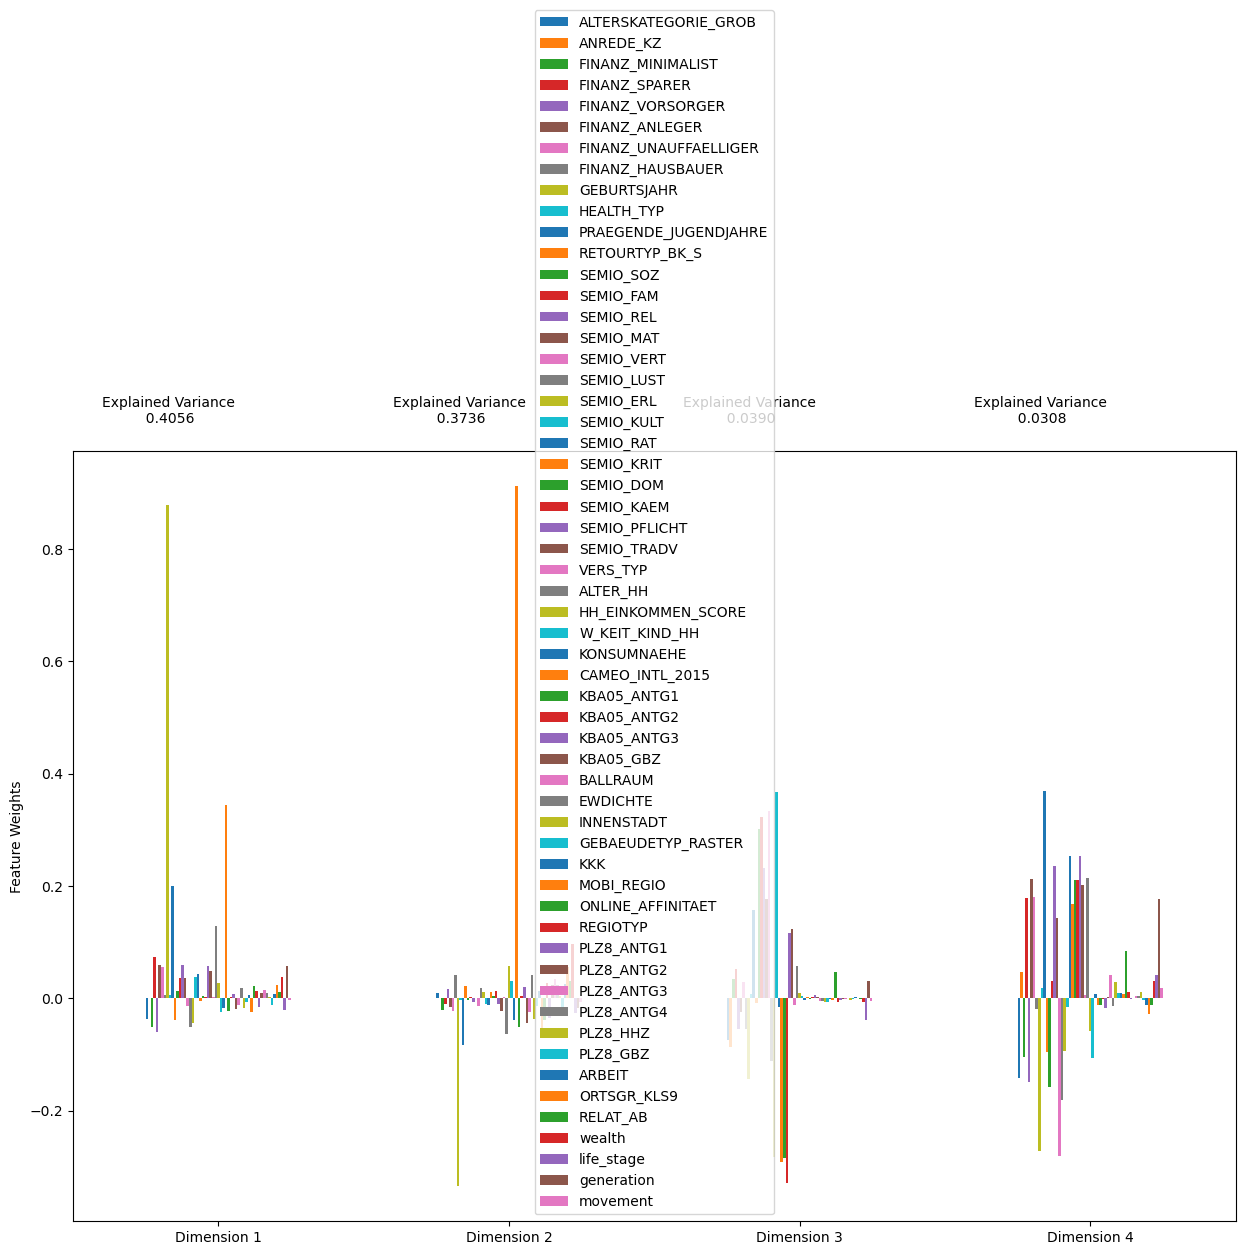

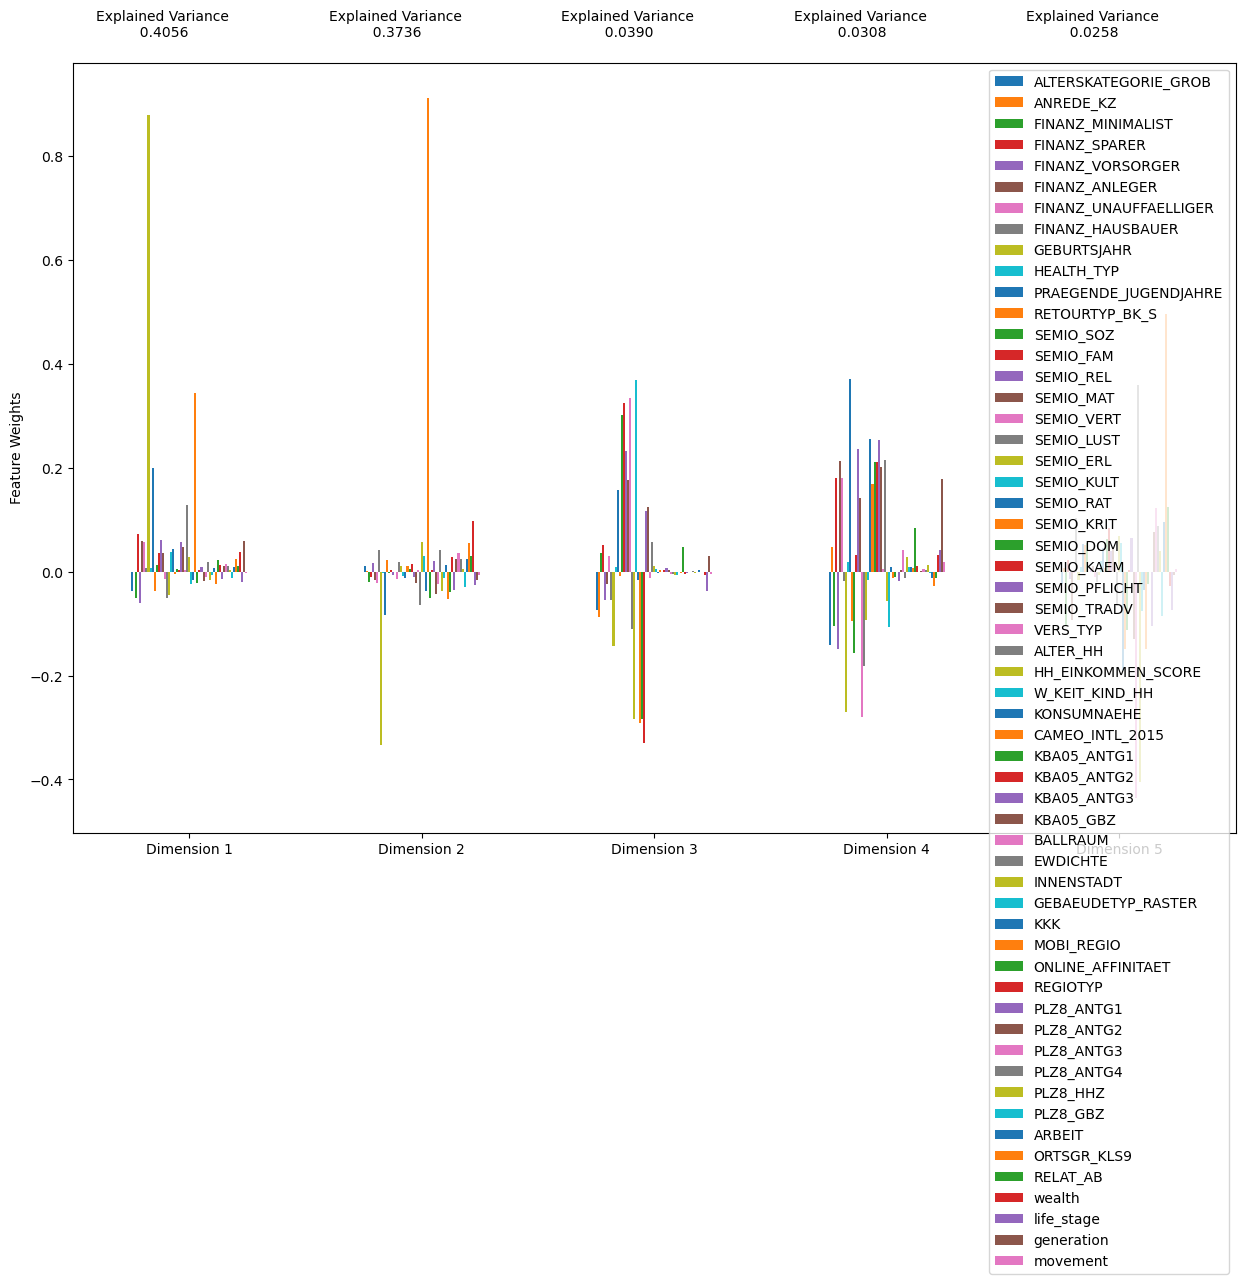

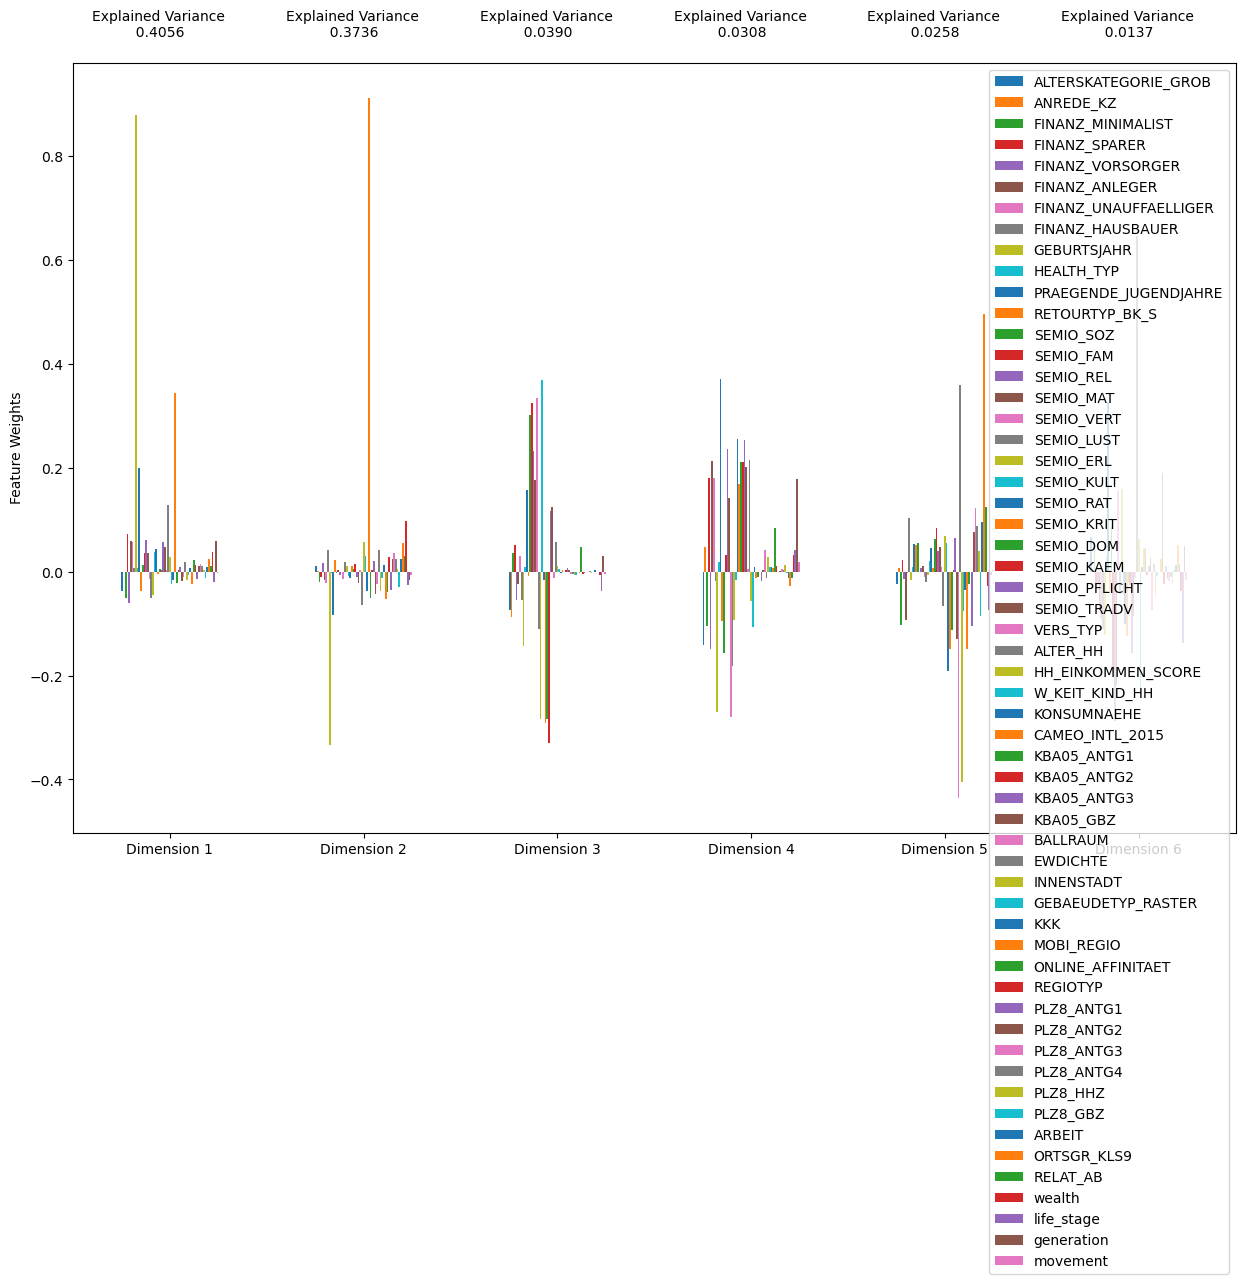

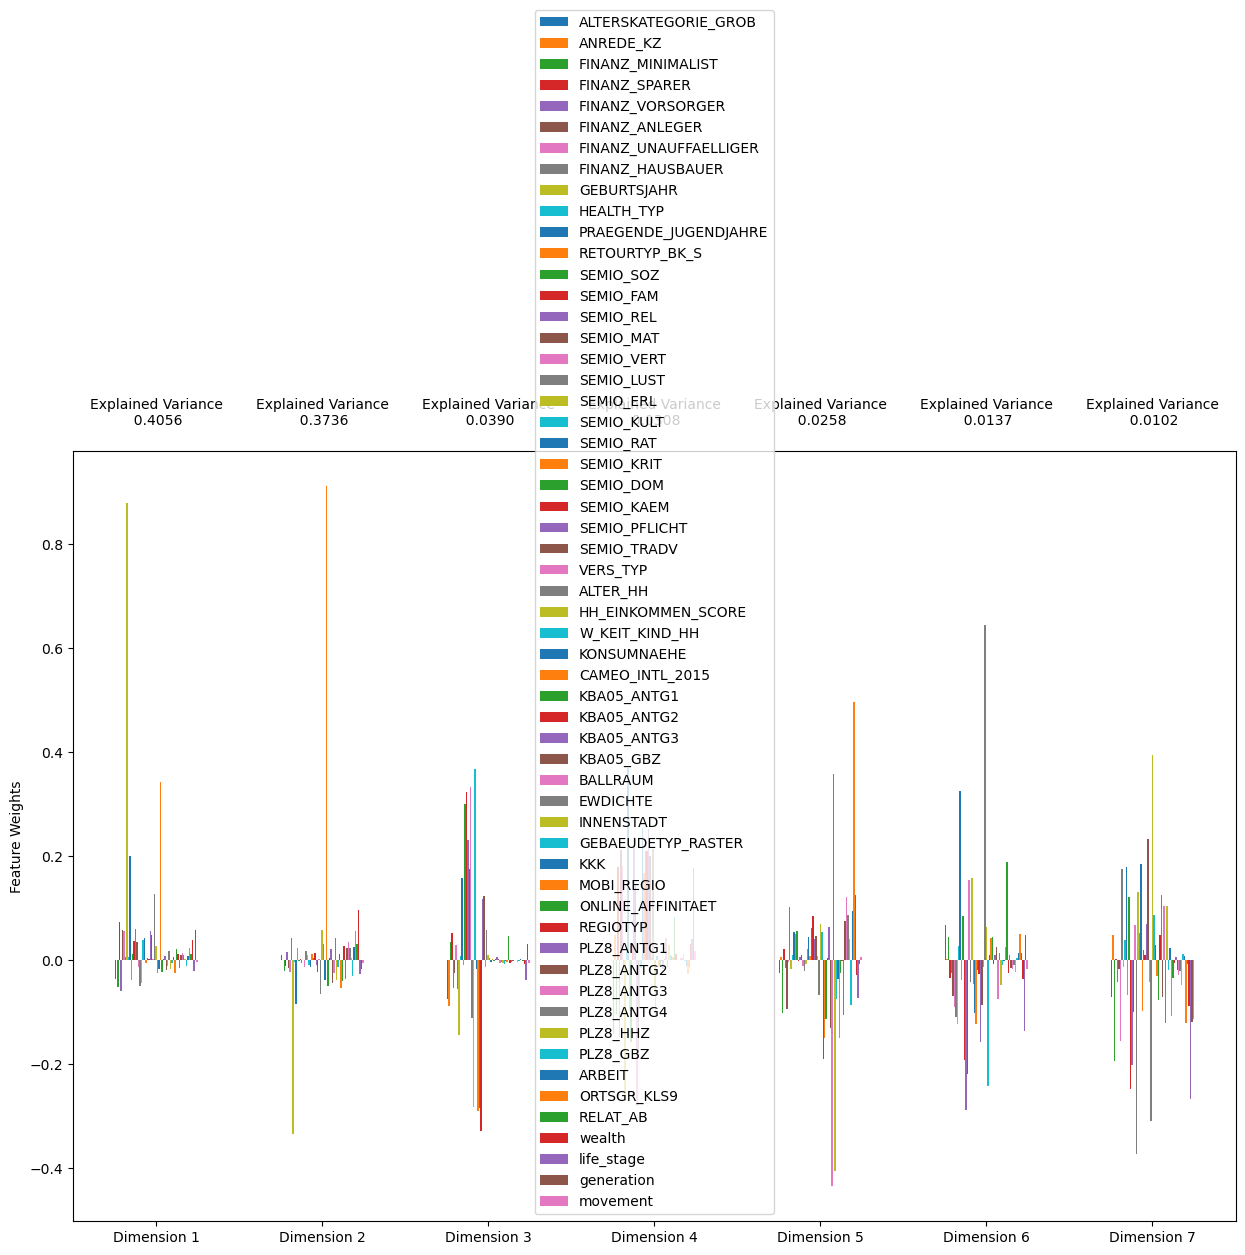

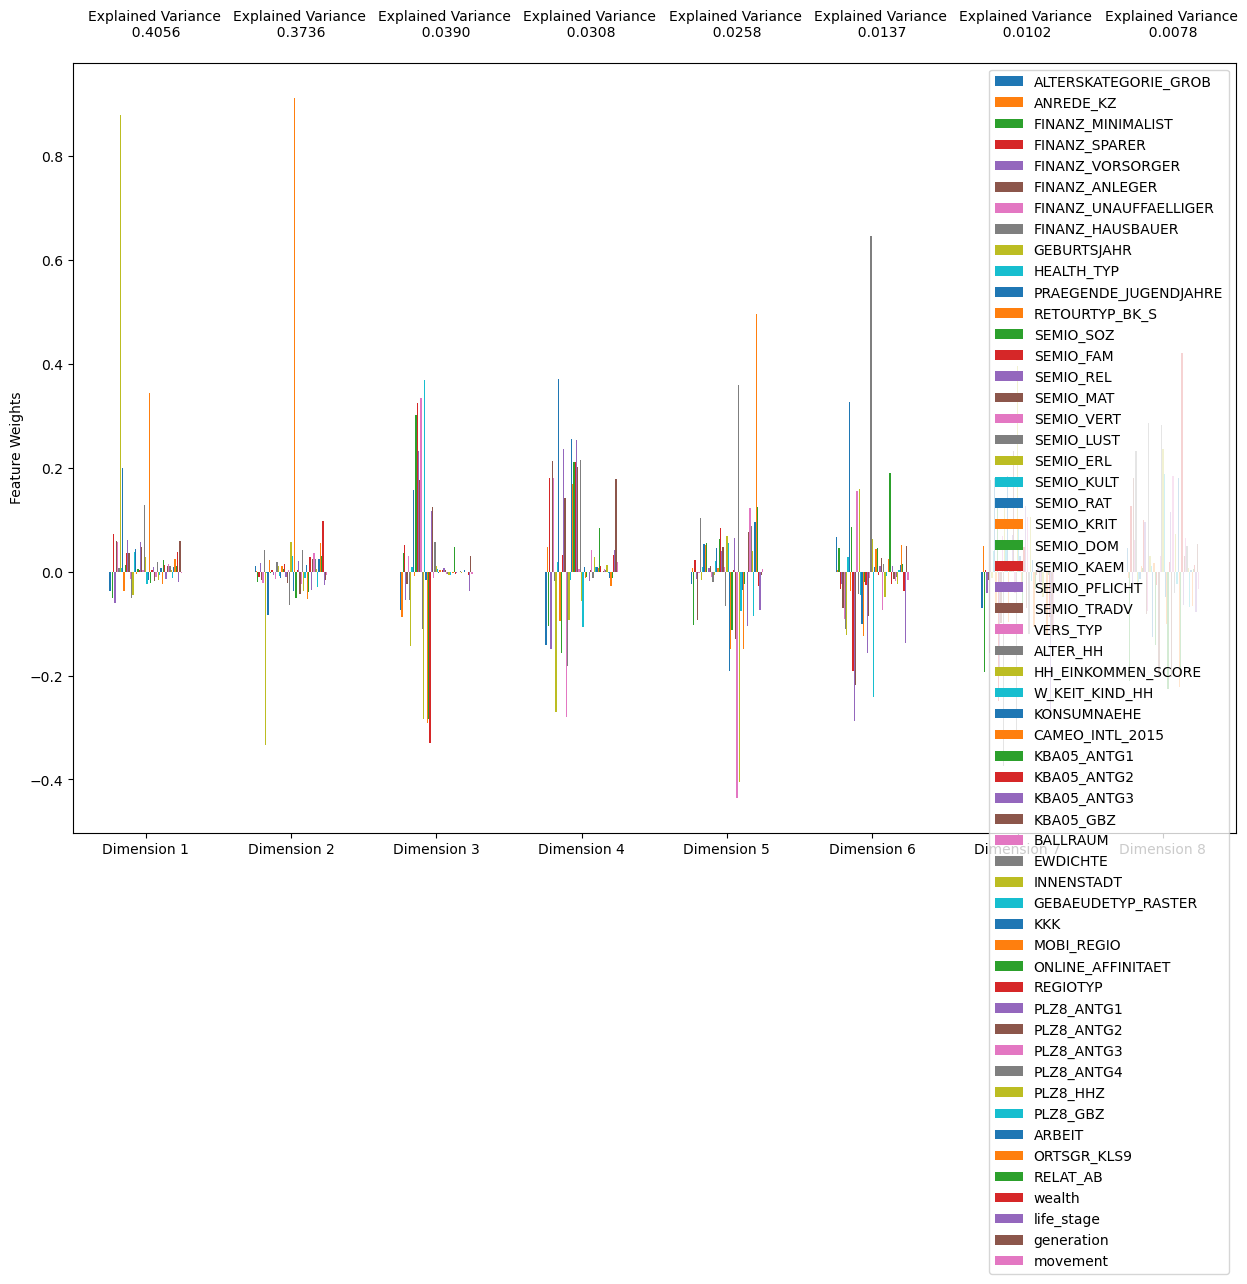

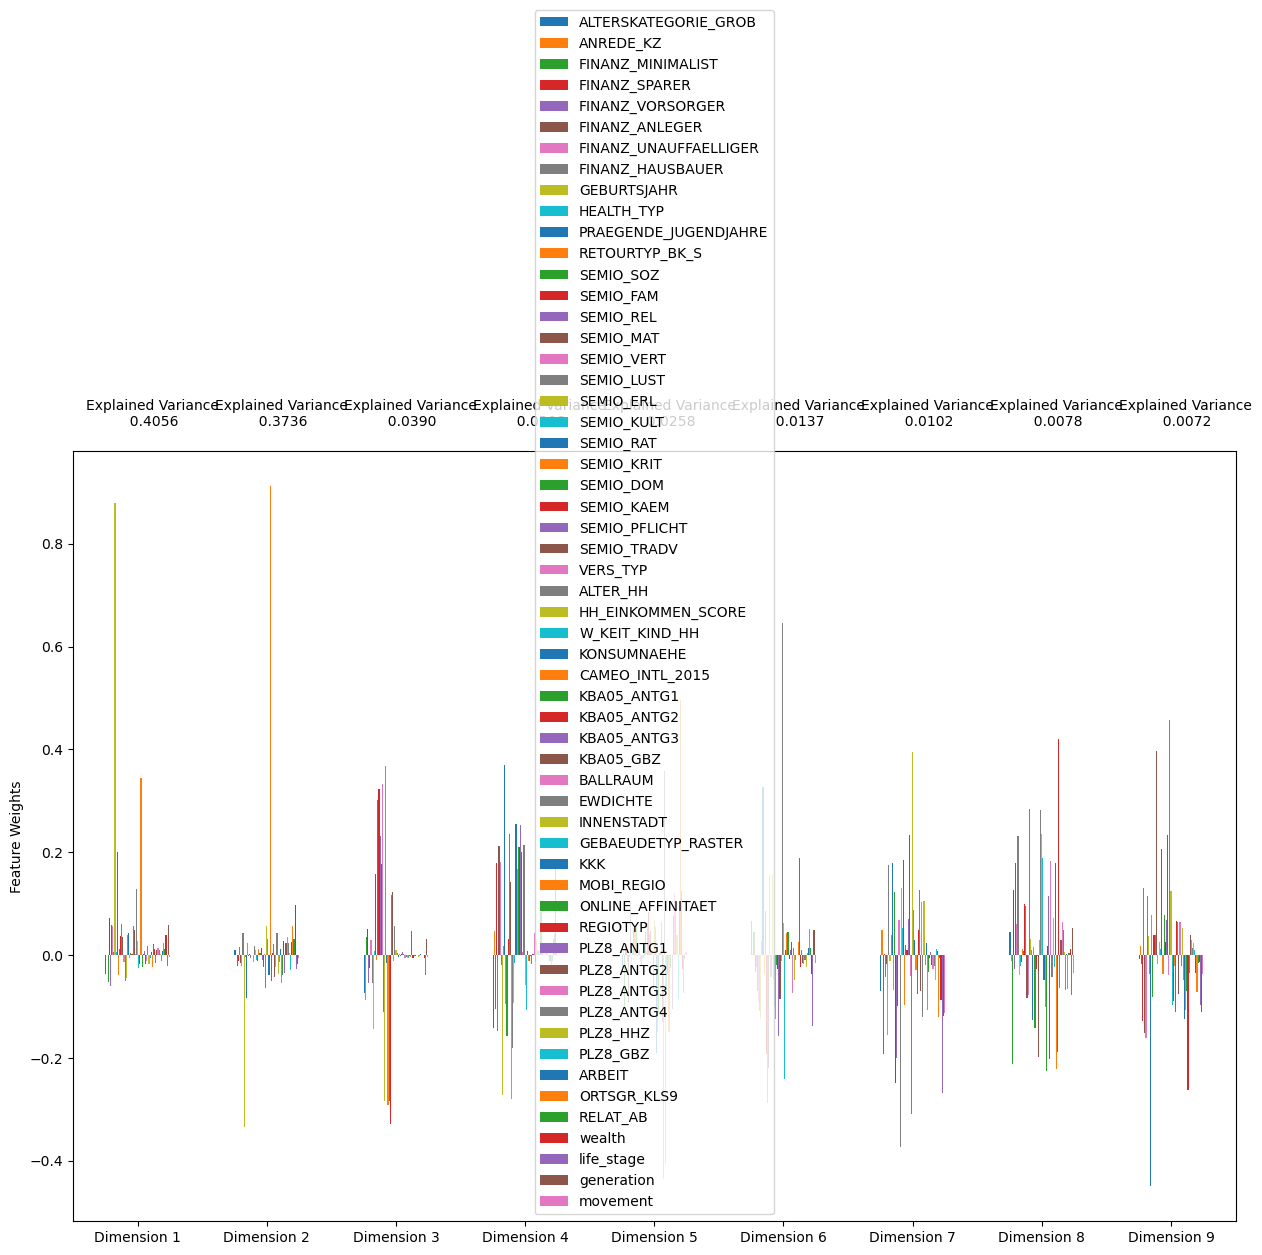

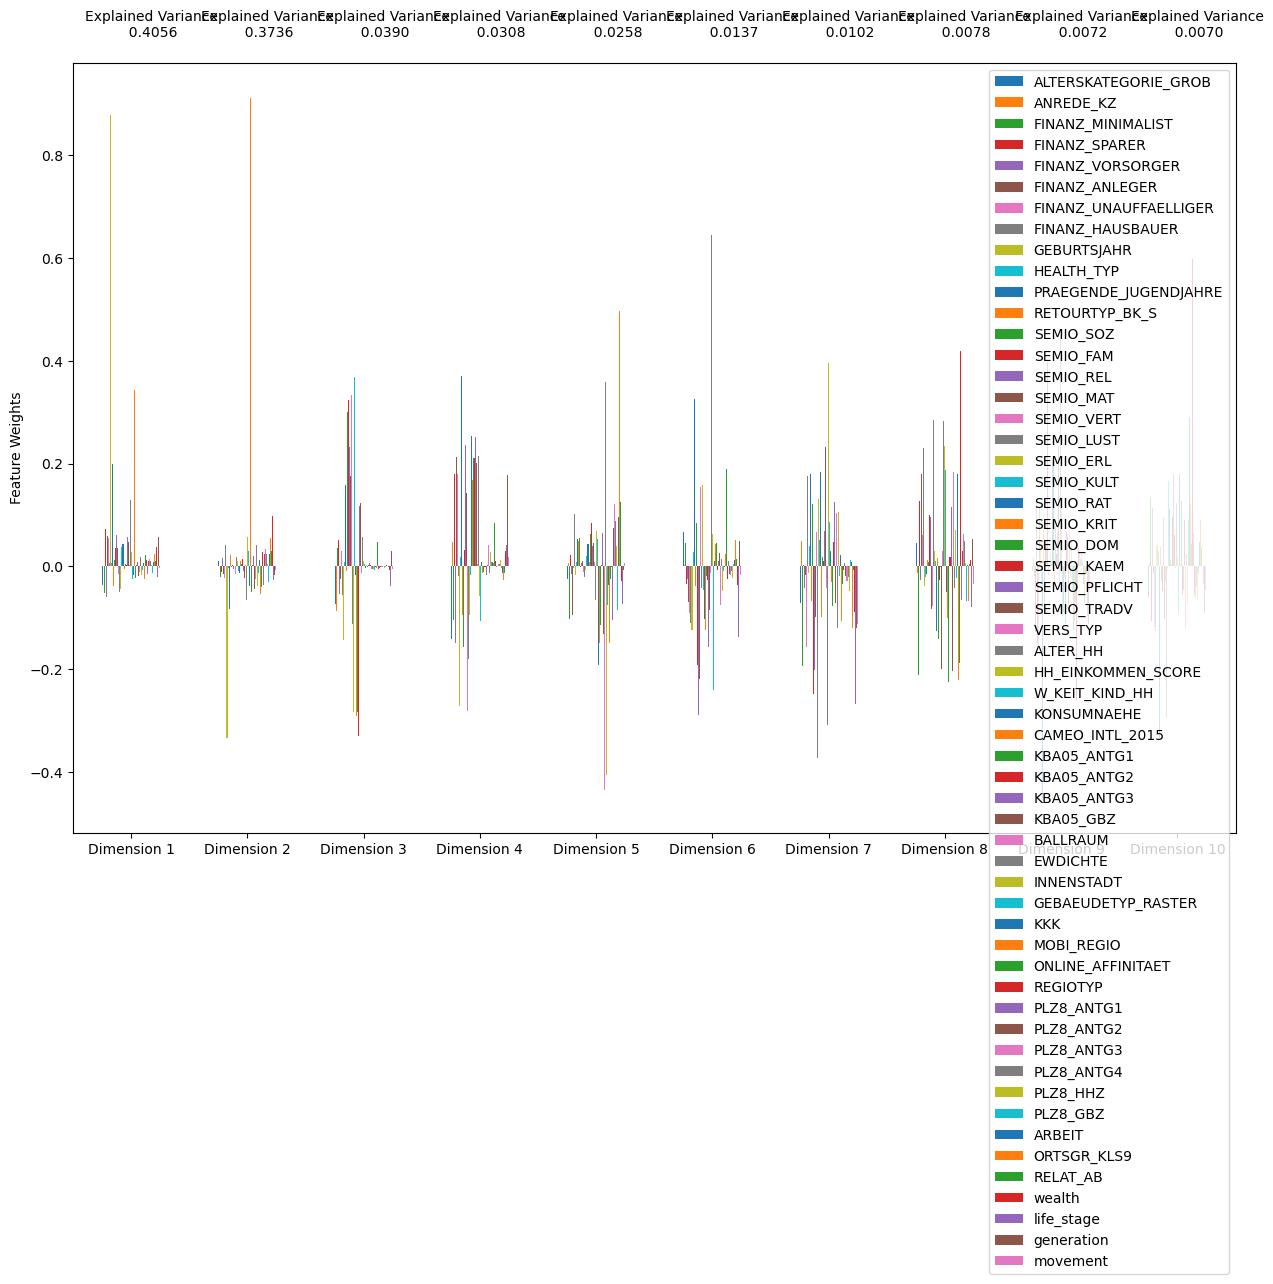

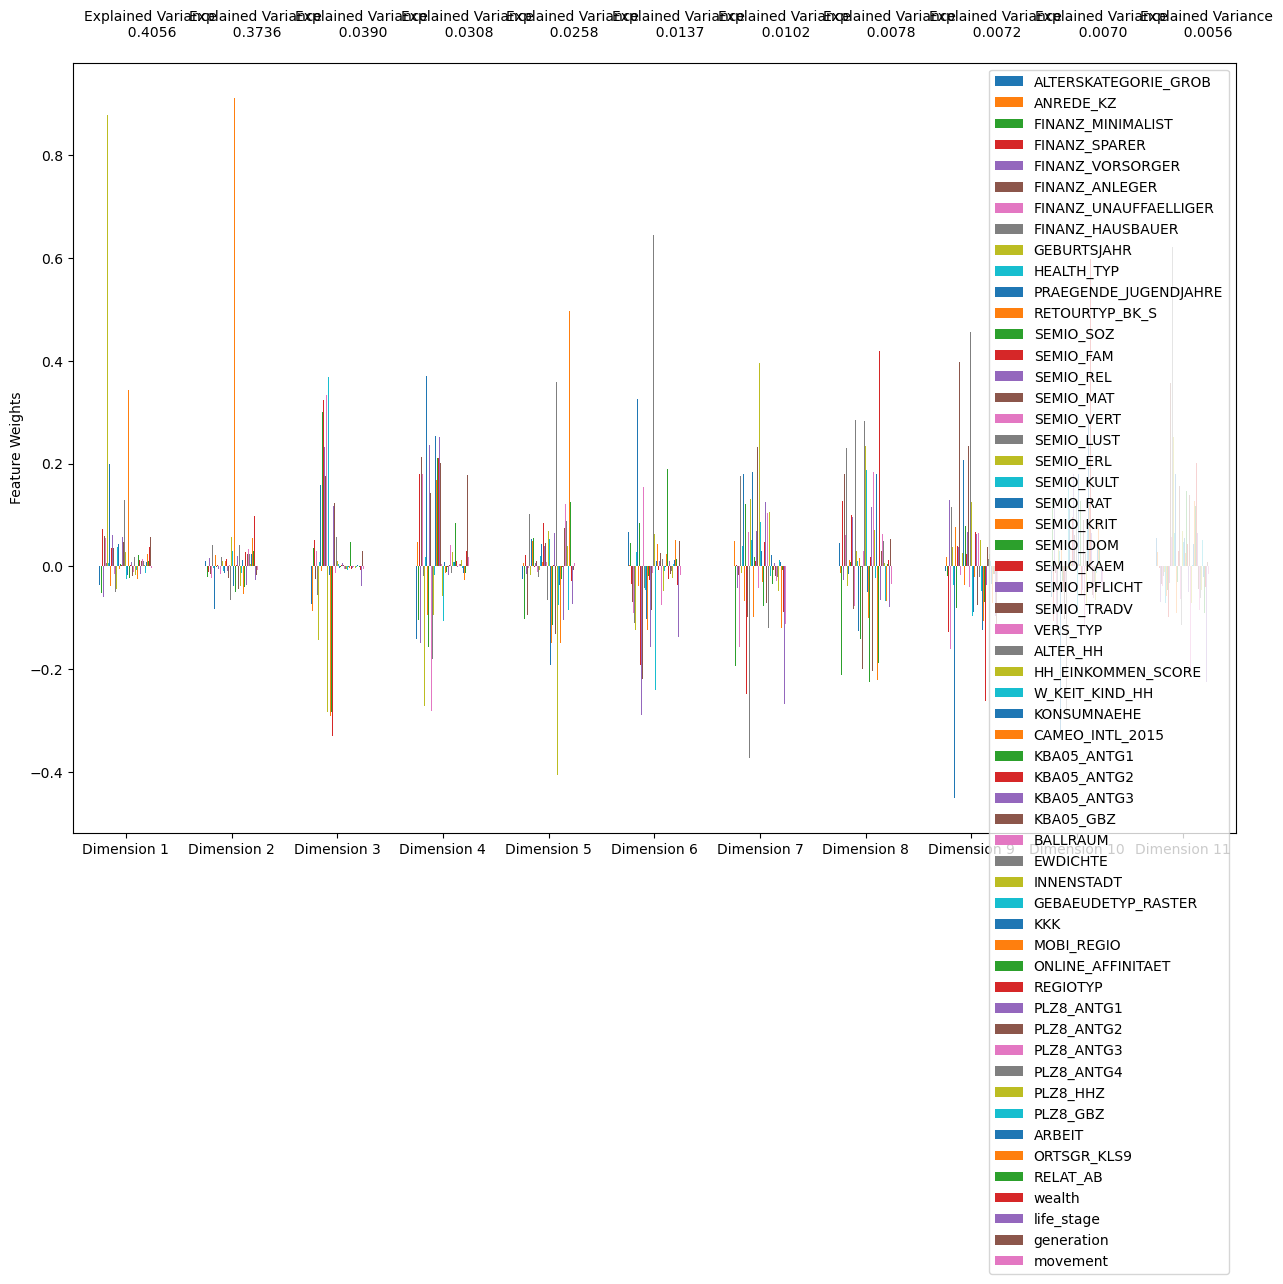

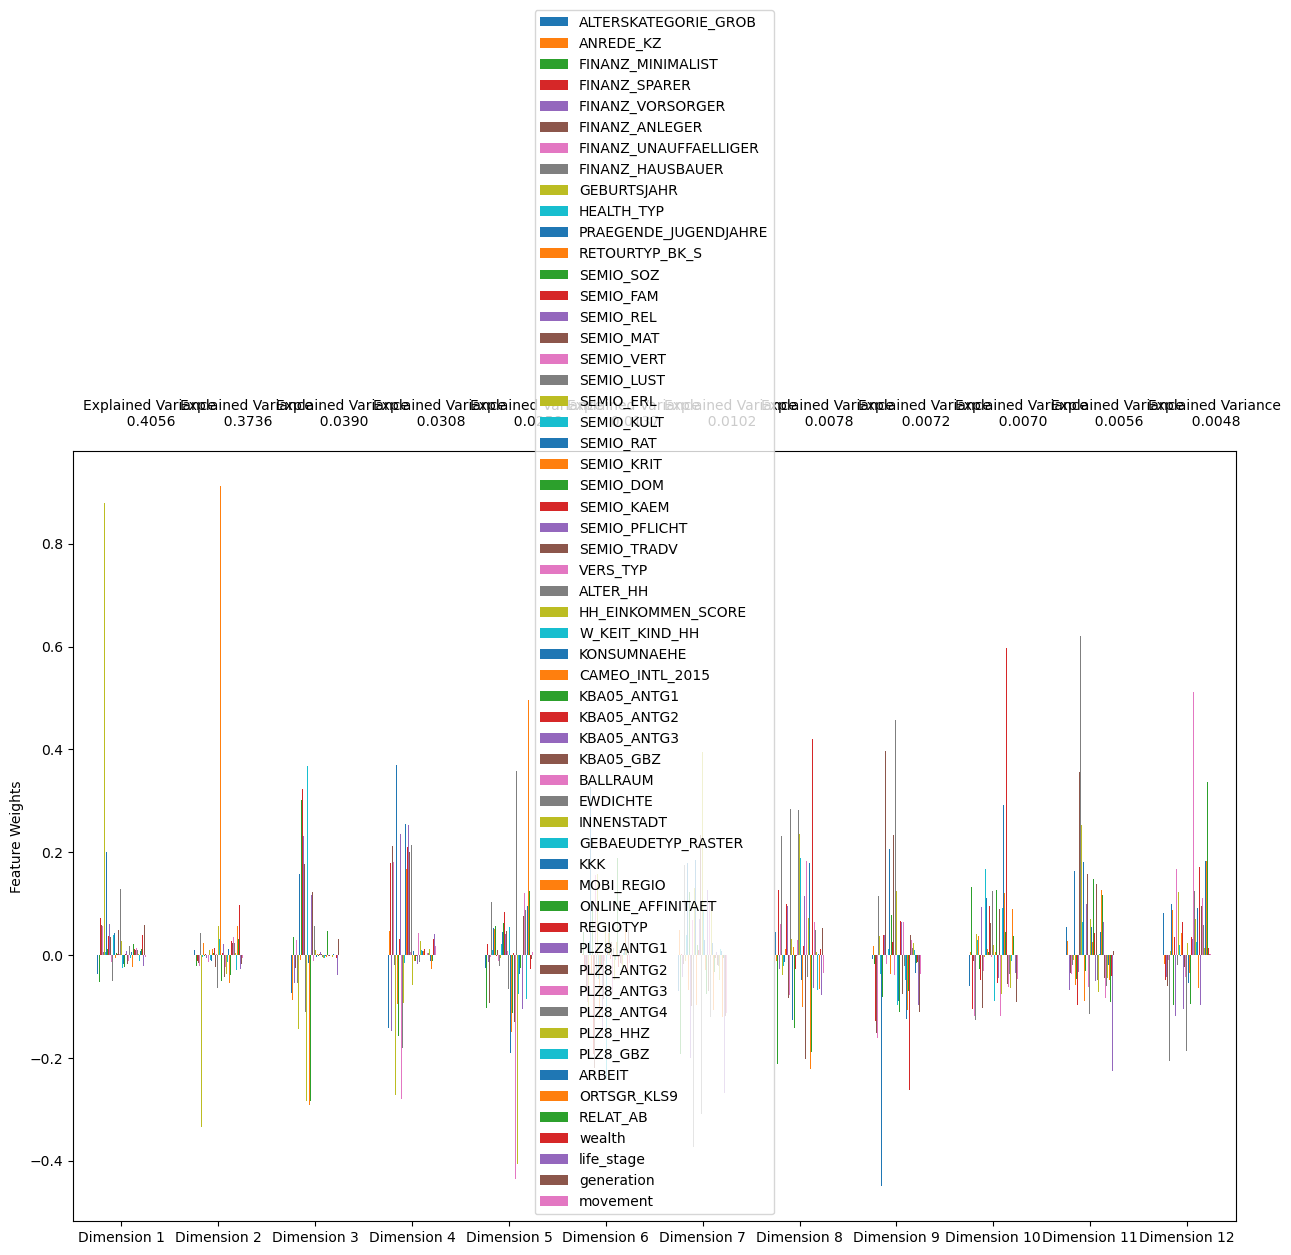

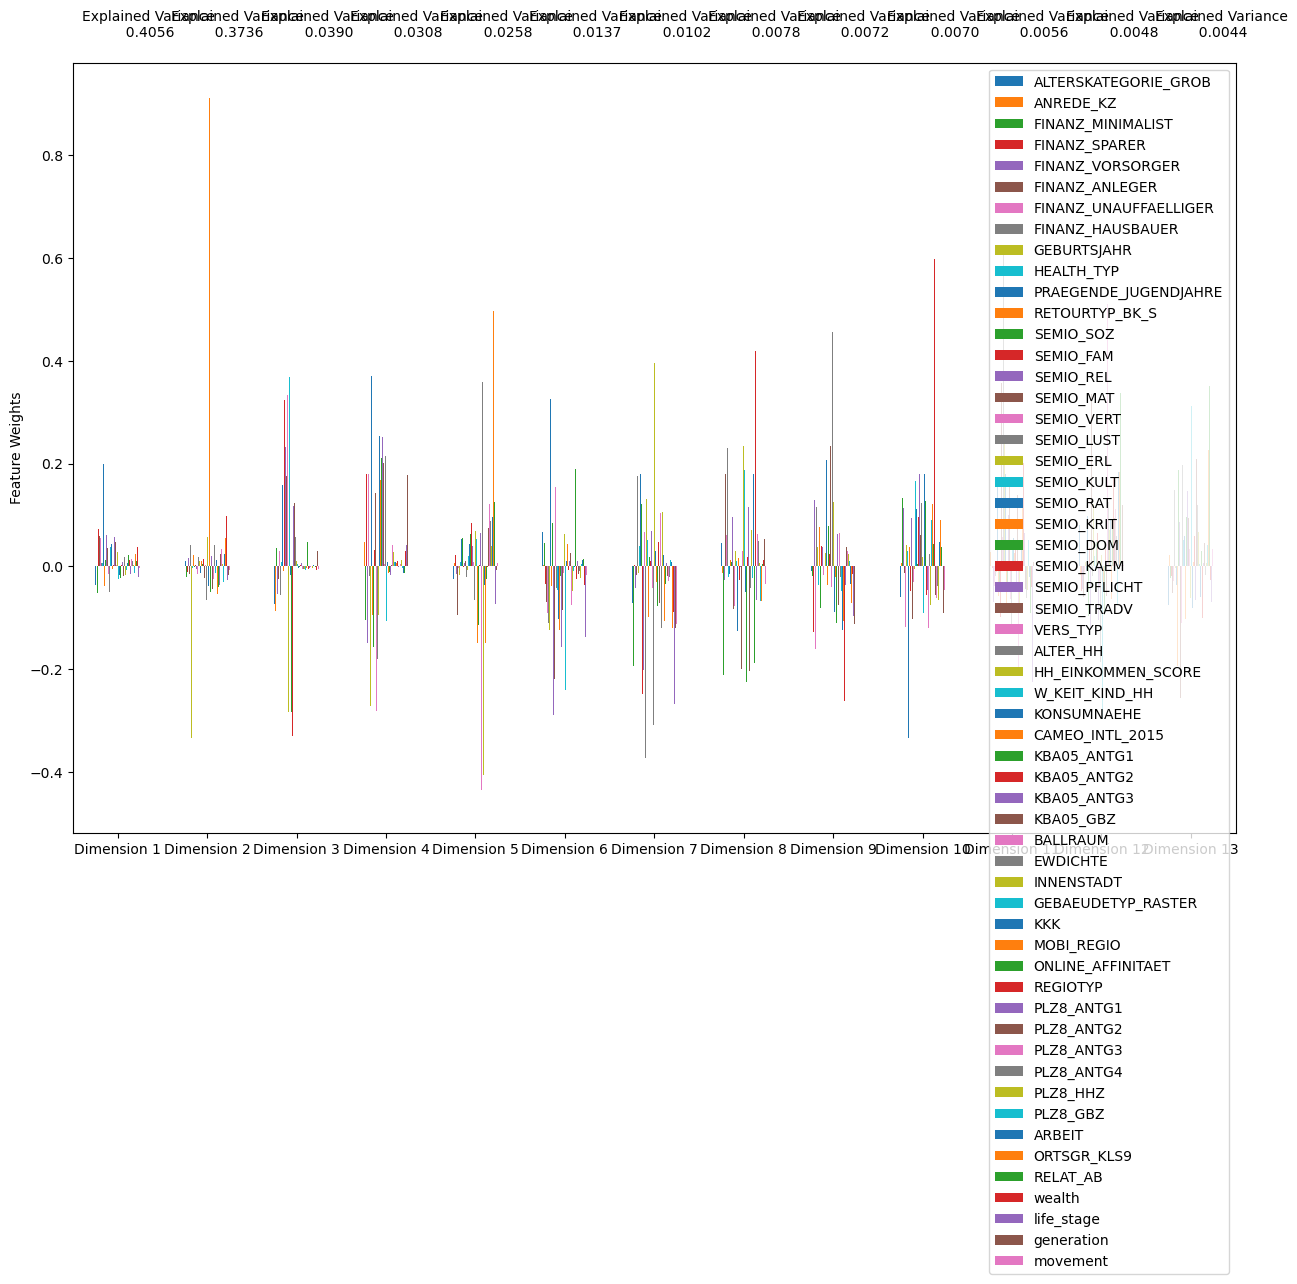

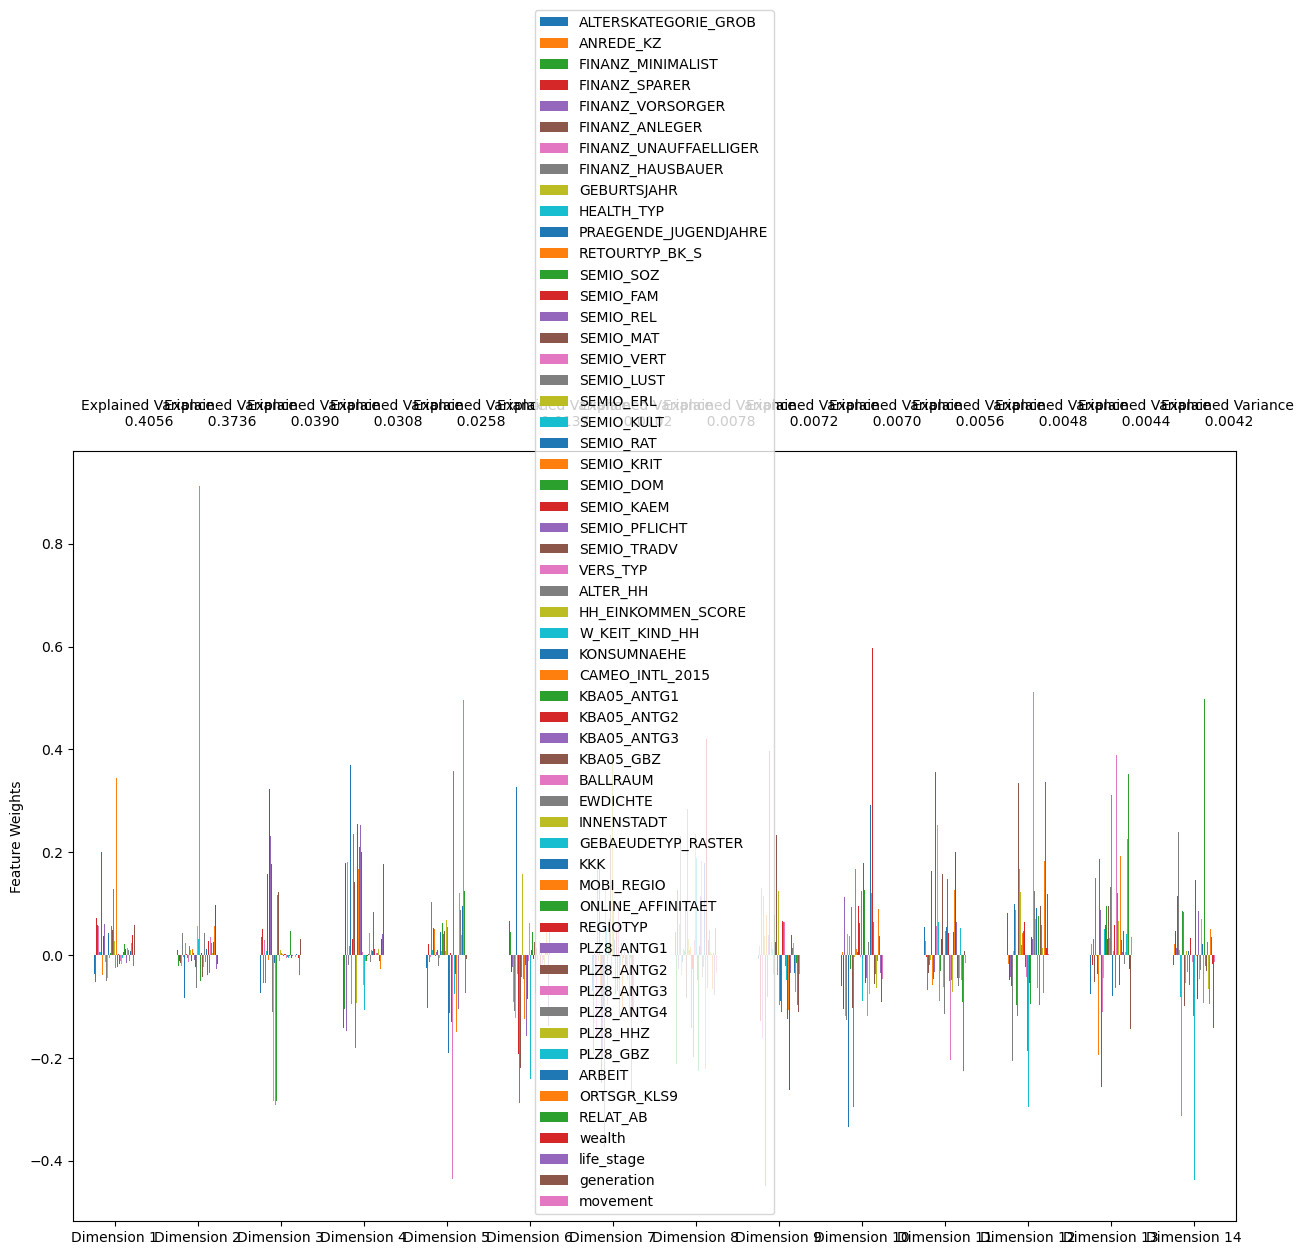

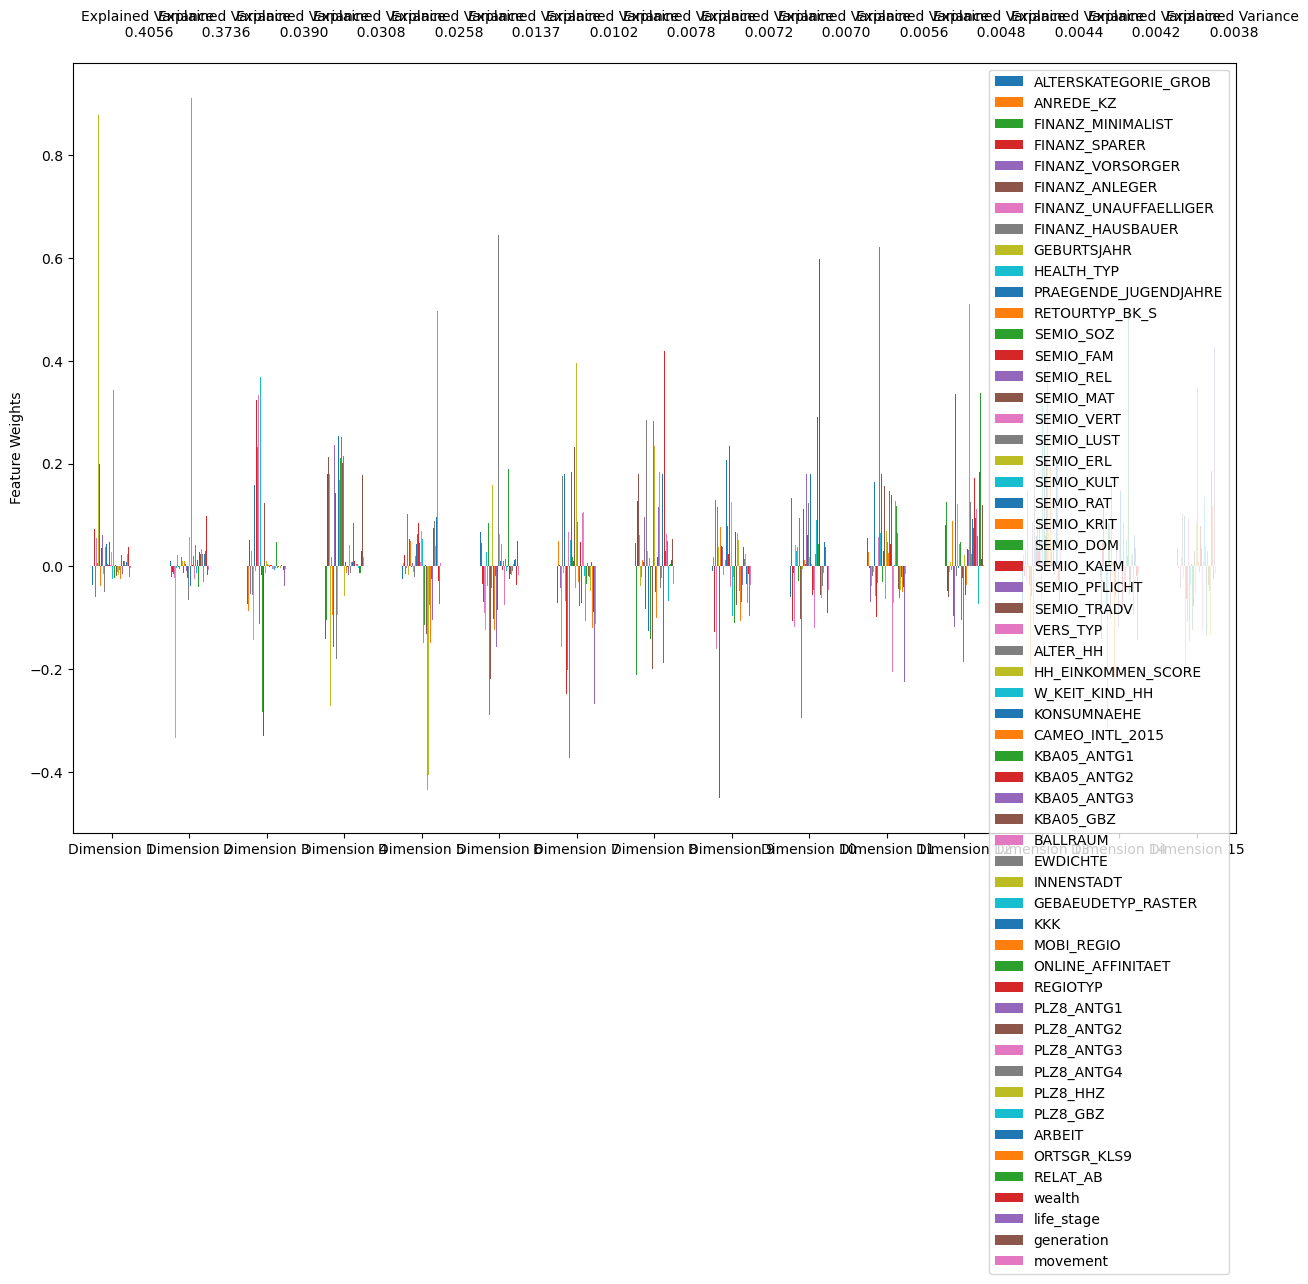

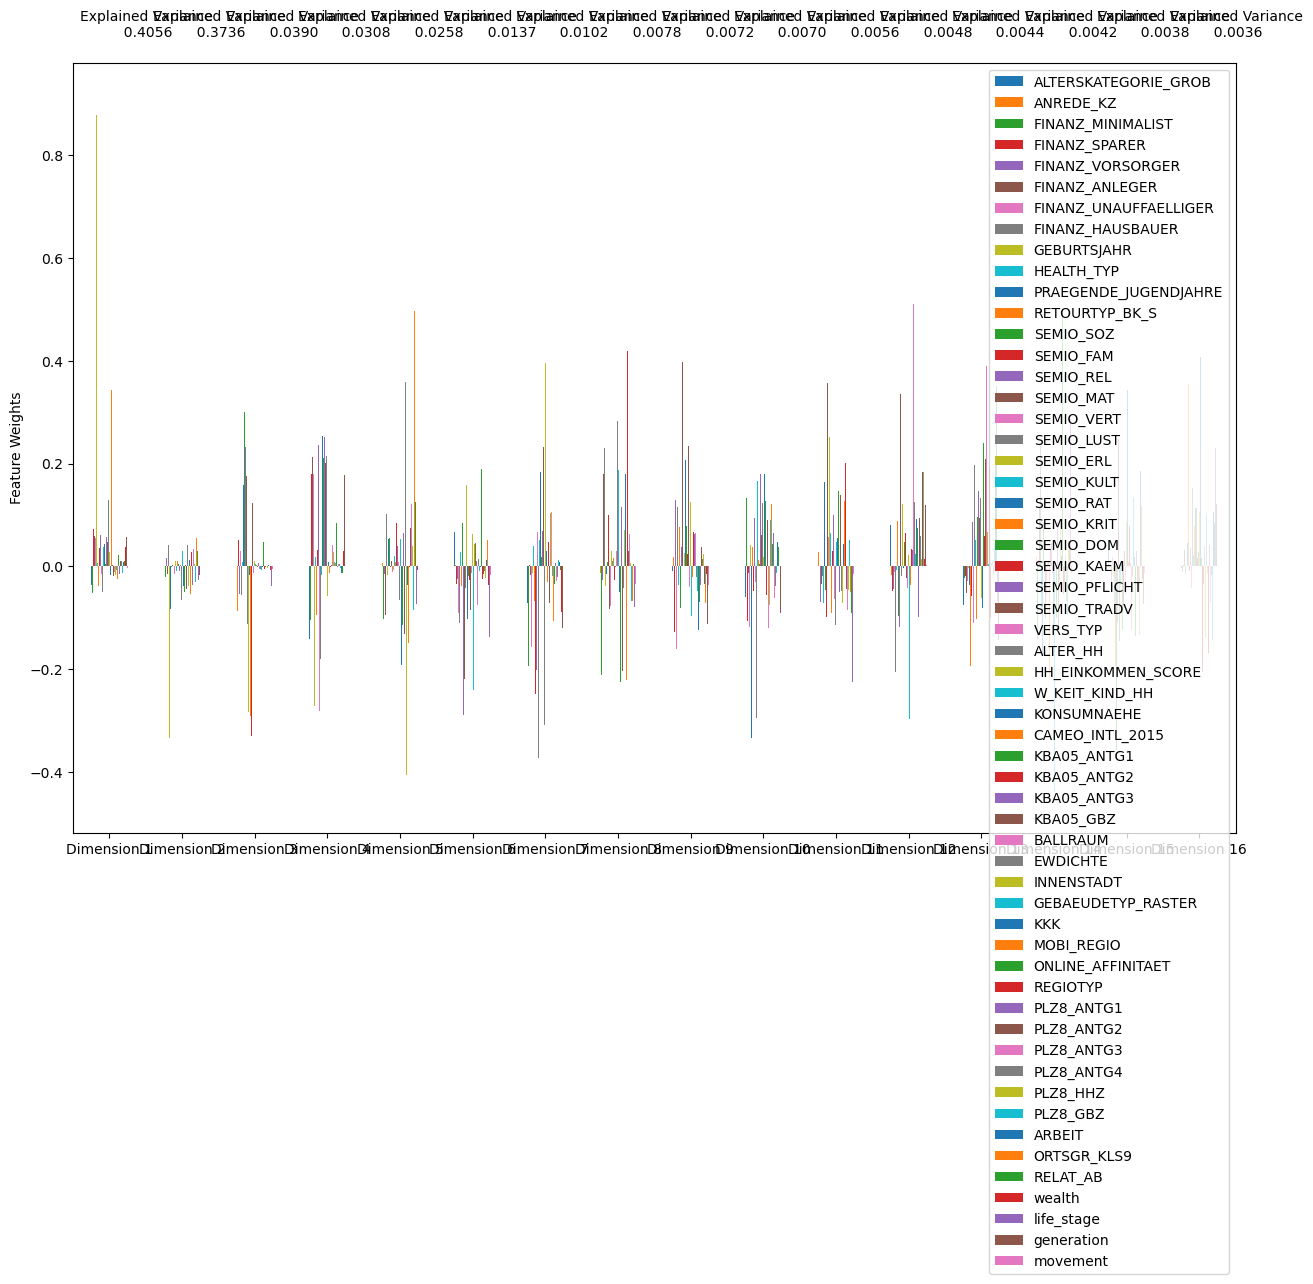

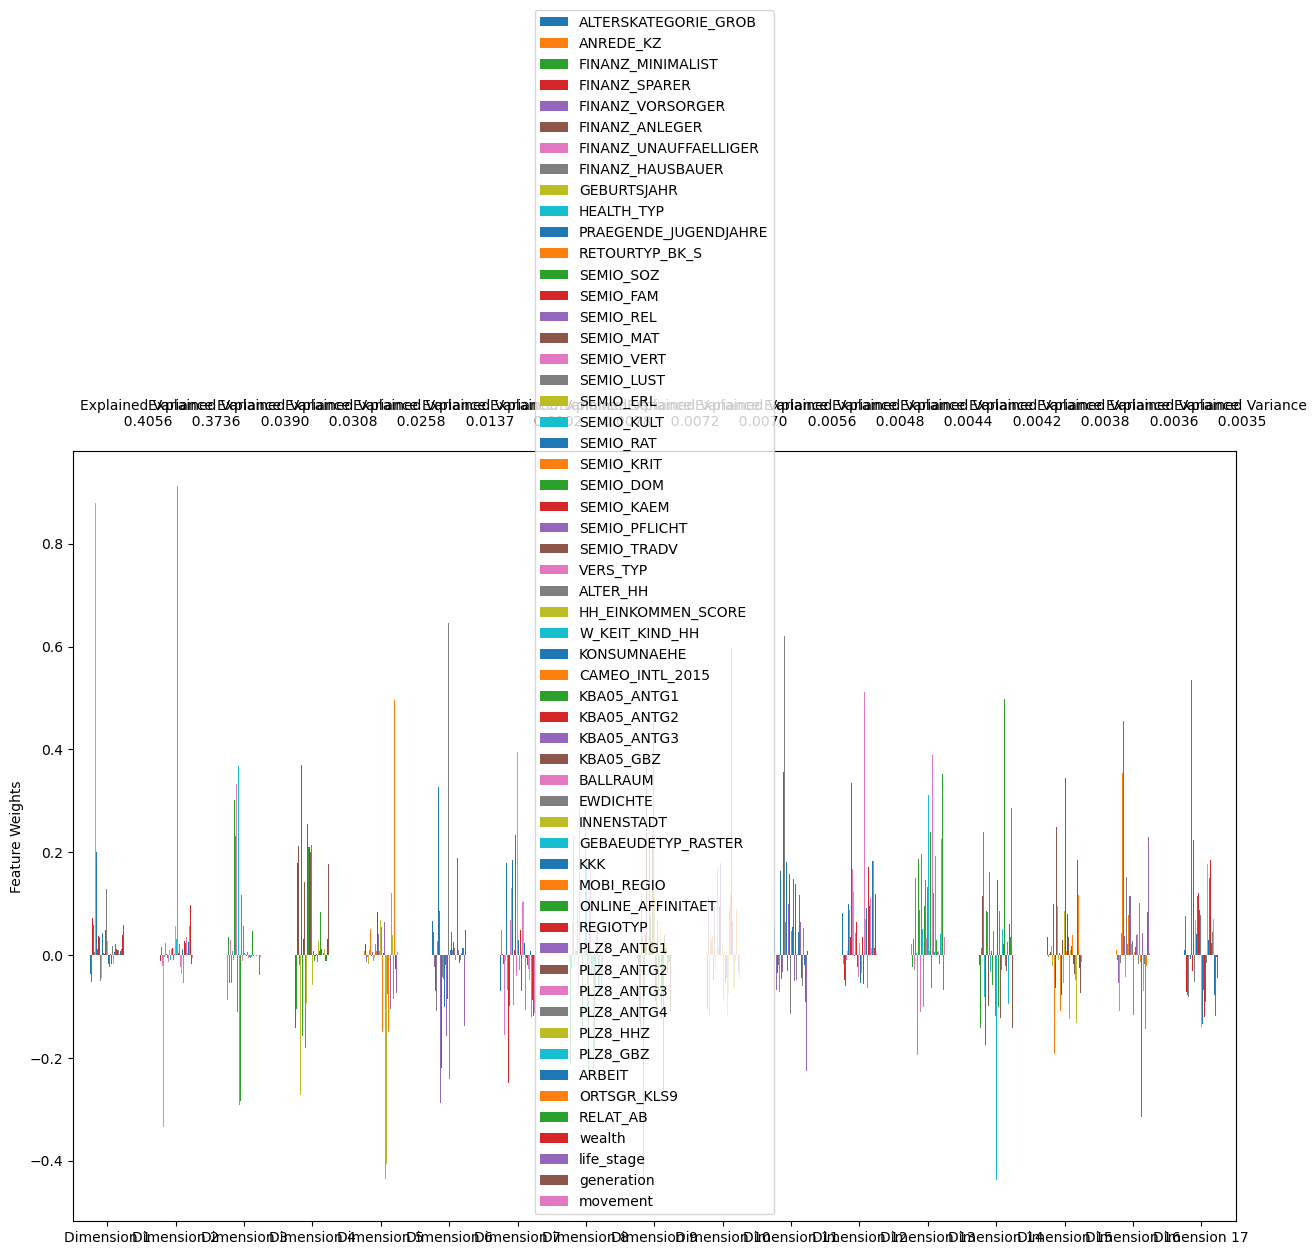

In [510]:
#loop to investigate variability threshold
for comp in range(3, df.shape[1]):
    pca, X_pca = apply_pca(comp, df)
    comp_check = pca_results(df, pca)
    if comp_check['Explained Variance'].sum() > 0.95:
        break      #finding pca value where 95% of our data variability is captured
        

num_comps = comp_check.shape[0]
print("Using {} components, we can explain {}% of the variability in the original data.".format(comp_check.shape[0],comp_check['Explained Variance'].sum()))

In [ ]:
#Manually confirming this:

In [511]:
pca, df_pca = apply_pca(17, df)

In [512]:
pca

PCA(n_components=17)

Explained Variance  ALTERSKATEGORIE_GROB  ANREDE_KZ  \
Dimension 1               0.4056               -0.0368    -0.0001   
Dimension 2               0.3736                0.0101     0.0003   
Dimension 3               0.0390               -0.0736    -0.0874   
Dimension 4               0.0308               -0.1419     0.0478   
Dimension 5               0.0258               -0.0248     0.0072   
Dimension 6               0.0137                0.0673     0.0025   
Dimension 7               0.0102               -0.0705     0.0491   
Dimension 8               0.0078                0.0450    -0.0120   
Dimension 9               0.0072               -0.0083     0.0180   
Dimension 10              0.0070               -0.0592     0.0065   
Dimension 11              0.0056                0.0546     0.0278   
Dimension 12              0.0048                0.0815    -0.0169   
Dimension 13              0.0044               -0.0747     0.0216   
Dimension 14              0.0042               -0.0198     0.0209   
Dimension 15              0.0038                0.0354    -0.0037   
Dimension 16              0.0036               -0.0031     0.0091   
Dimension 17              0.0035                0.0105     0.0096   

              FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
Dimension 1             -0.0516         0.0732           -0.0599   
Dimension 2             -0.0210        -0.0108            0.0162   
Dimension 3              0.0351         0.0515           -0.0540   
Dimension 4             -0.1038         0.1791           -0.1484   
Dimension 5             -0.1023         0.0223           -0.0140   
Dimension 6              0.0447        -0.0337           -0.0238   
Dimension 7             -0.1929         0.0025           -0.0419   
Dimension 8             -0.2114         0.1267           -0.0272   
Dimension 9             -0.0180        -0.1277            0.1301   
Dimension 10             0.1325        -0.1053            0.1130   
Dimension 11             0.0011        -0.0034           -0.0686   
Dimension 12             0.1258        -0.0487           -0.0431   
Dimension 13            -0.0227        -0.0184            0.0312   
Dimension 14            -0.1414         0.0465            0.0135   
Dimension 15            -0.0448         0.0013           -0.0411   
Dimension 16            -0.0103         0.0026           -0.0550   
Dimension 17             0.0756        -0.0710           -0.0071   

              FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
Dimension 1           0.0587                 0.0561            0.0067   
Dimension 2          -0.0156                -0.0220            0.0421   
Dimension 3          -0.0243                 0.0293           -0.0546   
Dimension 4           0.2123                 0.1806           -0.0184   
Dimension 5          -0.0940                -0.0036            0.1024   
Dimension 6          -0.0693                -0.0908           -0.1096   
Dimension 7          -0.0163                -0.1562            0.1755   
Dimension 8           0.1801                 0.0614            0.2312   
Dimension 9          -0.1507                -0.1613            0.1158   
Dimension 10         -0.0121                -0.1178           -0.1260   
Dimension 11         -0.0346                -0.0371           -0.0192   
Dimension 12         -0.0602                -0.0100           -0.2062   
Dimension 13         -0.0515                -0.0291            0.1495   
Dimension 14          0.1148                -0.0015            0.2400   
Dimension 15          0.0068                 0.0176            0.1019   
Dimension 16          0.0321                -0.1090           -0.0153   
Dimension 17         -0.0784                 0.0290           -0.0810   

              GEBURTSJAHR  HEALTH_TYP  PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  \
Dimension 1        0.8790      0.0066                 0.2001         -0.0379   
Dimension 2       -0.3346     -0.0027                -0.0837          0

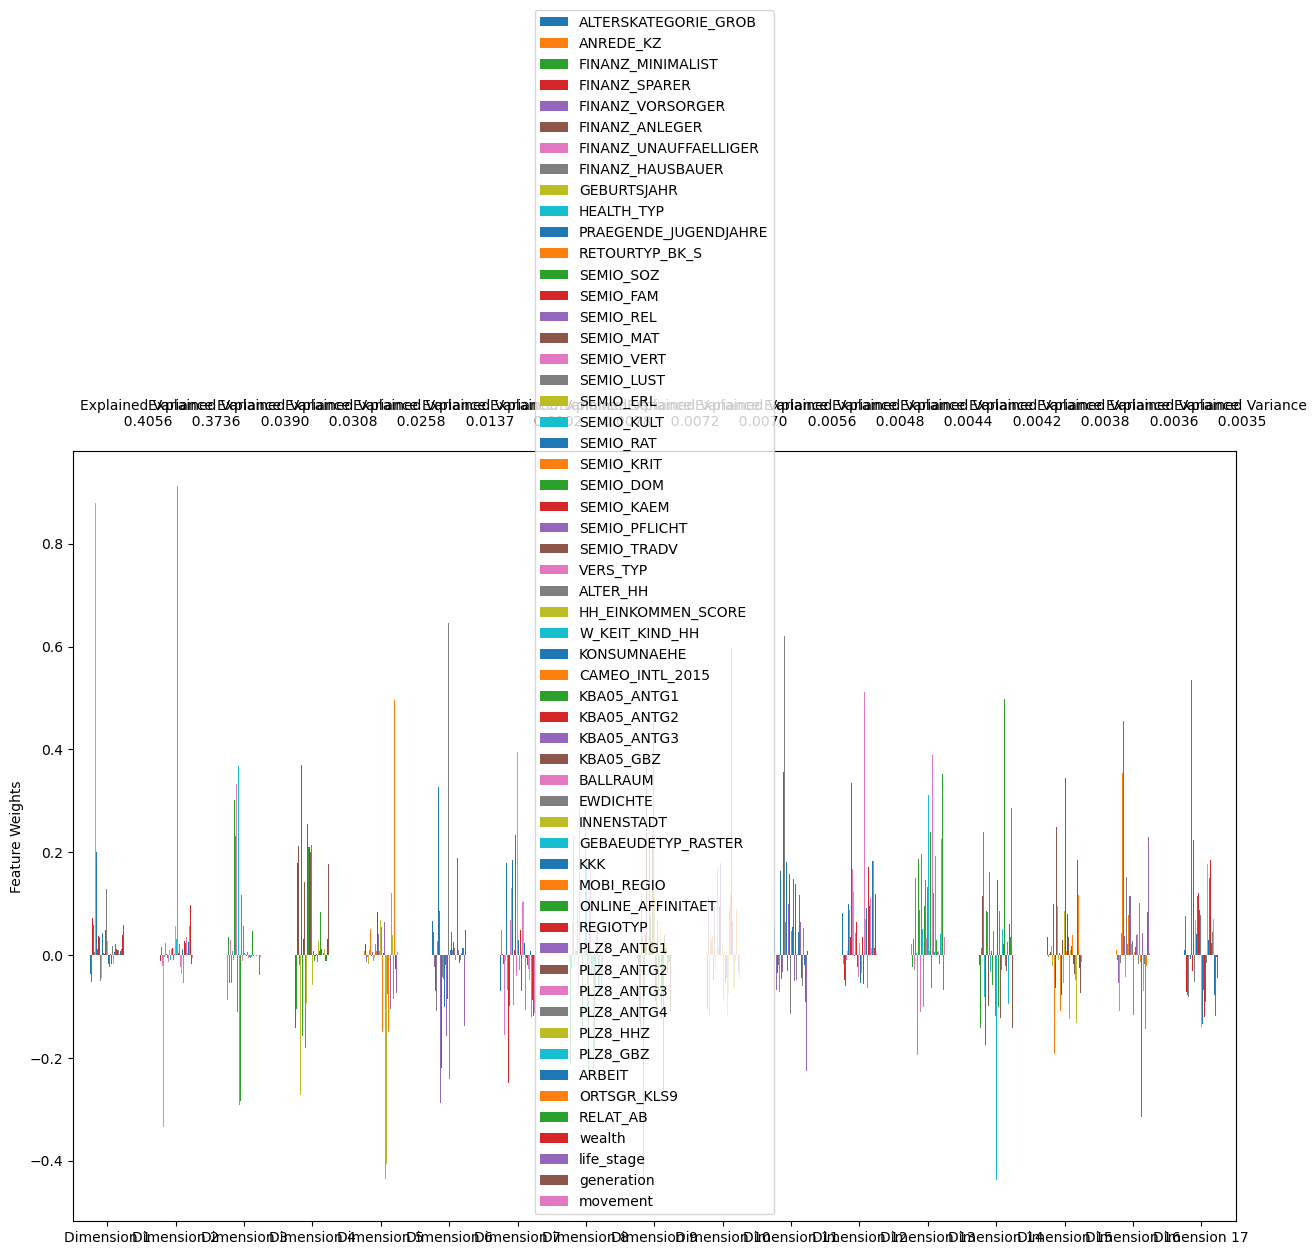

In [516]:
pca_results(df, pca)

0.9505999999999999

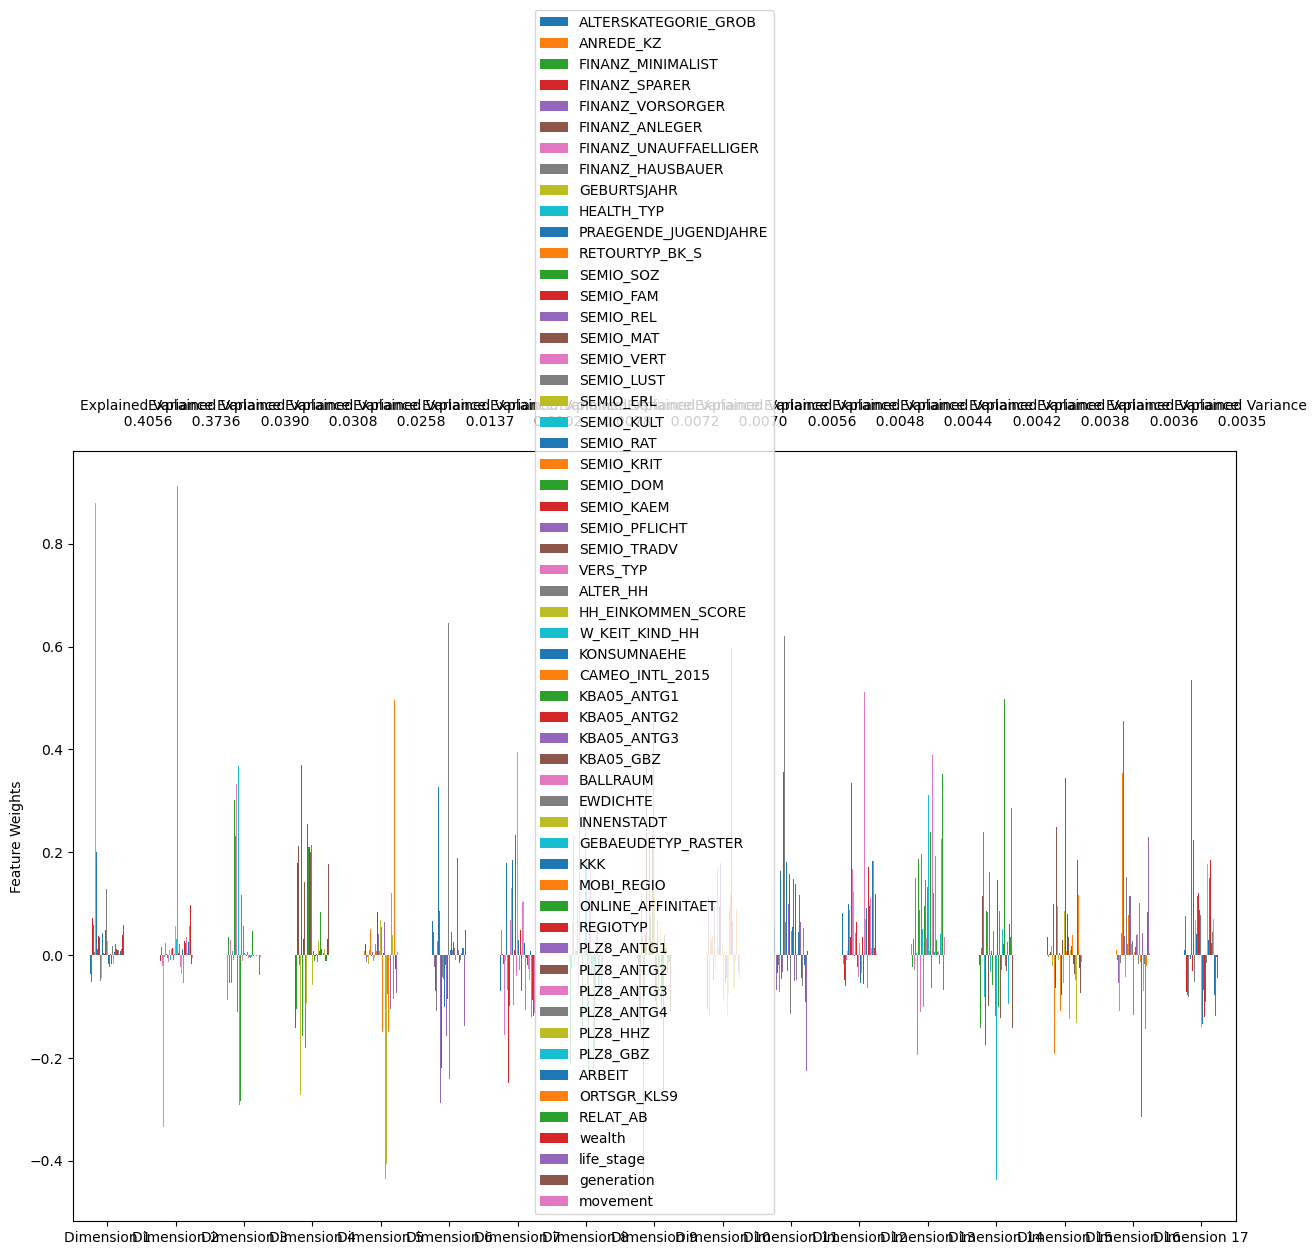

In [518]:
pca_results(df, pca)['Explained Variance'].sum()

#Confirmed 

In [520]:
# Investigate the variance accounted for by each principal component.

In [522]:
# Re-apply PCA to the data while selecting for number of components to retain.

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

• PCA being a component of data optimization using data reduction, in this particular evaluation, we are attempting to explain 95% of our data's variability.

• Using the For-Loop and a variance threshold, we were able to discover `17` n_components were just right.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [542]:
apply_pca?

Signature:
apply_pca(
    x: str = None,
    df: pandas.core.frame.DataFrame = array([[-0.75167967, -1.045218  , -0.05641562, ...,  1.21814982,
         1.10233491,  1.46453679],
       [-1.74333933,  0.95673821, -1.57035806, ..., -1.36014202,
         0.39299478, -0.68280975],
       [ 0.23997999,  0.95673821, -1.57035806, ...,  0.57357686,
         0.39299478,  1.46453679],
       ...,
       [-0.75167967,  0.95673821, -0.81338684, ...,  0.57357686,
         0.39299478, -0.68280975],
       [-1.74333933, -1.045218  , -1.57035806, ..., -1.36014202,
         0.39299478, -0.68280975],
       [ 1.23163965, -1.045218  ,  0.7005556 , ..., -0.0709961 ,
        -1.7350256 , -0.68280975]]),
)
Docstring:
INPUT:
x: str denoting number of components to be broken down into
df: scaled dataframe to find principal components
OUTPUT:
df_pca: (np.array) denoting result
pca: object denoting PCA's instantiation
File:      /var/folders/y1/2cln1s193dgc6xy3yzry761r0000gn/T/ipykernel_25560/3880974741.py
Typ

In [596]:
def apply_pca(x:str=None, df:pd.DataFrame=scaled_data):
    """
    INPUT:
    x: str denoting number of components to be broken down into
    df: scaled dataframe to find principal components
    OUTPUT:
    df_pca: (np.array) denoting result
    pca: object denoting PCA's instantiation
    """
    pca = PCA(n_components=x)
    df_pca = pca.fit_transform(df)
    return pca, df_pca

In [602]:
#df.keys()

In [604]:
#pca.components_

In [624]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

In [626]:
def weights(n:int, pca:sklearn.decomposition.PCA, df:pd.DataFrame) -> pd.DataFrame:
    """
    INPUT: 
    n(int): index ot principal component to analyze
    pca(sklearn.decomposition.PCA): a PCA fitted object containing eigen vectors
    df(pd.DataFrame): a dataframe to examine weights

    OUTPUT: 
    df(pd.DataFrame): result dataframe having columns as index, and corresponding weights
    """
    
    col_list = list(df.keys())
    weight=list(pca.components_[n])
    
    df =pd.DataFrame(list(zip(col_list, weight)))
    df = df.set_axis(['Dimension', 'Weights'], axis=1)
    df = df.sort_values(by=['Weights'] , ascending=False)
    df.set_index('Dimension', inplace=True)
    
    return df

In [656]:
weights(0, pca, df)

Weights
Dimension                      
FINANZ_MINIMALIST      0.229318
ALTERSKATEGORIE_GROB   0.194085
FINANZ_VORSORGER       0.191663
MOBI_REGIO             0.191170
PLZ8_ANTG1             0.185766
KBA05_ANTG1            0.182522
KBA05_GBZ              0.168908
SEMIO_ERL              0.136608
KONSUMNAEHE            0.136109
PLZ8_GBZ               0.131441
INNENSTADT             0.129192
SEMIO_LUST             0.120877
BALLRAUM               0.096053
GEBAEUDETYP_RASTER     0.088372
life_stage             0.086499
RETOURTYP_BK_S         0.077565
SEMIO_VERT             0.052399
movement               0.037828
W_KEIT_KIND_HH         0.021494
ANREDE_KZ             -0.001594
SEMIO_KRIT            -0.002723
KBA05_ANTG2           -0.016240
ONLINE_AFFINITAET     -0.017144
SEMIO_DOM             -0.031451
VERS_TYP              -0.034315
SEMIO_KAEM            -0.035737
KKK                   -0.036410
SEMIO_SOZ             -0.038566
HEALTH_TYP            -0.044458
PLZ8_HHZ              -0.046792
REGIOTYP              -0.058849
FINANZ_HAUSBAUER      -0.102541
KBA05_ANTG3           -0.105575
RELAT_AB              -0.108207
SEMIO_KULT            -0.108378
ARBEIT                -0.110741
ALTER_HH              -0.115171
SEMIO_FAM             -0.119911
SEMIO_MAT             -0.123324
HH_EINKOMMEN_SCORE    -0.129063
PLZ8_ANTG2            -0.133286
FINANZ_ANLEGER        -0.146974
SEMIO_TRADV           -0.149954
SEMIO_RAT             -0.151961
GEBURTSJAHR           -0.154987
FINANZ_UNAUFFAELLIGER -0.156940
ORTSGR_KLS9           -0.157584
EWDICHTE              -0.158743
generation            -0.165501
CAMEO_INTL_2015       -0.169829
wealth                -0.173805
SEMIO_REL             -0.178398
PLZ8_ANTG4            -0.179767
SEMIO_PFLICHT         -0.183856
PRAEGENDE_JUGENDJAHRE -0.184410
PLZ8_ANTG3            -0.188918
FINANZ_SPARER         -0.223873

In [658]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights(1, pca, df)

Weights
Dimension                      
PRAEGENDE_JUGENDJAHRE  0.206729
FINANZ_UNAUFFAELLIGER  0.179384
MOBI_REGIO             0.178997
FINANZ_ANLEGER         0.177996
PLZ8_ANTG1             0.175386
generation             0.171929
ALTER_HH               0.170954
FINANZ_SPARER          0.167656
SEMIO_REL              0.164912
SEMIO_TRADV            0.164501
ONLINE_AFFINITAET      0.162972
KBA05_GBZ              0.162292
GEBURTSJAHR            0.162279
SEMIO_PFLICHT          0.159283
KBA05_ANTG1            0.156615
INNENSTADT             0.139680
KONSUMNAEHE            0.134729
SEMIO_RAT              0.130154
SEMIO_KULT             0.124536
PLZ8_GBZ               0.124462
BALLRAUM               0.112481
SEMIO_FAM              0.106223
SEMIO_MAT              0.104005
GEBAEUDETYP_RASTER     0.089400
life_stage             0.063717
movement               0.053716
HEALTH_TYP             0.040954
SEMIO_SOZ              0.029146
SEMIO_VERT             0.017606
FINANZ_MINIMALIST      0.012488
KBA05_ANTG2           -0.010449
KKK                   -0.013749
VERS_TYP              -0.025768
SEMIO_DOM             -0.027564
PLZ8_HHZ              -0.029365
ANREDE_KZ             -0.040098
REGIOTYP              -0.041990
SEMIO_KRIT            -0.051208
SEMIO_KAEM            -0.063514
KBA05_ANTG3           -0.113761
RELAT_AB              -0.120191
ARBEIT                -0.126006
PLZ8_ANTG2            -0.128619
SEMIO_LUST            -0.129557
W_KEIT_KIND_HH        -0.135544
HH_EINKOMMEN_SCORE    -0.135878
wealth                -0.137314
RETOURTYP_BK_S        -0.149344
SEMIO_ERL             -0.152071
CAMEO_INTL_2015       -0.157222
PLZ8_ANTG4            -0.164351
EWDICHTE              -0.166822
ORTSGR_KLS9           -0.167206
FINANZ_HAUSBAUER      -0.168243
PLZ8_ANTG3            -0.176616
FINANZ_VORSORGER      -0.177758
ALTERSKATEGORIE_GROB  -0.181924

In [660]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights(2, pca, df)

Weights
Dimension                      
SEMIO_KAEM             0.362258
ANREDE_KZ              0.359698
SEMIO_DOM              0.334016
SEMIO_KRIT             0.312112
SEMIO_ERL              0.198613
SEMIO_RAT              0.155493
FINANZ_ANLEGER         0.154328
FINANZ_UNAUFFAELLIGER  0.081205
generation             0.074611
life_stage             0.062810
FINANZ_SPARER          0.058668
FINANZ_HAUSBAUER       0.047142
movement               0.046853
VERS_TYP               0.044247
ALTER_HH               0.036985
INNENSTADT             0.033044
PRAEGENDE_JUGENDJAHRE  0.032731
BALLRAUM               0.032170
GEBAEUDETYP_RASTER     0.031977
GEBURTSJAHR            0.031267
MOBI_REGIO             0.026718
PLZ8_ANTG1             0.025417
KONSUMNAEHE            0.024516
SEMIO_PFLICHT          0.021336
PLZ8_GBZ               0.016605
KBA05_GBZ              0.016061
KBA05_ANTG1            0.012158
PLZ8_HHZ               0.011720
KKK                    0.010598
wealth                 0.009429
ONLINE_AFFINITAET      0.009091
SEMIO_LUST             0.006438
REGIOTYP               0.006241
HEALTH_TYP            -0.000829
SEMIO_TRADV           -0.005386
KBA05_ANTG2           -0.005493
ALTERSKATEGORIE_GROB  -0.012316
CAMEO_INTL_2015       -0.013452
PLZ8_ANTG2            -0.013932
PLZ8_ANTG4            -0.017290
PLZ8_ANTG3            -0.017721
RELAT_AB              -0.021956
EWDICHTE              -0.023377
ARBEIT                -0.029406
ORTSGR_KLS9           -0.030047
KBA05_ANTG3           -0.034780
FINANZ_VORSORGER      -0.041852
HH_EINKOMMEN_SCORE    -0.042799
RETOURTYP_BK_S        -0.063975
W_KEIT_KIND_HH        -0.065226
SEMIO_REL             -0.079580
SEMIO_MAT             -0.085643
FINANZ_MINIMALIST     -0.112338
SEMIO_FAM             -0.248396
SEMIO_SOZ             -0.295717
SEMIO_KULT            -0.300572
SEMIO_VERT            -0.352078

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [677]:
pca, input_pca = apply_pca(17, df)

In [681]:
pca

PCA(n_components=17)

In [685]:
#input_pca

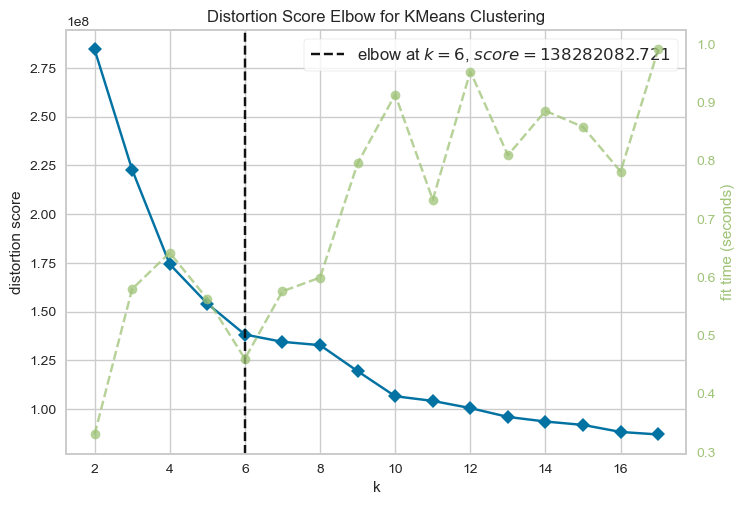

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [679]:
Elbow_M = KElbowVisualizer(KMeans(), k=17)

# Fit the visualizer to the PCA-transformed data
Elbow_M.fit(input_pca)

# Display the Elbow Method plot
Elbow_M.show()

In [689]:
pca

PCA(n_components=17)

In [ ]:
max_clusters = 30
inertias = []       #explaining total variance within cluster
silhouette_scores = []

for k in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(input_pca)
    inertias.append(-kmeans.score(input_pca))  # Negate score to get average distance
    silhouette_scores.append(silhouette_score(input_pca, kmeans.labels_))

# Plot the elbow curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters+1), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Average distance to cluster center')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')

plt.tight_layout()
plt.show()

In [ ]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.



In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.



### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data.
customers = 

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.



### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.